In [1]:
import csv
from datetime import datetime
from decimal import Decimal
import importlib
from itertools import compress
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nbformat         # required for optuna visualization
import numpy as np
import optuna
#import os
import pandas as pd
from pathlib import Path
import plotly           # required for optuna visualization
import ppscore as pps
#from scipy.stats import norm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

/Users/matthiasbandorf/wb/git-repos/Predict-Stock-with-RNN/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**+++ CONFIGURATION PARAMETERS +++**

In [2]:
# Configuration of the run

# Settings for optimization with Optuna
HYPER_PARAMS_OPT = True       # if True, hyperparameters will be optimized
#HYPER_PARAMS_OPT = False
HYPER_PARAMS_NUM_RUN = 100   # number of trials for hyperparameter optimization
# HYPER_PARAMS_NUM_RUN = 3
HYPER_PARAMS_FIX_NUM_EPOCHS = 0 # if > 0, number of epochs will be fixed
#HYPER_PARAMS_FIX_NUM_EPOCHS = 500
#HYPER_PARAMS_FIX_LR = 1e-5    # if > 0, learning rate will be fixed
HYPER_PARAMS_FIX_LR = 0
#HYPER_PARAMS_MIN_HL = 2         # min. number of hidden layers
HYPER_PARAMS_MIN_HL = 1         

# Settings for selection of data set
DATA_SET = "19-years"
#DATA_SET = "15-years"
#DATA_SET = "10-years"
#DATA_SET = "5-years"

# Settings for selection of feature set
#FEATURE_SEL = "ALL"
#FEATURE_SEL = "CORR"
FEATURE_SEL = "MIN"
#FEATURE_SEL = "MSFT"
#FEATURE_SEL = "PPS"
#FEATURE_SEL = "RFE"

# if FEATURE_SEL == RFE: set number of features to be selected
NUM_FEATURES = 5
#NUM_FEATURES = 10

# Limits for selection of feature with correlation matrix / PPS
LIMIT_CORR = 0.7    # values where abs(corr) > LIMIT_CORR will be selected
#LIMIT_CORR = 0.1    
LIMIT_PPS = 0.8    # values where ppscore > LIMIT_PPS will be selected
#LIMIT_PPS = 0.1

# Construct the title of the run; will be written to results
features_str = f"{FEATURE_SEL}"
if FEATURE_SEL == "CORR":
    features_str += f" (limit: {LIMIT_CORR})"
if FEATURE_SEL == "PPS":
    features_str += f" (limit: {LIMIT_PPS})"
elif FEATURE_SEL == "RFE":
    features_str += f" (number of features: {NUM_FEATURES})"

if HYPER_PARAMS_OPT == True:
    min_hl_str = f"min hl: {HYPER_PARAMS_MIN_HL}"
    fix_str = ""
    if HYPER_PARAMS_FIX_LR != 0 or HYPER_PARAMS_FIX_NUM_EPOCHS != 0:
        fix_str = ", fix: "
    if HYPER_PARAMS_FIX_LR != 0:
        fix_str += f" lr={HYPER_PARAMS_FIX_LR}, "
    if HYPER_PARAMS_FIX_NUM_EPOCHS != 0:
        fix_str += f" epochs={HYPER_PARAMS_FIX_NUM_EPOCHS}"

    hyperparams_str = f"Hyperparam optimization {fix_str}, {min_hl_str}, ({HYPER_PARAMS_NUM_RUN} trials)"
else:
    hyperparams_str = "No hyperparam optimization"

TITLE = f"Features: {features_str}, {hyperparams_str}, dataset: {DATA_SET}"
print(TITLE)

# location of data
ROOT_PATH = "../"
ROOT_DATA_PATH = ROOT_PATH + "data/stocks/"
DATA_PATH = ROOT_DATA_PATH + DATA_SET + "/"
DATA_PATH_MSFT = DATA_PATH + "MSFT.csv"
DATA_PATH_SP500 = DATA_PATH + "SP500.csv"
DATA_PATH_GOLD = DATA_PATH + "GOLD.csv"
DATA_PATH_FRED_RATES = DATA_PATH + "CPI-FED.csv"
DATA_PATH_GDP = DATA_PATH + "GDP.csv"
DATA_PATH_RESULTS = ROOT_PATH + "results/"
DATA_PATH_RESULTS_CSV = DATA_PATH_RESULTS + "results.csv"
DATA_PATH_MSFT_ENH = DATA_PATH_RESULTS + "MSFT-enhanced.csv"

# Split factor for split between training and test data
SPLIT_FACTOR = 0.8 # split between training and test data

# Number of days used for calculation of moving average (typical values e.g. 38 and 200)
# M_AVG_NUM_DAYS = 38
M_AVG_NUM_DAYS = 200

# switch to decide if print statements for debugging shall be executed
DEBUG_MODE = False
def print_debug(*args, **kwargs):
    if DEBUG_MODE == True:
        print(*args, **kwargs)

# Format for floats in csv
FLOAT_FORMAT = "%.6f"

Features: MIN, Hyperparam optimization , min hl: 1, (100 trials), dataset: 19-years


**+++ DEFINITIONS +++**

**Definition of dictionaries**

In [3]:
# Dictionary for storage of hyperparams (with default settings)
hyper_params = {
    "activation": "ReLU",
    "batch_size": 64,
    "dropout": 0.01,
    "Huber_delta": 1,      # param for huberloss
    "loss": "HuberLoss",
    "lr": 1e-5,
    #"lr": 1e-6,
    "max_norm": 1.0,        # for gradient clipping
    "num_epochs": 500,
    "num_layers": 2,
    "num_units": 300,
    "optimizer": "AdamW",
    "weight_decay": 0.1,    # for optimizer: reduction of weight
}

In [4]:
# Dictionaries for offsets of train, validation and test data
templ_dict_offsets = {
    'offset': 0,
    'len': 0
}

def dict_offset_set(dict, offset, len):
    dict['offset'] = offset
    dict['len'] = len

dict_offsets = {
    "calc_avg": templ_dict_offsets.copy(),
    "Train": templ_dict_offsets.copy(),
    "Eval": templ_dict_offsets.copy(),
    "Test": templ_dict_offsets.copy(),
    "first": 0,                 # first element with enhanced data
}

In [5]:
# Dictionary for results

dict_result_tpl = {
    "loss": 0.0,
    "mae": 0.0,
    "outliers": 0
}

dict_results = {
    "title": TITLE,
    "date": "",
    "Train": dict_result_tpl.copy(),
    "Test": dict_result_tpl.copy(),
    "data_set": 0,
    "features": [],
    "optuna_num_trials": 0,
    "hyper_params": [],
}

**Model: Definition and Functions**

In [6]:
# Define the RNN model
class StockRNN(nn.Module):
    def __init__(self, dim_in, hidden_size=100, num_layers=2, dropout=0.01, activation = "ReLU"):
        super(StockRNN, self).__init__()
        # define the RNN layer
        self.rnn = nn.RNN(
            input_size=dim_in, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True
        )
        # define the output layer
        self.fc = nn.Linear(hidden_size, 1)
        # define the activation function
        if activation == "Tanh":
            self.tanh = nn.Tanh()
        else:
            if activation != "ReLU":
                print(f"Warning: option for activation {activation} not known, use ReLU instead")
            self.relu = nn.ReLU()
    def forward(self, x):
        x, _ = self.rnn(x)
        # print("forward, x:", x)
        # connect hidden layer to output layer, selection x... ?
        # !TBD! better: selection when calling the function
        x = self.fc(x[:, -1, :])
        # print("forward, x returned:", x)
        # ensure that non-negative values are returned
        #print("x, vor relu:", x)
        #x = self.relu(x)
        #x = torch.exp(x)
        #print("x, nach relu:", x)

        return x

**Functions for Training and Validation**

In [7]:
def train_model(hyper_params, X_train, y_train):
    epoch_losses = []       # collect losses for later visualization

    # Create data loader for batches
    train_loader = DataLoader(
        dataset=TensorDataset(X_train, y_train),
        batch_size=hyper_params["batch_size"],
        shuffle=False
        )

    # Define model to be used
    model = StockRNN(
        X_train.shape[2],
        hidden_size=hyper_params["num_units"],
        num_layers=hyper_params["num_layers"],
        dropout=hyper_params["dropout"],
        activation=hyper_params["activation"],
    )

    # Define loss function to be used
    module = importlib.import_module("torch.nn")
    function = getattr(module, hyper_params["loss"])
    if hyper_params["loss"] == "HuberLoss":
        criterion = function(delta=hyper_params["Huber_delta"])
    else:
        criterion = function()

    # Define optimizer function to be used
    module = importlib.import_module("torch.optim")
    function = getattr(module, hyper_params["optimizer"])
    if hyper_params["optimizer"] == "SGD":
        optimizer = function(
            model.parameters(),
            lr=hyper_params["lr"],
            weight_decay=hyper_params["weight_decay"],
            momentum=0.7,
            nesterov=True
            )
    else:
        optimizer = function(
            model.parameters(),
            lr=hyper_params["lr"],
            weight_decay=hyper_params["weight_decay"],
            )

    # Training loop
    model.train()   # set model into training mode
    for epoch in range(hyper_params["num_epochs"]):
        batch_losses = []
        batch_mae_losses = []
        all_outputs_list = []   # collect results from batches
        for inputs, targets in train_loader:
            outputs = model(inputs)
            all_outputs_list.append(outputs)
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()

            # Apply gradient clipping: clip_grad_norm_
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=hyper_params["max_norm"])

            optimizer.step()
            batch_losses.append(loss.item())
            batch_mae = mean_absolute_error(
                outputs.detach().numpy(), targets.detach().numpy()
            )
            batch_mae_losses.append(batch_mae)
        # Concatenate all predictions along the first dimension (batch dimension)
        all_outputs = torch.cat(all_outputs_list, dim=0)
        avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(avg_loss)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/num_epochs], Loss: {avg_loss}")
    # calculate human-understandable loss for last epoch
    mae_train = sum(batch_mae_losses) / len(batch_mae_losses)
    print("Training, MAE: ", mae_train)

    # return predictions and losses for training and validation dataset
    return model, criterion, all_outputs, epoch_losses, mae_train

In [8]:
def eval_model(model, criterion, X_eval, y_eval):

    # +++ Evaluation +++
    model.eval()
    with torch.no_grad():
        predicted_stock_price = model(X_eval)

        # calculate loss
        loss = criterion(predicted_stock_price, y_eval)
        print("Validation, loss: ", loss.item())

        # calculate human-understandable loss:
        mae_eval = mean_absolute_error(predicted_stock_price.numpy(), y_eval.numpy())
        print("Validation, MAE: ", mae_eval)

    # return predictions and losses for training and validation dataset
    return predicted_stock_price, loss, mae_eval

In [9]:
# Add predictions to data
def add_predictions(data, dict, field_target, results):
    if DEBUG_MODE == True:
        print(f'first day: {dict["offset"]}, len : {dict["len"]}')
        print(f"shape(results: {results.shape}")
        print(f"shape(data): {data.shape}")

    loc_offset = dict["offset"]
    loc_last_idx = loc_offset + dict["len"] -1
    if dict == dict_offsets["Test"]:
        # no prediction for last record
        loc_last_idx -=1
    #data_in.loc[dict["offset"]: dict["offset"]+dict["len"]-1, field_target] = results
    data_in.loc[loc_offset:loc_last_idx, field_target] = results

**Utility Functions**

In [10]:
def convert_float32(obj):
    num_digits = 8
    if isinstance(obj, np.float32):
        return round(Decimal(float(obj)), num_digits)
    elif isinstance(obj, dict):
        return {k: convert_float32(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_float32(v) for v in obj]
    elif isinstance(obj, float):
        return round(Decimal(obj), num_digits)
    else:
        return obj

# Function to flatten a nested dictionary
def flatten_dict(dict_in, parent_key=""):
    sep = ": "
    items = []
    for key, val in dict_in.items():
        new_key = f"{parent_key}{sep}{key}" if parent_key else key
        if isinstance(val, dict):
            if key == "hyper_params":
                vals_h = ""
                # write all values into one field
                for key_h, val_h in val.items():
                    vals_h = vals_h + key_h + ": " + str(val_h) + ","
                items.append((key, vals_h))
            else:
                items.extend(flatten_dict(val, new_key).items())
        else:
            items.append((new_key, val))
    return dict(items)

**Functions for plotting**

In [11]:
def plt_set_dict_vol(data, label="Volume", color="black", linestyle="dashed", linewidth=0.1):
    dict = {
        "type": "Vol",
        "data": data,
        "color": color,
        "linestyle": linestyle,
        "linewidth": linewidth,
        "label": label,
    }
    return dict


def plt_set_dict_avg(data, label="Moving average", color="green", linestyle="dashed", linewidth=1):
    dict = {
        "type": "Avg",
        "data": data,
        "color": color,
        "linestyle": linestyle,
        "linewidth": linewidth,
        "label": label,
    }
    return dict


def plt_set_dict_price(data, label="Closing price", color="blue", linestyle="dashed", linewidth=1):
    dict = {
        "type": "Price",
        "data": data,
        "color": color,
        "linestyle": linestyle,
        "linewidth": linewidth,
        "label": label,
    }
    return dict

In [12]:
def plt_graphs(*args, title=None, xlabel="Date", ylabel="Closing Price", yscale='linear'):
    fig, ax1 = plt.subplots(figsize=(14, 8))  # size in inches
    for dict in args:
        if "type" in dict:
            if dict["type"] == "Vol":
                ax2 = ax1.twinx()
                ax2.set_yscale("log")
                ax2.set_ylim(10**7, 10**19)
                ax = ax2
            else:
                ax1.set_yscale(yscale)
                ax = ax1
        if "marker" in dict:
            ax.plot(
                dict["data"].iloc[:, 0],
                dict["data"].iloc[:, 1],
                label=dict["label"],
                color=dict["color"],
                marker=dict['marker'],
                markersize=dict['markersize']
            )
        else: # -> line style
            ax.plot(
                # drop last value, because y is 0 for interest rates
                dict["data"].iloc[:-1, 0],
                dict["data"].iloc[:-1, 1],
                #dict["data"].iloc[:, 0],
                #dict["data"].iloc[:, 1],
                label=dict["label"],
                color=dict["color"],
                linestyle=dict["linestyle"],
                linewidth=dict["linewidth"],
            )
        ax.legend()

    # Format the x-axis to show dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    # print data as label every year
    plt.gca().xaxis.set_major_locator( mdates.YearLocator(month=1, day=1))
    # Automatically format x-axis labels to fit them nicely
    plt.gcf().autofmt_xdate()
    # Decrease the size of the x-axis labels
    plt.gca().tick_params(axis="x", labelsize=8)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [13]:
def plt_KDE(data, dataset_name = ""):
    sns.kdeplot(data, bw_adjust=1.5)
    title_str = 'KDE of Data Distribution' + " " + dataset_name
    plt.title(title_str)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

In [14]:
def visualize_predicted_real(predicted, real, date_range, data_set_name=None):

    if DEBUG_MODE == True:
        print(f"predicted: shape {predicted.shape}")
        print(f"real: shape {real.shape}")
        print("predicted:\n", predicted)

    prt_act_stock = pd.DataFrame(columns=["Date", "Close"])
    prt_act_stock["Close"] = real
    prt_act_stock["Date"] = date_range
    price_real_dict = plt_set_dict_price(prt_act_stock, color="blue", label="Closing price MSFT real")

    prt_pred_stock = pd.DataFrame(columns=["Date", "Close"])
    prt_pred_stock["Close"] = predicted.reshape(-1)
    prt_pred_stock["Date"] = date_range
    price_pred_dict = plt_set_dict_price(prt_pred_stock, color="red", label="Closing price MSFT predicted")

    title = "Comparison: Predicted Prices <-> Real Prices"
    if data_set_name != None:
        title = title + " - " + data_set_name
    plt_graphs(
        price_real_dict,
        price_pred_dict,
        title=title,
        yscale="linear"
    )

**Functions for calculations**

In [15]:
def calc_avg(data, first_day,last_day, output="MSFT-MV_AVG", input="Close", num_days=200, all_time_high=None, daily_chg = None):
    # calculate "num_days" avg of input field and store in output field
    ath = 0
    ath_count = 0
    for idx in range(first_day, last_day):
        data.at[idx, output] = data.iloc[idx - num_days : idx]["Close"].mean()
        if all_time_high != None:
            if data.iloc[idx]["Close"] > ath:
                ath = data.iloc[idx]["Close"]
                ath_count += 1
                data.at[idx, all_time_high] = 1
        if daily_chg != None:
            data.at[idx, daily_chg] = data.iloc[idx]["Close"] - data.iloc[idx]["Open"]
    print_debug("number all time high: ", ath_count)

In [16]:
def calc_PercChg(data, first_day, last_day, output="MSFT-CHG_Perc", input="Close"):
    # calculate percentile change of close compared to previous day
    for idx in range(first_day, last_day):
        data.at[idx, output] = ((data.iloc[idx][input] - data.iloc[idx-1][input])/data.iloc[idx-1][input])*100

In [17]:
def calc_relative_error(data_frame, offset=0, length=0):
    for idx in range(offset, offset + length):
        # calc. percentage error:
        rel_err_rd = round(
            (data_frame.at[idx, "predicted"] - data_frame.at[idx + 1, "Close"])
            / data_frame.at[idx + 1, "Close"],
            ndigits=9,
        )
        # store in data
        data_frame.at[idx, "pred_err_perc"] = rel_err_rd

In [18]:
def calc_trend(data, cur_idx, field, last_chg=0):
    gdp_local_trend = 0
    gdp_global_trend = 0
    gdp_chg_factor = 0.004

    last_gdp = data.iloc[cur_idx]["GDP"]
    this_gdp = data.iloc[cur_idx + 1]["GDP"]
    gdp_chg = (this_gdp - last_gdp) / last_gdp
    if abs(gdp_chg) < gdp_chg_factor:
        gdp_global_trend = 0
    elif gdp_chg > 0:
        if gdp_chg < 2 * gdp_chg_factor:
            gdp_global_trend = 1
        else:  # -> > 0.01
            gdp_global_trend = 2
    else:
        if gdp_chg > -2 * gdp_chg_factor:
            gdp_global_trend = -1
        else:  # -> < -0.01
            gdp_global_trend = -2
    # calculate trend of chg:
    last_chg = gdp_chg - last_chg
    if abs(last_chg) < gdp_chg_factor:
        gdp_local_trend = 0
    elif last_chg > 0:
        if last_chg < 2 * gdp_chg_factor:
            gdp_local_trend = 1
        else:  # -> > 0.01
            gdp_local_trend = 2
    else:
        if last_chg > -2 * gdp_chg_factor:
            gdp_local_trend = -1
        else:  # -> < -0.01
            gdp_local_trend = -2
    # for testing: use local trend
    gdp_trend = gdp_local_trend + gdp_global_trend
    return gdp_trend, gdp_chg

In [19]:
def prt_exceed_pred_limit(data_frame, limit=0.1, offset=0, length=0):
    data_frame_exc = data_frame.loc[offset:offset+length][abs(data_frame["pred_err_perc"]) >= limit]
    print(f"Number of predictions with deviation >= {limit}: {data_frame_exc.shape[0]}")
    for idx in data_frame_exc.index:
        print(
            "Date: {}, error: {}, predicted: {}, price: {}".format(
                data_frame.loc[idx + 1, "Date"],
                data_frame.loc[idx, "pred_err_perc"],
                data_frame.loc[idx, "predicted"],
                data_frame.loc[idx + 1, "Close"],
            )
        )
    return len(data_frame_exc)

In [20]:
# Search for predictions where relative error is greater than limit
def search_anomalies(data, offset_dict, limit=0.1):
    # omit last element (no prediction)
    calc_relative_error(
        data,
        offset=offset_dict["offset"],
        length=offset_dict["len"] - 1,
    )
    num_exceeded = prt_exceed_pred_limit(
        data,
        limit=limit,
        offset=offset_dict["offset"],
        length=offset_dict["len"] - 1,
    )
    return num_exceeded

In [21]:
def load_data(name, PATH):
    # Load and preprocess data
    loc_data_in = pd.read_csv(PATH)
    print_debug(name, "loc_data_in.head:\n")
    print_debug(loc_data_in.head())

    # add column in df to store change of close/vol, initialize with zero
    loc_data_in["CHG_Perc"] = 0
    loc_data_in["VOL_CHG_Perc"] = 0

    # calculate percentage change of close/vol and store in dataframe
    calc_PercChg(
        loc_data_in,
        first_day=dict_offsets["first"],
        last_day=dict_offsets["last"],
        output="CHG_Perc",
        input="Close",
    )

    calc_PercChg(
        loc_data_in,
        first_day=dict_offsets["first"],
        last_day=dict_offsets["last"],
        output="VOL_CHG_Perc",
        input="Volume",
    )

    # show best and worst days for CHG_PERC:
    top_5 = loc_data_in.sort_values(by="CHG_Perc", ascending=False).head(5)
    worst_5 = loc_data_in.sort_values(by="CHG_Perc", ascending=True).head(5)
    print(f"+++++ {name} +++++")
    print("best chg of close:")
    print(top_5)
    print("worst chg of close:")
    print(worst_5)

    return loc_data_in

**+++ DATA PREPARATION +++**

Load and preprocessing


In [22]:
# Load and preprocess data, initializations
data_in = pd.read_csv(DATA_PATH_MSFT)
# Convert Date
data_in["Date"] = pd.to_datetime(data_in["Date"].str.split(" ").str[0])
print_debug("data_in.head:\n")
print_debug(data_in.head())

# initialize offset dictionaries
dict_offset_set(dict_offsets["calc_avg"], offset=0, len=M_AVG_NUM_DAYS)
dict_offset_set(dict_offsets["Train"],
                offset=dict_offsets["calc_avg"]["offset"]+dict_offsets["calc_avg"]["len"],
                len=round(SPLIT_FACTOR*round(SPLIT_FACTOR*(data_in.shape[0]-M_AVG_NUM_DAYS)))
                )
dict_offset_set(dict_offsets["Eval"],
                offset=dict_offsets["Train"]["offset"]+dict_offsets["Train"]["len"],
                len=round((1-SPLIT_FACTOR)/SPLIT_FACTOR*dict_offsets["Train"]["len"])
                )
dict_offset_set(dict_offsets["Test"],
                offset=dict_offsets["Eval"]["offset"]+dict_offsets["Eval"]["len"],
                len=data_in.shape[0]-dict_offsets["Eval"]["len"]-dict_offsets["Train"]["len"]-dict_offsets["calc_avg"]["len"]
                )

# set first element with enhanced data (frequently used)
dict_offsets["first"] = dict_offsets["calc_avg"]["offset"] + dict_offsets["calc_avg"]["len"]
dict_offsets["last"] = data_in.shape[0]

# print dicts for verification:
print_debug("Length data:", data_in.shape[0])
print_debug("Dictionaries:")
print_debug(dict_offsets)

# add column in df for calculations
data_in["MSFT-ATH"] = 0
data_in["MSFT-CHG"] = 0
data_in["MSFT-CHG_Perc"] = 0
data_in["MSFT-MV_AVG"] = 0
data_in["MSFT-VOL_CHG_Perc"] = 0

# drop column stock splits (never set)
data_in.drop(columns=["Stock Splits"], inplace=True)

# calculate moving avg of closing for M_AVG_NUM_DAYS and store in dataframe
# calc_avg( data_in, first_day, last_day, output="MSFT-MV_AVG", input="Close", num_days=M_AVG_NUM_DAYS)
calc_avg(data_in,
         first_day=dict_offsets["first"],
         last_day=dict_offsets["last"],
         output="MSFT-MV_AVG",
         input="Close",
         num_days=M_AVG_NUM_DAYS,
         all_time_high = "MSFT-ATH",
         daily_chg = "MSFT-CHG"
         )

# calculate percentage change of close/vol and store in dataframe
calc_PercChg(data_in,
             first_day=dict_offsets["first"],
             last_day=dict_offsets["last"],
             output="MSFT-CHG_Perc",
             input="Close"
)

calc_PercChg(data_in,
             first_day=dict_offsets["first"],
             last_day=dict_offsets["last"],
             output="MSFT-VOL_CHG_Perc",
             input="Volume"
)

# show best and worst days for CLOSE_CHG_Perc:
top_5 = data_in.sort_values(by="MSFT-CHG_Perc", ascending=False).head(5)
worst_5 = data_in.sort_values(by="MSFT-CHG_Perc", ascending=True).head(5)
print("Highest chg of close:")
print(top_5)
print("\nLowest chg of close:")
print(worst_5)

# show some data
print_debug( "data_in, first 5 days",
       data_in.iloc[dict_offsets["first"] : dict_offsets["first"] + 5 ],
)

# Initialize results dictionary
now = datetime.now()
dict_results["date"] = now.strftime("%Y-%m-%d %H:%M:%S")
dict_results["data_set"] = data_in.shape[0]
print_debug(dict_results)

Highest chg of close:
           Date        Open        High         Low       Close     Volume  \
951  2008-10-13   16.796456   18.736204   16.627462   18.736204  144935400   
3824 2020-03-13  142.261744  156.159997  135.732167  153.189377   92727400   
980  2008-11-21   13.329941   14.572689   13.300352   14.557894  157231900   
1084 2009-04-24   14.761990   15.789818   14.523653   15.573825  168478500   
2594 2015-04-24   39.708799   41.865562   39.700104   41.630753  130933700   

      Dividends  MSFT-ATH   MSFT-CHG  MSFT-CHG_Perc  MSFT-MV_AVG  \
951         0.0         0   1.939748      18.604673    20.755826   
3824        0.0         0  10.927633      14.216902   141.503096   
980         0.0         0   1.227952      12.264701    19.615699   
1084        0.0         0   0.811835      10.518025    15.954644   
2594        0.0         0   1.921954      10.452236    38.664805   

      MSFT-VOL_CHG_Perc  
951          -36.561918  
3824          -0.535256  
980           12.68454

Visualize data for Microsoft stock


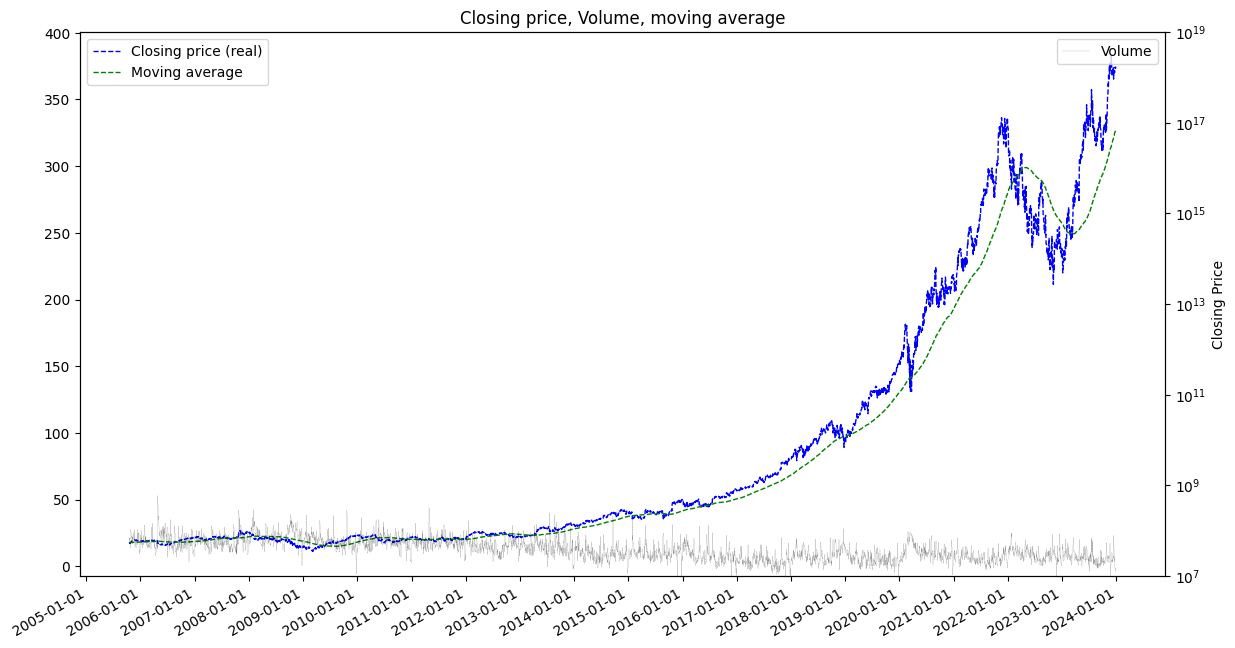

In [23]:
# show price development over whole time period

vol_dict = plt_set_dict_vol(data_in.loc[dict_offsets["first"]:, ["Date", "Volume"]])
avg_dict = plt_set_dict_avg(data_in.loc[dict_offsets["first"]:, ["Date", "MSFT-MV_AVG"]])
price_dict = plt_set_dict_price(
   data_in.loc[dict_offsets["first"]:, ["Date", "Close"]],
   label="Closing price (real)"
)

plt_graphs(
    price_dict,
    avg_dict,
    vol_dict,
    title="Closing price, Volume, moving average",
    #yscale="log"
    yscale="linear"
)

Enhance data

In [24]:
# Read data for reference index (S&P 500) for same period of time (downloaded from Yahoo Finance)
# and calculate VOL_CHG_Perc, CLOSE_CHG_Perc)

data_in_SP = load_data("SP500", DATA_PATH_SP500)
data_in_SP["Date"] = pd.to_datetime(data_in_SP["Date"].str.split(" ").str[0])

data_in_Gold = load_data("Gold", DATA_PATH_GOLD)
data_in_Gold["Date"] = pd.to_datetime(data_in_Gold["Date"].str.split(" ").str[0])

+++++ SP500 +++++
best chg of close:
                           Date         Open         High          Low  \
951   2008-10-13 00:00:00-04:00   912.750000  1006.929993   912.750000   
962   2008-10-28 00:00:00-04:00   848.919983   940.510010   845.270020   
3831  2020-03-24 00:00:00-04:00  2344.439941  2449.709961  2344.439941   
3824  2020-03-13 00:00:00-04:00  2569.989990  2711.330078  2492.370117   
1061  2009-03-23 00:00:00-04:00   772.309998   823.369995   772.309998   

            Close      Volume  Dividends  Stock Splits   CHG_Perc  \
951   1003.349976  7263370000        0.0           0.0  11.580037   
962    940.510010  7096950000        0.0           0.0  10.789006   
3831  2447.330078  7563150000        0.0           0.0   9.382774   
3824  2711.020020  8299070000        0.0           0.0   9.287125   
1061   822.919983  7715770000        0.0           0.0   7.075755   

      VOL_CHG_Perc  
951     -36.598951  
962      27.687768  
3831      2.047797  
3824     -6.233780 

In [25]:
# Read data about inflation (consumer price index), interest rates and GDP in US
data_in_rates = pd.read_csv(DATA_PATH_FRED_RATES)
# add last row with date in future (for comparison)
data_in_rates.loc[len(data_in_rates)] = ["2024-07-01", 0, 0]
# convert "Date", ignore timezone
data_in_rates["DATE"] = pd.to_datetime(data_in_rates["DATE"].str.split(" ").str[0])

data_in_gdp = pd.read_csv(DATA_PATH_GDP)
# add last row with date in future (for comparison)
data_in_gdp.loc[len(data_in_gdp)] = ["2024-07-01", 0]
# convert "Date", ignore timezone
data_in_gdp["DATE"] = pd.to_datetime(data_in_gdp["DATE"].str.split(" ").str[0])

# enhance stock data with interest rates
data_in["ITR"] = 0
data_in["ITR-CHG"] = 0
data_in["CPI"] = 0
data_in["CPI-CHG"] = 0
data_in["ITR-CPI"] = 0
data_in["GDP"] = 0
data_in["GDP-CHG"] = 0
data_in["GDP-TRD"] = 0
idx_rates = 0
idx_gdp = 0
gdp_trend = 0
last_gdp_chg = 0

# In order to calculate a value "ITR - CPI" the values have to be normalized before
# This is achieved by dividing all values by the first value
# Thus, both features will start with the same value (base_value)
base_value = 1
close_norm_itr = base_value * data_in_rates["FEDFUNDS"] / data_in_rates["FEDFUNDS"].iloc[0]
close_norm_cpi = base_value * data_in_rates["CPIAUCSL"] / data_in_rates["CPIAUCSL"].iloc[0]
close_norm_gdp = base_value * data_in_gdp["GDP"] / data_in_gdp["GDP"].iloc[0]

prev_itr_rate = data_in_rates.iloc[0]["FEDFUNDS"]
prev_cpi_rate = data_in_rates.iloc[0]["CPIAUCSL"]
prev_gdp_rate = data_in_gdp.iloc[0]["GDP"]

for idx in range(data_in.shape[0]-1):
    if (data_in.iloc[idx]["Date"] > data_in_rates.iloc[idx_rates+1]["DATE"]):
        idx_rates += 1
    if (data_in.iloc[idx]["Date"] > data_in_gdp.iloc[idx_gdp+1]["DATE"]):
        # calculate trends
        gdp_trend, gdp_chg = calc_trend(data_in_gdp, cur_idx=idx_gdp, field="GDP", last_chg=last_gdp_chg)
        print_debug(f"gdp_trend: {gdp_trend}, gdp_chg: {gdp_chg}")
        # there's a new value for GDP
        idx_gdp += 1
        last_gdp_chg = gdp_chg

    data_in.at[idx, "ITR"] = data_in_rates.iloc[idx_rates]["FEDFUNDS"]
    data_in.at[idx, "ITR-CHG"] = data_in.iloc[idx]["ITR"] - prev_itr_rate
    data_in.at[idx, "CPI"] = data_in_rates.iloc[idx_rates]["CPIAUCSL"]
    data_in.at[idx, "CPI-CHG"] = data_in.iloc[idx]["CPI"] - prev_cpi_rate
    data_in.at[idx, "ITR-CPI"] = close_norm_itr.iloc[idx_rates] - close_norm_cpi.iloc[idx_rates]
    data_in.at[idx, "GDP"] = data_in_gdp.iloc[idx_gdp]["GDP"]
    data_in.at[idx, "GDP-CHG"] = data_in.iloc[idx]["GDP"] - prev_gdp_rate
    data_in.at[idx, "GDP-TRD"] = gdp_trend

    prev_cpi_rate = data_in.iloc[idx]["CPI"]
    prev_itr_rate = data_in.iloc[idx]["ITR"]
    prev_gdp_rate = data_in.iloc[idx]["GDP"]

Visualize comparison with S&P500

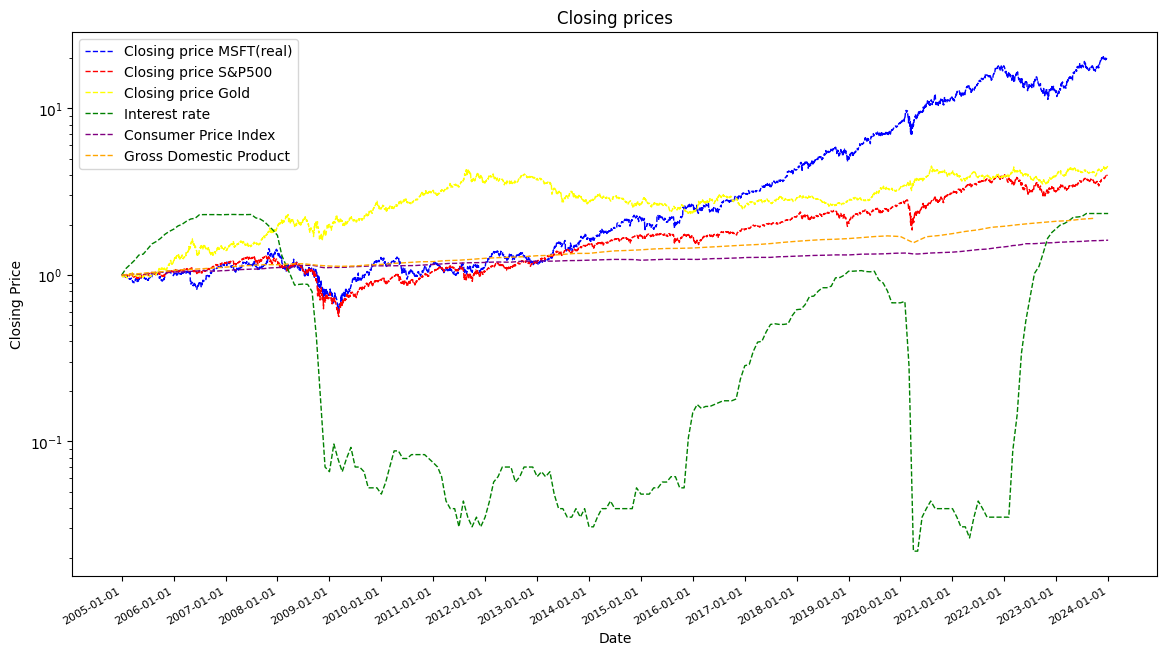

In [26]:
# +++ plot graph for comparison of MSFT & S&P 500 +++
# Normalization is necessary
# This is achieved by dividing all values by the first value
# Thus, both graphs will start with the same value (base_value)
base_value = 1

close_norm_stock = data_in[["Date", "Close"]].copy()
close_norm_stock["Close"] = base_value * close_norm_stock["Close"] / close_norm_stock["Close"].iloc[0]

close_norm_SP = data_in_SP[["Date", "Close"]].copy()
close_norm_SP["Close"] = base_value * close_norm_SP["Close"] / close_norm_SP["Close"].iloc[0]

close_norm_Gold = data_in_Gold[["Date", "Close"]].copy()
close_norm_Gold["Close"] = base_value * close_norm_Gold["Close"] / close_norm_Gold["Close"].iloc[0]

prt_norm_itr = pd.DataFrame(columns=["Date", "ITR"])
prt_norm_itr["ITR"] = data_in_rates["FEDFUNDS"]
prt_norm_itr["ITR"] = base_value * prt_norm_itr["ITR"] / prt_norm_itr["ITR"].iloc[0]
prt_norm_itr["Date"] = data_in_rates["DATE"]

prt_norm_cpi = pd.DataFrame(columns=["Date", "CPI"])
prt_norm_cpi["CPI"] = data_in_rates["CPIAUCSL"]
prt_norm_cpi["CPI"] = base_value * prt_norm_cpi["CPI"] / prt_norm_cpi["CPI"].iloc[0]
prt_norm_cpi["Date"] = data_in_rates["DATE"]

prt_norm_gdp = pd.DataFrame(columns=["Date", "GDP"])
prt_norm_gdp["GDP"] = data_in_gdp["GDP"]
prt_norm_gdp["GDP"] = base_value * prt_norm_gdp["GDP"] / prt_norm_gdp["GDP"].iloc[0]
prt_norm_gdp["Date"] = data_in_gdp["DATE"]

if DEBUG_MODE == True:
    print("prt_norm_gdp.shape:", prt_norm_gdp.shape)
    print("prt_norm_gdp\n:", prt_norm_gdp)
    print("data_in_gdp\n:", data_in_gdp)
    print("close_norm_stock.shape:", close_norm_stock.shape)

price_stock_dict = plt_set_dict_price(
    close_norm_stock, color="blue", label="Closing price MSFT(real)"
)
price_SP500_dict = plt_set_dict_price(
    close_norm_SP, color="red", label="Closing price S&P500"
)
price_Gold_dict = plt_set_dict_price(
    close_norm_Gold, color="yellow", label="Closing price Gold"
)

idx_itr_dict = plt_set_dict_price(
    prt_norm_itr, color="green", label="Interest rate"
)
idx_cpi_dict = plt_set_dict_price(
    prt_norm_cpi, color="purple", label="Consumer Price Index"
)
idx_gdp_dict = plt_set_dict_price(
    prt_norm_gdp, color="orange", label="Gross Domestic Product"
)

plt_graphs(
    price_stock_dict,
    price_SP500_dict,
    price_Gold_dict,
    idx_itr_dict,
    idx_cpi_dict,
    idx_gdp_dict,
    title="Closing prices",
    yscale="log",
)

Enhance data for training with information from Gold and S&P 500

In [27]:
def enhance_stock_data(data_dest, data_src, name):
    # !TBD! Add all columns for data_in at once (in the beginning)

    # Add columns with info about perc. changes in S&P 500 to dataset
    name_close = name + "-close"
    name_vol = name + "-volume"
    data_dest[name_close] = data_src["Close"]
    data_dest[name_vol] = data_src["Volume"]

    name_close_chg = name + "-CLOSE_CHG_Perc"
    name_vol_chg = name + "-VOL_CHG_Perc"

    data_dest[name_close_chg] = data_src["CHG_Perc"]
    data_dest[name_vol_chg] = data_src["VOL_CHG_Perc"]

    # add new column to store delta between MSFT changes and S&P changes
    name_close_outperf = name + "-CLOSE_Outperf"
    name_vol_outperf = name + "-VOL_Outperf"
    data_dest[name_close_outperf] = data_dest["MSFT-CHG_Perc"] - data_dest[name_close_chg]
    data_dest[name_vol_outperf] = data_dest["MSFT-VOL_CHG_Perc"] - data_dest[name_vol_chg]

    # show best and worst days for CLOSE_CHG_Perc, VOL_CHG_Perc:
    top_10 = data_dest.sort_values(by=name_close_outperf, ascending=False).head(10)
    worst_10 = data_dest.sort_values(by=name_close_outperf, ascending=True).head(10)

In [28]:
enhance_stock_data(data_in, data_in_SP, "SP500")
enhance_stock_data(data_in, data_in_Gold, "Gold")

**+++ PREPARATION FOR FEATURE SELECTION AND MODEL TRAINING +++**

In [29]:
# Set features for selection
features_all = list(data_in.columns)
features_all.remove("Date")
print_debug(f"All feature candidates:\n{features_all}")

# set features in data (drop last line: no prediction)
features = data_in.iloc[dict_offsets["first"]:-1][features_all]

# set target: target is moved ahead by 1: prediction is done for next day
target = data_in.iloc[dict_offsets["first"]+1 : ]["Close"]

# reshape necessary
closing_prices = target.values.reshape(-1, 1)

In [30]:
# Validate if target is correct (needs to be done before scaling)
for idx in range(target.size-1):
    if target.iloc[idx] != data_in.iloc[dict_offsets["Train"]["offset"]+idx+1]["Close"]:
        print("target seems wrong: ")
        print("   target[idx] : ", target[idx])
        print("   data_in[offset+idx+1] : ", data_in[dict_offsets["Train"].offset+idx+1])

Scaling of features

In [31]:
# +++ Scaling of features +++
# setting of feature range for scalings
# Observation: feature range (-1, 1) works as well but needs much more epochs for training!
feature_range = (0, 1)
# feature_range = (-1, 1)
# Scale all features for input
input_scaler = MinMaxScaler(feature_range=feature_range)
scaled_features = input_scaler.fit_transform(features)

# Scale closing prices for target
# I tested with and without scaling: it works much better with scaling of target!
# Note: separate scaler needed to descale later (for visualization)
target_scaler = MinMaxScaler(feature_range=feature_range)
scaled_closing_prices = target_scaler.fit_transform(closing_prices)

Split data into training, validation and test dataset

In [32]:
# Split data into training, validation, test

offset_data = dict_offsets["first"]

curDict = dict_offsets["Train"]
offset = curDict["offset"]-offset_data
last_idx = offset + curDict["len"]
train_data = scaled_features[offset: last_idx]
train_closing_prices = scaled_closing_prices[offset: last_idx]

curDict = dict_offsets["Eval"]
offset = curDict["offset"]-offset_data
last_idx = offset + curDict["len"]
eval_data = scaled_features[offset: last_idx]
eval_closing_prices = scaled_closing_prices[offset: last_idx]

curDict = dict_offsets["Test"]
offset = curDict["offset"]-offset_data
last_idx = offset + curDict["len"]

# omit last record: no prediction that can be checked
test_data = scaled_features[offset: last_idx-1]
test_closing_prices = scaled_closing_prices[offset: last_idx-1]

In [33]:
print(dict_offsets)

{'calc_avg': {'offset': 0, 'len': 200}, 'Train': {'offset': 200, 'len': 2932}, 'Eval': {'offset': 3132, 'len': 733}, 'Test': {'offset': 3865, 'len': 916}, 'first': 200, 'last': 4781}


**+++ FEATURE SELECTION +++**

Predictive Power Score (PPS) and Correlation coefficients

In [34]:
# Prepare data for PPS or CORR
if FEATURE_SEL == "PPS" or FEATURE_SEL == "CORR":
    # Convert scaled features to pandas dataframe
    # scaled_features_df = pd.DataFrame(scaled_features, columns=features_all)
    #scaled_test_data_df = pd.DataFrame(test_data, columns=features_all)
    scaled_train_data_df = pd.DataFrame(train_data, columns=features_all)
    # add scaled closing price
    # scaled_features_df["close_next_day"] = scaled_closing_prices
    scaled_train_data_df["close_next_day"] = train_closing_prices

if FEATURE_SEL == "PPS":
    # Generate the PPS matrix for the DataFrame
    # pps_matrix = pps.predictors(data_in, "close_next_day")
    pps_matrix = pps.predictors(scaled_train_data_df, "close_next_day")

    features_pps = pps_matrix.loc[pps_matrix["ppscore"] > LIMIT_PPS, "x"].tolist()
    print(f"Selected features with PPS (limit: {LIMIT_PPS}): {features_pps}")

    # Convert PPS matrix to a DataFrame for better visualization
    pps_df = pd.DataFrame(pps_matrix)

    print(pps_df)
    fn = DATA_PATH_RESULTS + "Features-PPS.csv"
    pps_df.to_csv(fn)
elif FEATURE_SEL == "CORR":
    corr_matrix = scaled_train_data_df.corr()

    print("Correlation coefficients:")
    corr_close_next_day = corr_matrix["close_next_day"].sort_values(ascending=False)
    print(corr_close_next_day)
    print_debug(corr_matrix)

    # drop feature "close_next_day"
    corr_close_next_day = corr_close_next_day.drop("close_next_day")
    # select features, dependant on setting of LIMIT_CORR
    features_corr = [
        key for key, value in corr_close_next_day.items() if abs(value) > LIMIT_CORR
    ]
    print(f"Selected features from correlation matrix:\n{features_corr}")
    # save correlation matrix in file
    fn = DATA_PATH_RESULTS + "Features-Corr.csv"
    corr_matrix.to_csv(fn, float_format="%.4f")

RFE: Recursive Feature Elimination (RFE) (with random forest):
- Start with whole set of features (with weights - determined how?)
- determine feature importance (how?)
- drop least important features

In [35]:
if FEATURE_SEL == "RFE":
    # Initialize the base model
    base_model = RandomForestRegressor()

    # Initialize RFE with the base model
    selector = RFE(base_model, n_features_to_select=NUM_FEATURES, step=1)
    selector = selector.fit(train_data, train_closing_prices.ravel())
    feature_importances = selector.estimator_.feature_importances_

    # Get the mask of selected features
    selected_features = selector.support_

    # Get names of selected features
    features_RFE = list(compress(features_all, selected_features))

    # Visualize feature importance determined
    importance_ranking = sorted(zip(features_RFE, feature_importances), key=lambda x: x[1], reverse=True)
    print("Importance ranking: ", importance_ranking)
    features, importances = zip(*importance_ranking)

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.barh(features, importances, color='skyblue')  # Horizontal bar chart
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance Ranking (RFE)')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.xscale('log')

    # Display the plot
    plt.show()

Set feature selection

In [36]:
# Set fix feature sets (other feature sets have been set above)
features_min = ["Close"]
features_msft = ["Open", "High", "Low", "Close", "Volume", "Dividends"]

if FEATURE_SEL == "RFE":
    features_sel = features_RFE
elif FEATURE_SEL == "CORR":
    features_sel = features_corr
elif FEATURE_SEL == "MIN":
    features_sel = features_min
elif FEATURE_SEL == "PPS":
    features_sel = features_pps
elif FEATURE_SEL == "ALL":
    features_sel = features_all
elif FEATURE_SEL == "MSFT":
    features_sel = features_msft
else:
    # set default
    features_sel = features_min

feature_mask = np.array( [feature in features_sel for feature in features_all])
print_debug("feature mask: \n", feature_mask)

# set data for training etc to selected features
train_data = train_data[:, feature_mask]
eval_data = eval_data[:, feature_mask]
test_data = test_data[:, feature_mask]

# write selected features to results dictionary
dict_results["features"] = features_sel
print_debug(dict_results)

**+++ PREPARATION FOR TRAINING +++**

Conversion to PyTorch tensors

In [37]:
"""
# Convert all required data (X and y for training and test) to PyTorch tensors (float usually needed for NN)
# For features, add sequence length dimension for batch_size (needed)
# Then, train_tensor and test_tensor have a shape of [number_of_samples, 1, number_of_features]
"""

# Convert features to PyTorch tensors
train_tensor = torch.FloatTensor(train_data).unsqueeze(1)
eval_tensor = torch.FloatTensor(eval_data).unsqueeze(1)
test_tensor = torch.FloatTensor(test_data).unsqueeze(1)

# Convert target prices to PyTorch tensors
train_closing_prices_tensor = torch.tensor(train_closing_prices).float()
eval_closing_prices_tensor = torch.tensor(eval_closing_prices).float()
test_closing_prices_tensor = torch.tensor(test_closing_prices).float()

**+++ OPTUNA HYPERPARAMETER OPTIMIZATION +++**

In [38]:
# Optuna function:
# - defines hyperparameters to be optimized, with value ranges
# - calls model

def objective(trial):
    opt_hyper_params = hyper_params
    opt_hyper_params["activation"] = trial.suggest_categorical("activation", ["ReLU", "Tanh"])
    opt_hyper_params["batch_size"] = trial.suggest_int("batch_size", 16, 512)
    opt_hyper_params["loss"] = trial.suggest_categorical("loss", ["HuberLoss", "MSELoss", "L1Loss"])
    opt_hyper_params["lr"] = (
        HYPER_PARAMS_FIX_LR
        if HYPER_PARAMS_FIX_LR != 0
        else trial.suggest_float("lr", 1e-6, 1e-1, log=True)
    )
    opt_hyper_params["max_norm"] = trial.suggest_float("max_norm", 0.1, 10)
    opt_hyper_params["num_epochs"] = (
        HYPER_PARAMS_FIX_NUM_EPOCHS
        if HYPER_PARAMS_FIX_NUM_EPOCHS != 0
        else trial.suggest_int("num_epochs", 100, 800)
    )
    opt_hyper_params["num_layers"] = trial.suggest_int("num_layers", HYPER_PARAMS_MIN_HL, 5)
    opt_hyper_params["num_units"] = trial.suggest_int("num_units", 10, 500)
    opt_hyper_params["optimizer"] = trial.suggest_categorical( "optimizer", ["Adam", "AdamW", "RMSprop", "SGD"])
    opt_hyper_params["weight_decay"] = trial.suggest_float("weight_decay", 1e-5, 0.5)

    # set dependant hyperparameters:
    if opt_hyper_params["loss"] == "HuberLoss":
        opt_hyper_params["Huber_delta"] = trial.suggest_float("Huber_delta", 0.01, 100)
    else:
        opt_hyper_params["Huber_delta"] = 0

    # Dropout rate cannot be used for last hidden layer
    if opt_hyper_params["num_layers"] > 1:
        opt_hyper_params["dropout"] = trial.suggest_float("dropout", 1e-6, 1e-1, log=True)
    else:
        opt_hyper_params["dropout"] = 0

    model, criterion, outputs, epoch_losses, _ = train_model(opt_hyper_params,
                                                             train_tensor,
                                                             train_closing_prices_tensor,
                                                            )
    results_eval, loss_eval, _ = eval_model(model,
                                            criterion,
                                            eval_tensor,
                                            eval_closing_prices_tensor
                                           )
    return loss_eval

In [39]:
# Execution of optimization
if HYPER_PARAMS_OPT == True:
    # Execution of optimization
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=HYPER_PARAMS_NUM_RUN)

    # get importance of hyperparameters
    importances = optuna.importance.get_param_importances(study)

    # set optimized parameters
    hyper_params.update(study.best_trial.params)
    print_debug("best hyperparams: \n", hyper_params)

[I 2024-04-07 23:02:42,145] A new study created in memory with name: no-name-7991df48-0b7d-4176-9bca-7106a9b49fe2


Epoch [50/num_epochs], Loss: 0.0021363445622329083
Epoch [100/num_epochs], Loss: 0.001981243123332711
Epoch [150/num_epochs], Loss: 0.0017668325793541346
Epoch [200/num_epochs], Loss: 0.0017031841400441611
Epoch [250/num_epochs], Loss: 0.0016215140482624217
Epoch [300/num_epochs], Loss: 0.0015802951481115695


[I 2024-04-07 23:03:00,892] Trial 0 finished with value: 0.04879250377416611 and parameters: {'activation': 'Tanh', 'batch_size': 169, 'loss': 'MSELoss', 'lr': 8.85596106026299e-06, 'max_norm': 9.636433320854277, 'num_epochs': 312, 'num_layers': 4, 'num_units': 150, 'optimizer': 'SGD', 'weight_decay': 0.026069500143521534, 'dropout': 0.08931330437646783}. Best is trial 0 with value: 0.04879250377416611.


Training, MAE:  0.03425237143205272
Validation, loss:  0.04879250377416611
Validation, MAE:  0.20583259
Epoch [50/num_epochs], Loss: 0.0005799219840506945
Epoch [100/num_epochs], Loss: 0.0005718236437436038
Epoch [150/num_epochs], Loss: 0.0014489219910400505
Epoch [200/num_epochs], Loss: 0.0014241249130767149
Epoch [250/num_epochs], Loss: 0.0005724134480260545
Epoch [300/num_epochs], Loss: 0.0013906197491451167
Epoch [350/num_epochs], Loss: 0.0005452658008127603
Epoch [400/num_epochs], Loss: 0.0010986607925992252
Epoch [450/num_epochs], Loss: 0.0011544935486098337
Epoch [500/num_epochs], Loss: 0.0006054383835968716
Epoch [550/num_epochs], Loss: 2.863103515572018
Epoch [600/num_epochs], Loss: 0.0007817352658700353
Epoch [650/num_epochs], Loss: 0.0008233833222119655
Epoch [700/num_epochs], Loss: 0.0008780853079062783


[I 2024-04-07 23:03:20,706] Trial 1 finished with value: 0.026518452912569046 and parameters: {'activation': 'ReLU', 'batch_size': 340, 'loss': 'HuberLoss', 'lr': 0.09864879484571723, 'max_norm': 4.1250519441360245, 'num_epochs': 713, 'num_layers': 4, 'num_units': 31, 'optimizer': 'Adam', 'weight_decay': 0.04582786511430277, 'Huber_delta': 26.722413564546752, 'dropout': 2.3548581503806152e-05}. Best is trial 1 with value: 0.026518452912569046.


Training, MAE:  0.035604314154220953
Validation, loss:  0.026518452912569046
Validation, MAE:  0.21601386
Epoch [50/num_epochs], Loss: 0.0005675375953918168
Epoch [100/num_epochs], Loss: 0.0005625044165450769
Epoch [150/num_epochs], Loss: 0.0005611407286778558
Epoch [200/num_epochs], Loss: 0.000560716061348406
Epoch [250/num_epochs], Loss: 0.0005605793618694103
Epoch [300/num_epochs], Loss: 0.0005605350318849863


[I 2024-04-07 23:04:12,580] Trial 2 finished with value: 0.027094511315226555 and parameters: {'activation': 'Tanh', 'batch_size': 491, 'loss': 'HuberLoss', 'lr': 0.013898034075408293, 'max_norm': 0.29517713145915137, 'num_epochs': 340, 'num_layers': 5, 'num_units': 500, 'optimizer': 'SGD', 'weight_decay': 0.04423076969444955, 'Huber_delta': 9.916929129001213, 'dropout': 2.058889097410598e-06}. Best is trial 1 with value: 0.026518452912569046.


Training, MAE:  0.02687981817871332
Validation, loss:  0.027094511315226555
Validation, MAE:  0.21866441
Epoch [50/num_epochs], Loss: 0.027823650918435305
Epoch [100/num_epochs], Loss: 0.027452440350316465
Epoch [150/num_epochs], Loss: 0.02725313138216734
Epoch [200/num_epochs], Loss: 0.02715593093307689
Epoch [250/num_epochs], Loss: 0.027118294150568545
Epoch [300/num_epochs], Loss: 0.027107798610813916
Epoch [350/num_epochs], Loss: 0.027120779443066567
Epoch [400/num_epochs], Loss: 0.027137013152241707
Epoch [450/num_epochs], Loss: 0.027154421957675368
Epoch [500/num_epochs], Loss: 0.027174128801561892
Epoch [550/num_epochs], Loss: 0.02718665963038802
Epoch [600/num_epochs], Loss: 0.027202285826206207


[I 2024-04-07 23:04:29,085] Trial 3 finished with value: 0.22939905524253845 and parameters: {'activation': 'ReLU', 'batch_size': 384, 'loss': 'L1Loss', 'lr': 0.0006086728530509398, 'max_norm': 2.6761602658032317, 'num_epochs': 645, 'num_layers': 1, 'num_units': 163, 'optimizer': 'SGD', 'weight_decay': 0.21720212881472237}. Best is trial 1 with value: 0.026518452912569046.


Training, MAE:  0.02720945980399847
Validation, loss:  0.22939905524253845
Validation, MAE:  0.22939906
Epoch [50/num_epochs], Loss: 0.027008648884172242
Epoch [100/num_epochs], Loss: 0.02672429415397346
Epoch [150/num_epochs], Loss: 0.026630616405357917
Epoch [200/num_epochs], Loss: 0.02660955782048404
Epoch [250/num_epochs], Loss: 0.026611992483958603
Epoch [300/num_epochs], Loss: 0.02663834087240199
Epoch [350/num_epochs], Loss: 0.02665755070435504
Epoch [400/num_epochs], Loss: 0.026676195130373042
Epoch [450/num_epochs], Loss: 0.026689435758938392
Epoch [500/num_epochs], Loss: 0.02668870269941787


[I 2024-04-07 23:06:13,949] Trial 4 finished with value: 0.2351037561893463 and parameters: {'activation': 'ReLU', 'batch_size': 203, 'loss': 'L1Loss', 'lr': 2.222509510533734e-05, 'max_norm': 0.9515057353555653, 'num_epochs': 520, 'num_layers': 5, 'num_units': 359, 'optimizer': 'Adam', 'weight_decay': 0.2532513195903028, 'dropout': 0.03849132798670134}. Best is trial 1 with value: 0.026518452912569046.


Training, MAE:  0.02668289413365225
Validation, loss:  0.2351037561893463
Validation, MAE:  0.23510376
Epoch [50/num_epochs], Loss: 0.0016420486538317207
Epoch [100/num_epochs], Loss: 0.0016420486538317207
Epoch [150/num_epochs], Loss: 0.0016420486538317207
Epoch [200/num_epochs], Loss: 0.0016420486538317207
Epoch [250/num_epochs], Loss: 0.0016420486538317207
Epoch [300/num_epochs], Loss: 0.0016420486538317207


[I 2024-04-07 23:06:26,058] Trial 5 finished with value: 0.04726412519812584 and parameters: {'activation': 'ReLU', 'batch_size': 145, 'loss': 'MSELoss', 'lr': 0.017611569833233448, 'max_norm': 3.812698352383338, 'num_epochs': 328, 'num_layers': 4, 'num_units': 32, 'optimizer': 'SGD', 'weight_decay': 0.1998234153728893, 'dropout': 0.004956433603884469}. Best is trial 1 with value: 0.026518452912569046.


Training, MAE:  0.03366658611533543
Validation, loss:  0.04726412519812584
Validation, MAE:  0.2022108
Epoch [50/num_epochs], Loss: 0.0013687950530051499
Epoch [100/num_epochs], Loss: 0.001242208569476047
Epoch [150/num_epochs], Loss: 0.0012389237719313921
Epoch [200/num_epochs], Loss: 0.001292871475708948
Epoch [250/num_epochs], Loss: 0.0013835675392567196
Epoch [300/num_epochs], Loss: 0.0014533303121121814
Epoch [350/num_epochs], Loss: 0.0014294031371729857
Epoch [400/num_epochs], Loss: 0.001332649155572307


[I 2024-04-07 23:08:25,546] Trial 6 finished with value: 0.060501161962747574 and parameters: {'activation': 'Tanh', 'batch_size': 70, 'loss': 'MSELoss', 'lr': 4.477411864610054e-06, 'max_norm': 0.1779193002911837, 'num_epochs': 407, 'num_layers': 4, 'num_units': 310, 'optimizer': 'Adam', 'weight_decay': 0.12260110534928262, 'dropout': 0.008366344763054357}. Best is trial 1 with value: 0.026518452912569046.


Training, MAE:  0.023689862579062936
Validation, loss:  0.060501161962747574
Validation, MAE:  0.23265049
Epoch [50/num_epochs], Loss: 0.024931216440366014
Epoch [100/num_epochs], Loss: 0.024862227030098438
Epoch [150/num_epochs], Loss: 0.024941993786184037
Epoch [200/num_epochs], Loss: 0.024913211798538334
Epoch [250/num_epochs], Loss: 0.024869571996690785
Epoch [300/num_epochs], Loss: 0.02482656576751691
Epoch [350/num_epochs], Loss: 0.024792219056626378
Epoch [400/num_epochs], Loss: 0.0247855920182622
Epoch [450/num_epochs], Loss: 0.024777030430572188
Epoch [500/num_epochs], Loss: 0.02475771638969688
Epoch [550/num_epochs], Loss: 0.024763383892486276
Epoch [600/num_epochs], Loss: 0.02474035218398532
Epoch [650/num_epochs], Loss: 0.024725560756886134
Epoch [700/num_epochs], Loss: 0.024733683985212574


[I 2024-04-07 23:11:00,124] Trial 7 finished with value: 0.23079538345336914 and parameters: {'activation': 'ReLU', 'batch_size': 129, 'loss': 'L1Loss', 'lr': 4.9369681573387255e-05, 'max_norm': 7.262574537378735, 'num_epochs': 726, 'num_layers': 4, 'num_units': 373, 'optimizer': 'SGD', 'weight_decay': 0.08265553623514751, 'dropout': 0.011411310870530024}. Best is trial 1 with value: 0.026518452912569046.


Training, MAE:  0.024730924699131563
Validation, loss:  0.23079538345336914
Validation, MAE:  0.23079538
Epoch [50/num_epochs], Loss: 0.002996174562819457
Epoch [100/num_epochs], Loss: 0.0009239771506044134
Epoch [150/num_epochs], Loss: 0.000642102055684922


[I 2024-04-07 23:11:03,567] Trial 8 finished with value: 0.023793289437890053 and parameters: {'activation': 'ReLU', 'batch_size': 342, 'loss': 'HuberLoss', 'lr': 7.964360444095874e-06, 'max_norm': 6.357616151789775, 'num_epochs': 164, 'num_layers': 2, 'num_units': 33, 'optimizer': 'AdamW', 'weight_decay': 0.4031273852510165, 'Huber_delta': 40.55430890940524, 'dropout': 6.212417725799591e-05}. Best is trial 8 with value: 0.023793289437890053.


Training, MAE:  0.030841192230582237
Validation, loss:  0.023793289437890053
Validation, MAE:  0.20391254
Epoch [50/num_epochs], Loss: 0.027439691708423197
Epoch [100/num_epochs], Loss: 0.027431842579972


[I 2024-04-07 23:11:12,739] Trial 9 finished with value: 0.23214229941368103 and parameters: {'activation': 'Tanh', 'batch_size': 388, 'loss': 'L1Loss', 'lr': 0.0007998592759616895, 'max_norm': 6.419080748697834, 'num_epochs': 143, 'num_layers': 4, 'num_units': 151, 'optimizer': 'Adam', 'weight_decay': 0.4613491476860318, 'dropout': 0.0010360564982191385}. Best is trial 8 with value: 0.023793289437890053.


Training, MAE:  0.027431691880337894
Validation, loss:  0.23214229941368103
Validation, MAE:  0.23214233
Epoch [50/num_epochs], Loss: 0.005166298995556479
Epoch [100/num_epochs], Loss: 0.003769777773413807


[I 2024-04-07 23:11:16,657] Trial 10 finished with value: 0.042168330401182175 and parameters: {'activation': 'ReLU', 'batch_size': 289, 'loss': 'HuberLoss', 'lr': 1.4132139247905318e-06, 'max_norm': 9.01954895439536, 'num_epochs': 120, 'num_layers': 1, 'num_units': 203, 'optimizer': 'AdamW', 'weight_decay': 0.44779671361133333, 'Huber_delta': 77.338852353829}. Best is trial 8 with value: 0.023793289437890053.


Training, MAE:  0.07092460211027753
Validation, loss:  0.042168330401182175
Validation, MAE:  0.27941558
Epoch [50/num_epochs], Loss: 0.0013400949377682992
Epoch [100/num_epochs], Loss: 0.0015484633011510595
Epoch [150/num_epochs], Loss: 0.001790363718464505
Epoch [200/num_epochs], Loss: 0.0018340436270591453
Epoch [250/num_epochs], Loss: 0.005787667879485525
Epoch [300/num_epochs], Loss: 0.013981269965006505
Epoch [350/num_epochs], Loss: 0.0013397311951848679
Epoch [400/num_epochs], Loss: 0.0014597858942579478
Epoch [450/num_epochs], Loss: 0.0015545582355116494
Epoch [500/num_epochs], Loss: 0.004158626162461587
Epoch [550/num_epochs], Loss: 0.0023073852746165356


[I 2024-04-07 23:11:27,841] Trial 11 finished with value: 0.014087224379181862 and parameters: {'activation': 'ReLU', 'batch_size': 317, 'loss': 'HuberLoss', 'lr': 0.08500757854563008, 'max_norm': 5.244724527904756, 'num_epochs': 563, 'num_layers': 2, 'num_units': 15, 'optimizer': 'AdamW', 'weight_decay': 0.3246788974851078, 'Huber_delta': 33.06347079463195, 'dropout': 2.1479017145652806e-05}. Best is trial 11 with value: 0.014087224379181862.


Training, MAE:  0.051837144419550896
Validation, loss:  0.014087224379181862
Validation, MAE:  0.14576606
Epoch [50/num_epochs], Loss: 0.0014281421335908817
Epoch [100/num_epochs], Loss: 0.0007891896010343251
Epoch [150/num_epochs], Loss: 0.0007778940957255795
Epoch [200/num_epochs], Loss: 0.000764171161530872
Epoch [250/num_epochs], Loss: 0.0007495988705029179
Epoch [300/num_epochs], Loss: 0.000733709305807549
Epoch [350/num_epochs], Loss: 0.0007178658914719043
Epoch [400/num_epochs], Loss: 0.0006994187278905883
Epoch [450/num_epochs], Loss: 0.0006811615728240992
Epoch [500/num_epochs], Loss: 0.000662099478566753
Epoch [550/num_epochs], Loss: 0.0006423451704904437


[I 2024-04-07 23:11:37,979] Trial 12 finished with value: 0.017261136323213577 and parameters: {'activation': 'ReLU', 'batch_size': 475, 'loss': 'HuberLoss', 'lr': 8.538129442143775e-05, 'max_norm': 6.118121583544465, 'num_epochs': 585, 'num_layers': 2, 'num_units': 10, 'optimizer': 'AdamW', 'weight_decay': 0.34993553403137484, 'Huber_delta': 48.63442116447548, 'dropout': 5.7063063195992654e-05}. Best is trial 11 with value: 0.014087224379181862.


Training, MAE:  0.030632983094879558
Validation, loss:  0.017261136323213577
Validation, MAE:  0.1732756
Epoch [50/num_epochs], Loss: 0.0007524462676623703
Epoch [100/num_epochs], Loss: 0.0005509590721755688
Epoch [150/num_epochs], Loss: 0.0003246680233652504
Epoch [200/num_epochs], Loss: 0.00013148811376595404
Epoch [250/num_epochs], Loss: 3.112445574515732e-05
Epoch [300/num_epochs], Loss: 5.331660206918189e-06
Epoch [350/num_epochs], Loss: 1.6932275294883375e-06
Epoch [400/num_epochs], Loss: 1.165225902306182e-06
Epoch [450/num_epochs], Loss: 1.0081471941703057e-06
Epoch [500/num_epochs], Loss: 9.273299415976258e-07
Epoch [550/num_epochs], Loss: 8.711719934646161e-07


[I 2024-04-07 23:11:55,271] Trial 13 finished with value: 2.6115621949429624e-05 and parameters: {'activation': 'ReLU', 'batch_size': 466, 'loss': 'HuberLoss', 'lr': 0.0001289251310815906, 'max_norm': 5.430018610045096, 'num_epochs': 574, 'num_layers': 2, 'num_units': 98, 'optimizer': 'AdamW', 'weight_decay': 0.34873252820823164, 'Huber_delta': 62.544783110974386, 'dropout': 1.2891654288617168e-05}. Best is trial 13 with value: 2.6115621949429624e-05.


Training, MAE:  0.0009026550521541919
Validation, loss:  2.6115621949429624e-05
Validation, MAE:  0.004623115
Epoch [50/num_epochs], Loss: 0.0007023986940371937
Epoch [100/num_epochs], Loss: 0.0006997798648496557
Epoch [150/num_epochs], Loss: 0.0006998406799019514
Epoch [200/num_epochs], Loss: 0.0006998035366580423
Epoch [250/num_epochs], Loss: 0.0006998021464304267
Epoch [300/num_epochs], Loss: 0.0006998109991919981
Epoch [350/num_epochs], Loss: 0.0006998199049641178
Epoch [400/num_epochs], Loss: 0.0006998260952449138
Epoch [450/num_epochs], Loss: 0.0006998296916468202


[I 2024-04-07 23:12:09,246] Trial 14 finished with value: 0.02784060500562191 and parameters: {'activation': 'ReLU', 'batch_size': 432, 'loss': 'HuberLoss', 'lr': 0.003098577968072259, 'max_norm': 5.1530362812588635, 'num_epochs': 503, 'num_layers': 2, 'num_units': 90, 'optimizer': 'RMSprop', 'weight_decay': 0.31097265283955255, 'Huber_delta': 77.18703185939046, 'dropout': 2.1959078375995633e-06}. Best is trial 13 with value: 2.6115621949429624e-05.


Epoch [500/num_epochs], Loss: 0.0006998315678044621
Training, MAE:  0.02737901220098138
Validation, loss:  0.02784060500562191
Validation, MAE:  0.22205019
Epoch [50/num_epochs], Loss: 2.024063639265268e-05
Epoch [100/num_epochs], Loss: 9.573715654089308e-07
Epoch [150/num_epochs], Loss: 3.2006733835469975e-05
Epoch [200/num_epochs], Loss: 1.5272069005662231e-06
Epoch [250/num_epochs], Loss: 4.304205101736723e-06
Epoch [300/num_epochs], Loss: 4.51347865639316e-05
Epoch [350/num_epochs], Loss: 1.8823662934699733e-05
Epoch [400/num_epochs], Loss: 8.836611464875414e-05
Epoch [450/num_epochs], Loss: 1.3081760987286264e-06
Epoch [500/num_epochs], Loss: 4.441104258909525e-06
Epoch [550/num_epochs], Loss: 1.3316392430449644e-06
Epoch [600/num_epochs], Loss: 8.460839725243064e-07


[I 2024-04-07 23:12:34,709] Trial 15 finished with value: 2.208907244494185e-05 and parameters: {'activation': 'ReLU', 'batch_size': 243, 'loss': 'HuberLoss', 'lr': 0.00016805101769930752, 'max_norm': 8.034673392660157, 'num_epochs': 615, 'num_layers': 3, 'num_units': 93, 'optimizer': 'AdamW', 'weight_decay': 0.3369713363001353, 'Huber_delta': 63.38771766745733, 'dropout': 9.31061558230724e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.0017987080276585543
Validation, loss:  2.208907244494185e-05
Validation, MAE:  0.0039032884
Epoch [50/num_epochs], Loss: 1.78866776842859e-06
Epoch [100/num_epochs], Loss: 6.949826408449902e-05
Epoch [150/num_epochs], Loss: 4.157701666302343e-06
Epoch [200/num_epochs], Loss: 8.19566476086318e-06
Epoch [250/num_epochs], Loss: 1.9986166884896542e-05
Epoch [300/num_epochs], Loss: 1.1806759105708737e-05
Epoch [350/num_epochs], Loss: 8.458242676239864e-06
Epoch [400/num_epochs], Loss: 7.506357714139365e-06
Epoch [450/num_epochs], Loss: 7.076702246422428e-06
Epoch [500/num_epochs], Loss: 6.619670714896459e-06
Epoch [550/num_epochs], Loss: 6.157958304916415e-06
Epoch [600/num_epochs], Loss: 5.590588314747108e-06
Epoch [650/num_epochs], Loss: 5.312903073655224e-06
Epoch [700/num_epochs], Loss: 4.963981684096115e-06
Epoch [750/num_epochs], Loss: 4.683911562061929e-06


[I 2024-04-07 23:13:48,559] Trial 16 finished with value: 2.6179022825090215e-05 and parameters: {'activation': 'ReLU', 'batch_size': 227, 'loss': 'HuberLoss', 'lr': 0.00015324769743298253, 'max_norm': 8.408395713193295, 'num_epochs': 798, 'num_layers': 3, 'num_units': 243, 'optimizer': 'AdamW', 'weight_decay': 0.4998871789952598, 'Huber_delta': 97.86492669178455, 'dropout': 9.412414321428414e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.002612680648990835
Validation, loss:  2.6179022825090215e-05
Validation, MAE:  0.0044964375
Epoch [50/num_epochs], Loss: 0.000577798767682915
Epoch [100/num_epochs], Loss: 0.0005777948976232716
Epoch [150/num_epochs], Loss: 0.000577794599911944
Epoch [200/num_epochs], Loss: 0.0005777922486948167
Epoch [250/num_epochs], Loss: 0.0005777984480614065
Epoch [300/num_epochs], Loss: 0.0005777937316686427
Epoch [350/num_epochs], Loss: 0.0005777947783523073
Epoch [400/num_epochs], Loss: 0.0005777951264203325
Epoch [450/num_epochs], Loss: 0.0005777939531393098
Epoch [500/num_epochs], Loss: 0.0005777977264281255
Epoch [550/num_epochs], Loss: 0.0005777979608429919
Epoch [600/num_epochs], Loss: 0.0005777997051314358


[I 2024-04-07 23:16:30,364] Trial 17 finished with value: 0.026184264570474625 and parameters: {'activation': 'ReLU', 'batch_size': 17, 'loss': 'HuberLoss', 'lr': 0.0002880026606553796, 'max_norm': 7.609884960818539, 'num_epochs': 632, 'num_layers': 3, 'num_units': 111, 'optimizer': 'RMSprop', 'weight_decay': 0.36087768632350603, 'Huber_delta': 67.0779539083006, 'dropout': 0.0002697437850907372}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.02543203091629743
Validation, loss:  0.026184264570474625
Validation, MAE:  0.21446122
Epoch [50/num_epochs], Loss: 5.2467973716829874e-06
Epoch [100/num_epochs], Loss: 1.0127417837679786e-06
Epoch [150/num_epochs], Loss: 1.6775399937311402e-06
Epoch [200/num_epochs], Loss: 1.0289525675943878e-06
Epoch [250/num_epochs], Loss: 4.039071214378964e-06
Epoch [300/num_epochs], Loss: 6.860622861874315e-05
Epoch [350/num_epochs], Loss: 1.7828166294956798e-05
Epoch [400/num_epochs], Loss: 3.5571339206323195e-05


[I 2024-04-07 23:16:48,020] Trial 18 finished with value: 8.857856300892308e-05 and parameters: {'activation': 'Tanh', 'batch_size': 255, 'loss': 'HuberLoss', 'lr': 0.000979885720423754, 'max_norm': 7.88868196257451, 'num_epochs': 437, 'num_layers': 3, 'num_units': 99, 'optimizer': 'AdamW', 'weight_decay': 0.2739625432815752, 'Huber_delta': 60.91378364739927, 'dropout': 1.1315627036012858e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.006091304259219517
Validation, loss:  8.857856300892308e-05
Validation, MAE:  0.007946912
Epoch [50/num_epochs], Loss: 0.00021299102419496712
Epoch [100/num_epochs], Loss: 6.96346651888494e-05
Epoch [150/num_epochs], Loss: 5.0858570245639256e-05
Epoch [200/num_epochs], Loss: 2.6489843191614326e-05
Epoch [250/num_epochs], Loss: 0.00015553741026711317
Epoch [300/num_epochs], Loss: 0.00013504965867079072
Epoch [350/num_epochs], Loss: 9.621145610643518e-05
Epoch [400/num_epochs], Loss: 5.692789943623211e-05
Epoch [450/num_epochs], Loss: 6.251655668165768e-05
Epoch [500/num_epochs], Loss: 0.0006433740041497263
Epoch [550/num_epochs], Loss: 1.596703936814135e-06
Epoch [600/num_epochs], Loss: 1.5748609355016794e-06
Epoch [650/num_epochs], Loss: 3.2650655482159763e-06


[I 2024-04-07 23:17:33,077] Trial 19 finished with value: 0.0017052392940968275 and parameters: {'activation': 'ReLU', 'batch_size': 430, 'loss': 'MSELoss', 'lr': 0.0026783585403352414, 'max_norm': 9.962655737090937, 'num_epochs': 681, 'num_layers': 3, 'num_units': 242, 'optimizer': 'AdamW', 'weight_decay': 0.1584705416196574, 'dropout': 0.0002364416647127886}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.006104702940709623
Validation, loss:  0.0017052392940968275
Validation, MAE:  0.034700993
Epoch [50/num_epochs], Loss: 0.0005475754339634229
Epoch [100/num_epochs], Loss: 0.0004857361008444886
Epoch [150/num_epochs], Loss: 0.00042832412063117687
Epoch [200/num_epochs], Loss: 0.0003744438877633498
Epoch [250/num_epochs], Loss: 0.000323545928536491
Epoch [300/num_epochs], Loss: 0.0002753490693562939
Epoch [350/num_epochs], Loss: 0.00022979295268173288
Epoch [400/num_epochs], Loss: 0.0001870273125115835
Epoch [450/num_epochs], Loss: 0.00014740162127550732
Epoch [500/num_epochs], Loss: 0.00011149218120077752
Epoch [550/num_epochs], Loss: 8.006145547121626e-05
Epoch [600/num_epochs], Loss: 5.385467381364089e-05
Epoch [650/num_epochs], Loss: 3.337928203770637e-05
Epoch [700/num_epochs], Loss: 1.8715007885558325e-05
Epoch [750/num_epochs], Loss: 9.367541689574534e-06


[I 2024-04-07 23:17:57,974] Trial 20 finished with value: 0.00031004275660961866 and parameters: {'activation': 'ReLU', 'batch_size': 271, 'loss': 'HuberLoss', 'lr': 3.818328698838863e-05, 'max_norm': 2.980126389819719, 'num_epochs': 766, 'num_layers': 1, 'num_units': 189, 'optimizer': 'AdamW', 'weight_decay': 0.3926215602436504, 'Huber_delta': 94.08444514144534}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.0031073816353455186
Validation, loss:  0.00031004275660961866
Validation, MAE:  0.022675078
Epoch [50/num_epochs], Loss: 9.383462213463645e-06
Epoch [100/num_epochs], Loss: 8.735214964060236e-07
Epoch [150/num_epochs], Loss: 4.217510872146184e-05
Epoch [200/num_epochs], Loss: 5.901567762732286e-06
Epoch [250/num_epochs], Loss: 5.425638751229858e-06
Epoch [300/num_epochs], Loss: 6.700520655402085e-06
Epoch [350/num_epochs], Loss: 7.868688738556426e-06
Epoch [400/num_epochs], Loss: 7.823652379914034e-06
Epoch [450/num_epochs], Loss: 7.204048736347042e-06
Epoch [500/num_epochs], Loss: 6.625440868950656e-06
Epoch [550/num_epochs], Loss: 2.237041448844528e-06
Epoch [600/num_epochs], Loss: 5.0263551258922234e-06
Epoch [650/num_epochs], Loss: 3.9296125139896636e-06
Epoch [700/num_epochs], Loss: 1.9113348222228003e-06
Epoch [750/num_epochs], Loss: 1.9462092422730038e-06


[I 2024-04-07 23:19:18,132] Trial 21 finished with value: 3.5939650842919946e-05 and parameters: {'activation': 'ReLU', 'batch_size': 224, 'loss': 'HuberLoss', 'lr': 0.00014234799496800024, 'max_norm': 8.848345829846995, 'num_epochs': 780, 'num_layers': 3, 'num_units': 288, 'optimizer': 'AdamW', 'weight_decay': 0.4956792997816538, 'Huber_delta': 99.28347365042336, 'dropout': 9.220545750942276e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.0018384247128519096
Validation, loss:  3.5939650842919946e-05
Validation, MAE:  0.00561254
Epoch [50/num_epochs], Loss: 1.1076321176991164e-06
Epoch [100/num_epochs], Loss: 7.618668629068755e-06
Epoch [150/num_epochs], Loss: 1.4778232988040448e-05
Epoch [200/num_epochs], Loss: 1.0169655411118583e-05
Epoch [250/num_epochs], Loss: 1.1726514298970869e-05
Epoch [300/num_epochs], Loss: 7.925207470786215e-06
Epoch [350/num_epochs], Loss: 7.779277128368752e-06
Epoch [400/num_epochs], Loss: 7.380505523239359e-06
Epoch [450/num_epochs], Loss: 6.594413457605697e-06
Epoch [500/num_epochs], Loss: 6.1123235506480945e-06
Epoch [550/num_epochs], Loss: 5.794772998039359e-06
Epoch [600/num_epochs], Loss: 5.476897702768231e-06


[I 2024-04-07 23:20:00,879] Trial 22 finished with value: 2.5103181542363018e-05 and parameters: {'activation': 'ReLU', 'batch_size': 199, 'loss': 'HuberLoss', 'lr': 0.00020327047049068346, 'max_norm': 7.7537548014676165, 'num_epochs': 607, 'num_layers': 2, 'num_units': 227, 'optimizer': 'AdamW', 'weight_decay': 0.4171964615299875, 'Huber_delta': 82.2503877474404, 'dropout': 5.3685052459999976e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.0028501525909329453
Validation, loss:  2.5103181542363018e-05
Validation, MAE:  0.0043872767
Epoch [50/num_epochs], Loss: 3.634049683872339e-05
Epoch [100/num_epochs], Loss: 3.2156017781896176e-05
Epoch [150/num_epochs], Loss: 3.1914023717642216e-05
Epoch [200/num_epochs], Loss: 1.4153026849802094e-05
Epoch [250/num_epochs], Loss: 7.614790627978133e-07
Epoch [300/num_epochs], Loss: 7.73498672401729e-07
Epoch [350/num_epochs], Loss: 9.435581337887318e-07
Epoch [400/num_epochs], Loss: 1.534465487414612e-06
Epoch [450/num_epochs], Loss: 1.69708681217647e-06
Epoch [500/num_epochs], Loss: 1.576657256426491e-06
Epoch [550/num_epochs], Loss: 1.7914869147261926e-06


[I 2024-04-07 23:20:31,699] Trial 23 finished with value: 2.7316575142322108e-05 and parameters: {'activation': 'ReLU', 'batch_size': 99, 'loss': 'HuberLoss', 'lr': 0.0003562894466778707, 'max_norm': 6.970107626378486, 'num_epochs': 601, 'num_layers': 2, 'num_units': 97, 'optimizer': 'AdamW', 'weight_decay': 0.4115131260749229, 'Huber_delta': 63.88932503005266, 'dropout': 5.428046129685061e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Epoch [600/num_epochs], Loss: 1.9000339174605567e-06
Training, MAE:  0.0015703225469527145
Validation, loss:  2.7316575142322108e-05
Validation, MAE:  0.004631775
Epoch [50/num_epochs], Loss: 0.003714037924510194
Epoch [100/num_epochs], Loss: 0.0025898161075019743
Epoch [150/num_epochs], Loss: 0.0020647221708713914
Epoch [200/num_epochs], Loss: 0.001679590070125414
Epoch [250/num_epochs], Loss: 0.0013405764165668188
Epoch [300/num_epochs], Loss: 0.001020145001717765
Epoch [350/num_epochs], Loss: 0.0008173923993979315
Epoch [400/num_epochs], Loss: 0.0007265230497068842
Epoch [450/num_epochs], Loss: 0.0006879902205128019
Epoch [500/num_epochs], Loss: 0.0006709197049019622


[I 2024-04-07 23:20:48,343] Trial 24 finished with value: 0.029072819277644157 and parameters: {'activation': 'ReLU', 'batch_size': 187, 'loss': 'HuberLoss', 'lr': 2.260765615273924e-05, 'max_norm': 5.756347292240228, 'num_epochs': 530, 'num_layers': 2, 'num_units': 71, 'optimizer': 'RMSprop', 'weight_decay': 0.2917580751047386, 'Huber_delta': 78.96132975613158, 'dropout': 6.796950476959892e-05}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.02549155306769535
Validation, loss:  0.029072819277644157
Validation, MAE:  0.22753182
Epoch [50/num_epochs], Loss: 5.7870876882285906e-05
Epoch [100/num_epochs], Loss: 7.603563763799078e-07
Epoch [150/num_epochs], Loss: 1.3774341065679133e-05
Epoch [200/num_epochs], Loss: 1.1094558705811626e-06
Epoch [250/num_epochs], Loss: 5.9205770469361596e-05
Epoch [300/num_epochs], Loss: 5.491500773284012e-05
Epoch [350/num_epochs], Loss: 7.82461006660166e-05
Epoch [400/num_epochs], Loss: 1.7879347131118568e-05
Epoch [450/num_epochs], Loss: 1.5259458929032614e-06


[I 2024-04-07 23:21:12,295] Trial 25 finished with value: 3.7776750104967505e-05 and parameters: {'activation': 'ReLU', 'batch_size': 249, 'loss': 'HuberLoss', 'lr': 0.0023011369846379424, 'max_norm': 4.246699048842127, 'num_epochs': 470, 'num_layers': 1, 'num_units': 474, 'optimizer': 'AdamW', 'weight_decay': 0.3593173702193519, 'Huber_delta': 49.62850688388008}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.004668071225751191
Validation, loss:  3.7776750104967505e-05
Validation, MAE:  0.0059068375
Epoch [50/num_epochs], Loss: 8.651252386471242e-07
Epoch [100/num_epochs], Loss: 3.724416035311151e-06
Epoch [150/num_epochs], Loss: 7.6744414627683e-07
Epoch [200/num_epochs], Loss: 2.0161029527798747e-05
Epoch [250/num_epochs], Loss: 2.775395506660061e-06
Epoch [300/num_epochs], Loss: 1.7166838603088764e-06
Epoch [350/num_epochs], Loss: 1.1176938934909231e-05
Epoch [400/num_epochs], Loss: 1.0153665897405517e-05
Epoch [450/num_epochs], Loss: 5.596948710717697e-06
Epoch [500/num_epochs], Loss: 3.841201134946459e-06
Epoch [550/num_epochs], Loss: 3.1243581048556733e-06
Epoch [600/num_epochs], Loss: 2.8587333673613102e-06
Epoch [650/num_epochs], Loss: 2.754714566322036e-06


[I 2024-04-07 23:22:00,635] Trial 26 finished with value: 2.3905286070657894e-05 and parameters: {'activation': 'Tanh', 'batch_size': 302, 'loss': 'HuberLoss', 'lr': 0.00017370606142885477, 'max_norm': 8.048621249862888, 'num_epochs': 660, 'num_layers': 3, 'num_units': 205, 'optimizer': 'AdamW', 'weight_decay': 0.4390561606379546, 'Huber_delta': 85.64073439710319, 'dropout': 5.99877684933224e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.00298625752911903
Validation, loss:  2.3905286070657894e-05
Validation, MAE:  0.0042889616
Epoch [50/num_epochs], Loss: 1.5115718639435727e-05
Epoch [100/num_epochs], Loss: 3.6130872331341378e-06
Epoch [150/num_epochs], Loss: 1.3483251336765535e-06
Epoch [200/num_epochs], Loss: 1.0347446249170388e-06
Epoch [250/num_epochs], Loss: 1.2184240603119179e-06
Epoch [300/num_epochs], Loss: 1.6888263843384265e-06
Epoch [350/num_epochs], Loss: 1.947829295545489e-06
Epoch [400/num_epochs], Loss: 1.856168188396623e-06
Epoch [450/num_epochs], Loss: 1.8057140209748468e-06
Epoch [500/num_epochs], Loss: 9.021821307442224e-06
Epoch [550/num_epochs], Loss: 8.114565702044274e-07
Epoch [600/num_epochs], Loss: 3.277339305896021e-05
Epoch [650/num_epochs], Loss: 1.2494855099021152e-05


[I 2024-04-07 23:22:50,102] Trial 27 finished with value: 2.8909238608321175e-05 and parameters: {'activation': 'Tanh', 'batch_size': 306, 'loss': 'HuberLoss', 'lr': 0.00034007902210373076, 'max_norm': 8.111306155806684, 'num_epochs': 668, 'num_layers': 3, 'num_units': 209, 'optimizer': 'AdamW', 'weight_decay': 0.43122578039313064, 'Huber_delta': 87.78842980480533, 'dropout': 2.368497992089531e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.0029237080307211727
Validation, loss:  2.8909238608321175e-05
Validation, MAE:  0.0048512756
Epoch [50/num_epochs], Loss: 0.018454942398851638
Epoch [100/num_epochs], Loss: 0.0009449411177468535
Epoch [150/num_epochs], Loss: 0.0009187303719380381
Epoch [200/num_epochs], Loss: 0.0012248019767483991
Epoch [250/num_epochs], Loss: 0.0009720727102831006
Epoch [300/num_epochs], Loss: 0.0012969606139354016
Epoch [350/num_epochs], Loss: 0.0009527407666227143
Epoch [400/num_epochs], Loss: 0.0009345649557776357
Epoch [450/num_epochs], Loss: 0.0010849300888366997
Epoch [500/num_epochs], Loss: 0.001194602344185114
Epoch [550/num_epochs], Loss: 0.000971334033621181
Epoch [600/num_epochs], Loss: 0.00097422180452237


[I 2024-04-07 23:24:11,259] Trial 28 finished with value: 0.004190533887594938 and parameters: {'activation': 'Tanh', 'batch_size': 161, 'loss': 'L1Loss', 'lr': 5.619712914681696e-05, 'max_norm': 8.8894624203256, 'num_epochs': 620, 'num_layers': 3, 'num_units': 284, 'optimizer': 'AdamW', 'weight_decay': 0.4628517669645269, 'dropout': 4.786203923257472e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.0009015765267816421
Validation, loss:  0.004190533887594938
Validation, MAE:  0.0041905344
Epoch [50/num_epochs], Loss: 0.0035244805153524794
Epoch [100/num_epochs], Loss: 0.0034993040831068356
Epoch [150/num_epochs], Loss: 0.004113560014957329
Epoch [200/num_epochs], Loss: 0.004454189986063284
Epoch [250/num_epochs], Loss: 0.0037627102947226376
Epoch [300/num_epochs], Loss: 0.0029762667736576986
Epoch [350/num_epochs], Loss: 0.002408363687095516
Epoch [400/num_epochs], Loss: 0.002026036838259415
Epoch [450/num_epochs], Loss: 0.0017850196312565458
Epoch [500/num_epochs], Loss: 0.0016400291087848018
Epoch [550/num_epochs], Loss: 0.0015544692989806208
Epoch [600/num_epochs], Loss: 0.0015037475475310202
Epoch [650/num_epochs], Loss: 0.0014731164899330906
Epoch [700/num_epochs], Loss: 0.0014541806535817159


[I 2024-04-07 23:25:39,141] Trial 29 finished with value: 0.05644911900162697 and parameters: {'activation': 'Tanh', 'batch_size': 191, 'loss': 'MSELoss', 'lr': 1.4623649438686909e-05, 'max_norm': 9.50176765857793, 'num_epochs': 717, 'num_layers': 3, 'num_units': 329, 'optimizer': 'RMSprop', 'weight_decay': 0.3911130126331884, 'dropout': 3.34066176110277e-05}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.027879515546374023
Validation, loss:  0.05644911900162697
Validation, MAE:  0.22377266
Epoch [50/num_epochs], Loss: 0.00025309685962484864
Epoch [100/num_epochs], Loss: 0.00021639395607861743
Epoch [150/num_epochs], Loss: 9.089220596554999e-05
Epoch [200/num_epochs], Loss: 8.687238285650285e-05


[I 2024-04-07 23:25:49,575] Trial 30 finished with value: 0.0013355225091800094 and parameters: {'activation': 'Tanh', 'batch_size': 352, 'loss': 'MSELoss', 'lr': 0.0016871803229818996, 'max_norm': 6.903304159318399, 'num_epochs': 254, 'num_layers': 2, 'num_units': 143, 'optimizer': 'AdamW', 'weight_decay': 0.4220176402779305, 'dropout': 0.001099639037426713}. Best is trial 15 with value: 2.208907244494185e-05.


Epoch [250/num_epochs], Loss: 0.0003602086049138759
Training, MAE:  0.012814454967156053
Validation, loss:  0.0013355225091800094
Validation, MAE:  0.03344328
Epoch [50/num_epochs], Loss: 0.0004446990387805272
Epoch [100/num_epochs], Loss: 0.00020980454090541962
Epoch [150/num_epochs], Loss: 4.0196643502505527e-05
Epoch [200/num_epochs], Loss: 3.150184917493399e-06
Epoch [250/num_epochs], Loss: 1.0448670682957787e-06
Epoch [300/num_epochs], Loss: 8.972618153230931e-07
Epoch [350/num_epochs], Loss: 8.455423901360908e-07
Epoch [400/num_epochs], Loss: 8.099431860435808e-07
Epoch [450/num_epochs], Loss: 7.896701938696944e-07
Epoch [500/num_epochs], Loss: 7.798885742918824e-07
Epoch [550/num_epochs], Loss: 7.675814909394571e-07


[I 2024-04-07 23:26:09,427] Trial 31 finished with value: 2.2905940568307415e-05 and parameters: {'activation': 'Tanh', 'batch_size': 435, 'loss': 'HuberLoss', 'lr': 0.00013897932744477508, 'max_norm': 8.09783797718471, 'num_epochs': 561, 'num_layers': 2, 'num_units': 129, 'optimizer': 'AdamW', 'weight_decay': 0.34125268869067305, 'Huber_delta': 69.60404342088835, 'dropout': 7.313419462446456e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.0008266436343546957
Validation, loss:  2.2905940568307415e-05
Validation, MAE:  0.004053865
Epoch [50/num_epochs], Loss: 1.2336596800618542e-06
Epoch [100/num_epochs], Loss: 1.1453390089042972e-06
Epoch [150/num_epochs], Loss: 4.494530139303217e-06
Epoch [200/num_epochs], Loss: 1.773487978644945e-05
Epoch [250/num_epochs], Loss: 5.9095655546213625e-06
Epoch [300/num_epochs], Loss: 1.2639773085457559e-05
Epoch [350/num_epochs], Loss: 7.076229692870584e-06
Epoch [400/num_epochs], Loss: 4.756864017606079e-06
Epoch [450/num_epochs], Loss: 8.916652699245528e-06
Epoch [500/num_epochs], Loss: 8.94541739374485e-06


[I 2024-04-07 23:26:32,372] Trial 32 finished with value: 2.3268286895472556e-05 and parameters: {'activation': 'Tanh', 'batch_size': 224, 'loss': 'HuberLoss', 'lr': 0.0002252519266014215, 'max_norm': 8.373719187944015, 'num_epochs': 546, 'num_layers': 2, 'num_units': 135, 'optimizer': 'AdamW', 'weight_decay': 0.3746182975635669, 'Huber_delta': 84.74781688677862, 'dropout': 4.9324702674684436e-06}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.0020505507335266365
Validation, loss:  2.3268286895472556e-05
Validation, MAE:  0.004119591
Epoch [50/num_epochs], Loss: 4.552383401801308e-06
Epoch [100/num_epochs], Loss: 0.000500642663155304
Epoch [150/num_epochs], Loss: 5.2414185148563774e-05
Epoch [200/num_epochs], Loss: 0.00011916925884492002
Epoch [250/num_epochs], Loss: 0.0003320536187061407
Epoch [300/num_epochs], Loss: 9.39179479928498e-05
Epoch [350/num_epochs], Loss: 5.397099505444203e-05
Epoch [400/num_epochs], Loss: 0.007952070780447684


[I 2024-04-07 23:26:52,620] Trial 33 finished with value: 0.010974680073559284 and parameters: {'activation': 'Tanh', 'batch_size': 369, 'loss': 'HuberLoss', 'lr': 0.00659895042980371, 'max_norm': 8.485512055087073, 'num_epochs': 409, 'num_layers': 3, 'num_units': 130, 'optimizer': 'AdamW', 'weight_decay': 0.31258647590515887, 'Huber_delta': 71.78181450744907, 'dropout': 0.00011164950325079268}. Best is trial 15 with value: 2.208907244494185e-05.


Training, MAE:  0.042452464695088565
Validation, loss:  0.010974680073559284
Validation, MAE:  0.13118474
Epoch [50/num_epochs], Loss: 0.00013513884966544407
Epoch [100/num_epochs], Loss: 4.683862625500167e-06
Epoch [150/num_epochs], Loss: 1.3369868513888962e-06
Epoch [200/num_epochs], Loss: 1.066834646020912e-06
Epoch [250/num_epochs], Loss: 9.371946662538124e-07
Epoch [300/num_epochs], Loss: 8.643412355370726e-07
Epoch [350/num_epochs], Loss: 8.21172514114161e-07
Epoch [400/num_epochs], Loss: 7.952755761867333e-07
Epoch [450/num_epochs], Loss: 7.808523666393999e-07
Epoch [500/num_epochs], Loss: 7.791873031237628e-07


[I 2024-04-07 23:27:07,031] Trial 34 finished with value: 2.1924237444181927e-05 and parameters: {'activation': 'Tanh', 'batch_size': 423, 'loss': 'HuberLoss', 'lr': 0.0005236372628995354, 'max_norm': 9.496187051890459, 'num_epochs': 549, 'num_layers': 1, 'num_units': 170, 'optimizer': 'AdamW', 'weight_decay': 0.38061832331536366, 'Huber_delta': 89.2058132348458}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0009203741376820419
Validation, loss:  2.1924237444181927e-05
Validation, MAE:  0.0038169266
Epoch [50/num_epochs], Loss: 0.0010241566856166173
Epoch [100/num_epochs], Loss: 0.0010239563334835111
Epoch [150/num_epochs], Loss: 0.0010239768635074142
Epoch [200/num_epochs], Loss: 0.0010239868065582414
Epoch [250/num_epochs], Loss: 0.0010239920816275117
Epoch [300/num_epochs], Loss: 0.0010239955654469668
Epoch [350/num_epochs], Loss: 0.0010239974108117167
Epoch [400/num_epochs], Loss: 0.0010239988473585981
Epoch [450/num_epochs], Loss: 0.0010239992225251626


[I 2024-04-07 23:27:19,963] Trial 35 finished with value: 0.026774480938911438 and parameters: {'activation': 'Tanh', 'batch_size': 415, 'loss': 'HuberLoss', 'lr': 0.0005712443383002808, 'max_norm': 9.599400423563237, 'num_epochs': 482, 'num_layers': 1, 'num_units': 171, 'optimizer': 'Adam', 'weight_decay': 0.23276279051637697, 'Huber_delta': 89.83911106650821}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.03522265760693699
Validation, loss:  0.026774480938911438
Validation, MAE:  0.2171959
Epoch [50/num_epochs], Loss: 0.0007454712311603847
Epoch [100/num_epochs], Loss: 0.0007117479999578791
Epoch [150/num_epochs], Loss: 0.0007128702800400788
Epoch [200/num_epochs], Loss: 0.00071018592461769
Epoch [250/num_epochs], Loss: 0.0007063708535497426
Epoch [300/num_epochs], Loss: 0.0007033623420890459
Epoch [350/num_epochs], Loss: 0.0007014449962904715
Epoch [400/num_epochs], Loss: 0.0007003479007228938
Epoch [450/num_epochs], Loss: 0.000699757953043445
Epoch [500/num_epochs], Loss: 0.0006994536297497689


[I 2024-04-07 23:27:29,929] Trial 36 finished with value: 0.029172610491514206 and parameters: {'activation': 'Tanh', 'batch_size': 511, 'loss': 'HuberLoss', 'lr': 0.001125179856691168, 'max_norm': 9.258621747480678, 'num_epochs': 534, 'num_layers': 1, 'num_units': 65, 'optimizer': 'SGD', 'weight_decay': 0.37183904249885763, 'Huber_delta': 55.216074936361665}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.026318170906354982
Validation, loss:  0.029172610491514206
Validation, MAE:  0.22797026
Epoch [50/num_epochs], Loss: 0.026724753668531775
Epoch [100/num_epochs], Loss: 0.023510137980338186
Epoch [150/num_epochs], Loss: 0.01987480587558821
Epoch [200/num_epochs], Loss: 0.015654185554012656
Epoch [250/num_epochs], Loss: 0.010719675105065107
Epoch [300/num_epochs], Loss: 0.00496765122807119
Epoch [350/num_epochs], Loss: 0.0008147697153617628


[I 2024-04-07 23:27:39,992] Trial 37 finished with value: 0.003862000536173582 and parameters: {'activation': 'Tanh', 'batch_size': 399, 'loss': 'L1Loss', 'lr': 7.719926595585795e-05, 'max_norm': 7.310325416888155, 'num_epochs': 362, 'num_layers': 1, 'num_units': 173, 'optimizer': 'AdamW', 'weight_decay': 0.3306860328214803}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008149967288773041
Validation, loss:  0.003862000536173582
Validation, MAE:  0.003862001
Epoch [50/num_epochs], Loss: 0.0007423797048561807
Epoch [100/num_epochs], Loss: 0.0007166683416081858
Epoch [150/num_epochs], Loss: 0.0007159588952033248
Epoch [200/num_epochs], Loss: 0.0007154422284137192
Epoch [250/num_epochs], Loss: 0.0007170634073970307
Epoch [300/num_epochs], Loss: 0.0007154634149628691
Epoch [350/num_epochs], Loss: 0.0007153480182751082
Epoch [400/num_epochs], Loss: 0.0007162688697072943
Epoch [450/num_epochs], Loss: 0.0007169252899724857
Epoch [500/num_epochs], Loss: 0.0007161770949356391


[I 2024-04-07 23:28:10,681] Trial 38 finished with value: 0.025672251358628273 and parameters: {'activation': 'Tanh', 'batch_size': 453, 'loss': 'HuberLoss', 'lr': 0.0003904803720339234, 'max_norm': 9.998058148027859, 'num_epochs': 553, 'num_layers': 5, 'num_units': 126, 'optimizer': 'SGD', 'weight_decay': 0.00890515952742249, 'Huber_delta': 71.72418217320205, 'dropout': 0.0006526563108942722}. Best is trial 34 with value: 2.1924237444181927e-05.


Epoch [550/num_epochs], Loss: 0.00071660297024729
Training, MAE:  0.03209684602916241
Validation, loss:  0.025672251358628273
Validation, MAE:  0.21209638
Epoch [50/num_epochs], Loss: 0.0012838444470414994
Epoch [100/num_epochs], Loss: 0.0012843753587124713
Epoch [150/num_epochs], Loss: 0.0012845340117766885
Epoch [200/num_epochs], Loss: 0.001284603759510598
Epoch [250/num_epochs], Loss: 0.001284639592389188
Epoch [300/num_epochs], Loss: 0.0012846227287405378
Epoch [350/num_epochs], Loss: 0.0012846754636686658
Epoch [400/num_epochs], Loss: 0.001284671922298407
Epoch [450/num_epochs], Loss: 0.0012852553506187785


[I 2024-04-07 23:28:19,897] Trial 39 finished with value: 0.055631037801504135 and parameters: {'activation': 'Tanh', 'batch_size': 332, 'loss': 'MSELoss', 'lr': 0.009257735989044547, 'max_norm': 1.4056183415105274, 'num_epochs': 494, 'num_layers': 1, 'num_units': 58, 'optimizer': 'Adam', 'weight_decay': 0.26858750770970974}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.027860503540270858
Validation, loss:  0.055631037801504135
Validation, MAE:  0.2219372
Epoch [50/num_epochs], Loss: 0.0052482883213087915
Epoch [100/num_epochs], Loss: 0.00505152796395123
Epoch [150/num_epochs], Loss: 0.0033594956737942995
Epoch [200/num_epochs], Loss: 0.000958622395992279
Epoch [250/num_epochs], Loss: 0.006210059896111488
Epoch [300/num_epochs], Loss: 0.005087027144618332
Epoch [350/num_epochs], Loss: 0.0011372793349437415
Epoch [400/num_epochs], Loss: 0.0015943559212610126


[I 2024-04-07 23:28:45,130] Trial 40 finished with value: 0.006704017054289579 and parameters: {'activation': 'Tanh', 'batch_size': 122, 'loss': 'L1Loss', 'lr': 0.0006222072107482565, 'max_norm': 8.534393534586044, 'num_epochs': 426, 'num_layers': 2, 'num_units': 157, 'optimizer': 'AdamW', 'weight_decay': 0.20502800931209947, 'dropout': 1.0214211052064716e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.001477844633627683
Validation, loss:  0.006704017054289579
Validation, MAE:  0.006704017
Epoch [50/num_epochs], Loss: 3.372950250608979e-05
Epoch [100/num_epochs], Loss: 1.3987898367676363e-06
Epoch [150/num_epochs], Loss: 5.1321250173879726e-05
Epoch [200/num_epochs], Loss: 8.181558981008989e-07
Epoch [250/num_epochs], Loss: 1.1365332330693821e-05
Epoch [300/num_epochs], Loss: 7.714208242697912e-07
Epoch [350/num_epochs], Loss: 4.9196627520070084e-06
Epoch [400/num_epochs], Loss: 7.425082822526913e-07
Epoch [450/num_epochs], Loss: 1.687467744204696e-06
Epoch [500/num_epochs], Loss: 1.2433378603046466e-06
Epoch [550/num_epochs], Loss: 8.67741792117985e-07
Epoch [600/num_epochs], Loss: 3.1136203946599295e-05
Epoch [650/num_epochs], Loss: 7.478325662966447e-07


[I 2024-04-07 23:29:44,007] Trial 41 finished with value: 3.5547756851883605e-05 and parameters: {'activation': 'Tanh', 'batch_size': 283, 'loss': 'HuberLoss', 'lr': 9.921140427033164e-05, 'max_norm': 8.093392401664195, 'num_epochs': 672, 'num_layers': 4, 'num_units': 186, 'optimizer': 'AdamW', 'weight_decay': 0.3742410271612381, 'Huber_delta': 85.37812910103025, 'dropout': 1.8755621862103118e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.004426170108755204
Validation, loss:  3.5547756851883605e-05
Validation, MAE:  0.005694512
Epoch [50/num_epochs], Loss: 1.2780526350735063e-06
Epoch [100/num_epochs], Loss: 7.264201798307113e-06
Epoch [150/num_epochs], Loss: 1.1460443617422174e-05
Epoch [200/num_epochs], Loss: 1.1737383468576249e-05
Epoch [250/num_epochs], Loss: 1.0812816911381491e-05
Epoch [300/num_epochs], Loss: 9.736856257474687e-06
Epoch [350/num_epochs], Loss: 8.748301301973417e-06
Epoch [400/num_epochs], Loss: 7.932555381383001e-06
Epoch [450/num_epochs], Loss: 7.113232216992261e-06
Epoch [500/num_epochs], Loss: 7.702555400066138e-06
Epoch [550/num_epochs], Loss: 3.174925670744135e-06
Epoch [600/num_epochs], Loss: 8.14286950510625e-06


[I 2024-04-07 23:30:22,707] Trial 42 finished with value: 2.7436704840511084e-05 and parameters: {'activation': 'Tanh', 'batch_size': 229, 'loss': 'HuberLoss', 'lr': 0.00023713442903330027, 'max_norm': 9.147093200208294, 'num_epochs': 644, 'num_layers': 4, 'num_units': 132, 'optimizer': 'AdamW', 'weight_decay': 0.4423182742281564, 'Huber_delta': 87.91151013205932, 'dropout': 4.0571113874500654e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.004115188722677816
Validation, loss:  2.7436704840511084e-05
Validation, MAE:  0.004836089
Epoch [50/num_epochs], Loss: 0.0005423799111667904
Epoch [100/num_epochs], Loss: 0.00044761151457350934
Epoch [150/num_epochs], Loss: 0.000346044343586982
Epoch [200/num_epochs], Loss: 0.0002433565259707393
Epoch [250/num_epochs], Loss: 0.00015006178728071973
Epoch [300/num_epochs], Loss: 7.696439956816903e-05
Epoch [350/num_epochs], Loss: 3.089359319119467e-05
Epoch [400/num_epochs], Loss: 9.366321307879844e-06
Epoch [450/num_epochs], Loss: 2.4951055408450884e-06
Epoch [500/num_epochs], Loss: 1.033655117055332e-06
Epoch [550/num_epochs], Loss: 8.03351742462155e-07
Epoch [600/num_epochs], Loss: 7.643623618491802e-07
Epoch [650/num_epochs], Loss: 7.542347866262844e-07


[I 2024-04-07 23:30:56,384] Trial 43 finished with value: 2.249579301860649e-05 and parameters: {'activation': 'Tanh', 'batch_size': 375, 'loss': 'HuberLoss', 'lr': 2.992616636499066e-05, 'max_norm': 7.397076779566751, 'num_epochs': 704, 'num_layers': 2, 'num_units': 217, 'optimizer': 'AdamW', 'weight_decay': 0.2906750876993903, 'Huber_delta': 68.64735039551114, 'dropout': 2.6748588147170683e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Epoch [700/num_epochs], Loss: 7.478854602283036e-07
Training, MAE:  0.0008129789675876964
Validation, loss:  2.249579301860649e-05
Validation, MAE:  0.0039672884
Epoch [50/num_epochs], Loss: 0.0006728539935595888
Epoch [100/num_epochs], Loss: 0.0006625188845126624
Epoch [150/num_epochs], Loss: 0.0006520542810903862
Epoch [200/num_epochs], Loss: 0.0006415116399044304
Epoch [250/num_epochs], Loss: 0.0006309268366229455
Epoch [300/num_epochs], Loss: 0.0006203002184130517
Epoch [350/num_epochs], Loss: 0.0006096263605286367
Epoch [400/num_epochs], Loss: 0.0005988918481827048
Epoch [450/num_epochs], Loss: 0.0005880815931180093
Epoch [500/num_epochs], Loss: 0.0005772107023014021
Epoch [550/num_epochs], Loss: 0.0005662094803743198
Epoch [600/num_epochs], Loss: 0.0005551222483128575
Epoch [650/num_epochs], Loss: 0.0005439982716260212
Epoch [700/num_epochs], Loss: 0.0005327720105664671


[I 2024-04-07 23:31:23,766] Trial 44 finished with value: 0.020648455247282982 and parameters: {'activation': 'Tanh', 'batch_size': 444, 'loss': 'HuberLoss', 'lr': 4.4368718181709514e-06, 'max_norm': 6.777993797772607, 'num_epochs': 752, 'num_layers': 2, 'num_units': 154, 'optimizer': 'AdamW', 'weight_decay': 0.2865871490153641, 'Huber_delta': 71.34767583283961, 'dropout': 2.281908371896498e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Epoch [750/num_epochs], Loss: 0.0005214687168648067
Training, MAE:  0.027240991459361145
Validation, loss:  0.020648455247282982
Validation, MAE:  0.1903631
Epoch [50/num_epochs], Loss: 0.018291828739974234
Epoch [100/num_epochs], Loss: 0.014798590085572667
Epoch [150/num_epochs], Loss: 0.012073103338479996
Epoch [200/num_epochs], Loss: 0.009936137331856621
Epoch [250/num_epochs], Loss: 0.008251103210366435
Epoch [300/num_epochs], Loss: 0.006916513925211297
Epoch [350/num_epochs], Loss: 0.005854323170044356
Epoch [400/num_epochs], Loss: 0.005004711565561593
Epoch [450/num_epochs], Loss: 0.00432246287042896
Epoch [500/num_epochs], Loss: 0.0037708931744823027
Epoch [550/num_epochs], Loss: 0.003323877611870153
Epoch [600/num_epochs], Loss: 0.0029596390021550986
Epoch [650/num_epochs], Loss: 0.0026615093682064777
Epoch [700/num_epochs], Loss: 0.0024163429690007535


[I 2024-04-07 23:31:38,978] Trial 45 finished with value: 0.03617680072784424 and parameters: {'activation': 'Tanh', 'batch_size': 364, 'loss': 'HuberLoss', 'lr': 2.8147372577977496e-05, 'max_norm': 7.373044032626224, 'num_epochs': 713, 'num_layers': 2, 'num_units': 45, 'optimizer': 'SGD', 'weight_decay': 0.24171665331644576, 'Huber_delta': 57.50360361840222, 'dropout': 1.1941119802482062e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0540955565455887
Validation, loss:  0.03617680072784424
Validation, MAE:  0.2573603
Epoch [50/num_epochs], Loss: 0.005075329274404794
Epoch [100/num_epochs], Loss: 0.0038874528981978074
Epoch [150/num_epochs], Loss: 0.0032350683395634405
Epoch [200/num_epochs], Loss: 0.0028154901883681305
Epoch [250/num_epochs], Loss: 0.0025146931475319434
Epoch [300/num_epochs], Loss: 0.0022823962608526926
Epoch [350/num_epochs], Loss: 0.0020934398635290563
Epoch [400/num_epochs], Loss: 0.0019340619510330725
Epoch [450/num_epochs], Loss: 0.0017963783866434824
Epoch [500/num_epochs], Loss: 0.001675792505920981


[I 2024-04-07 23:31:55,762] Trial 46 finished with value: 0.0341082401573658 and parameters: {'activation': 'Tanh', 'batch_size': 402, 'loss': 'HuberLoss', 'lr': 8.783748108887068e-06, 'max_norm': 6.244130290469081, 'num_epochs': 551, 'num_layers': 1, 'num_units': 267, 'optimizer': 'Adam', 'weight_decay': 0.3355210248466649, 'Huber_delta': 69.36723056848103}. Best is trial 34 with value: 2.1924237444181927e-05.


Epoch [550/num_epochs], Loss: 0.0015695204178882705
Training, MAE:  0.03999053593724966
Validation, loss:  0.0341082401573658
Validation, MAE:  0.24878463
Epoch [50/num_epochs], Loss: 0.0005105099089632859
Epoch [100/num_epochs], Loss: 0.0003475926687315223
Epoch [150/num_epochs], Loss: 0.00018315644456379232
Epoch [200/num_epochs], Loss: 6.41327743551301e-05
Epoch [250/num_epochs], Loss: 1.292081410042556e-05
Epoch [300/num_epochs], Loss: 2.0363554611435575e-06
Epoch [350/num_epochs], Loss: 8.871575083446714e-07
Epoch [400/num_epochs], Loss: 7.81979448305492e-07
Epoch [450/num_epochs], Loss: 7.653835361054462e-07
Epoch [500/num_epochs], Loss: 7.571525184602024e-07
Epoch [550/num_epochs], Loss: 7.539132518274982e-07


[I 2024-04-07 23:32:24,174] Trial 47 finished with value: 2.2276926756603643e-05 and parameters: {'activation': 'Tanh', 'batch_size': 383, 'loss': 'HuberLoss', 'lr': 4.158664536772526e-05, 'max_norm': 8.767249596790274, 'num_epochs': 581, 'num_layers': 2, 'num_units': 225, 'optimizer': 'AdamW', 'weight_decay': 0.30072477736219455, 'Huber_delta': 16.547923720365212, 'dropout': 2.8771968082655012e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008133867668220773
Validation, loss:  2.2276926756603643e-05
Validation, MAE:  0.003909847
Epoch [50/num_epochs], Loss: 0.0005588572166743688
Epoch [100/num_epochs], Loss: 0.000548208219697699
Epoch [150/num_epochs], Loss: 0.0005423208591916288
Epoch [200/num_epochs], Loss: 0.0005370569366884107
Epoch [250/num_epochs], Loss: 0.0005319312476785854
Epoch [300/num_epochs], Loss: 0.0005268711089835657
Epoch [350/num_epochs], Loss: 0.0005218581366837801
Epoch [400/num_epochs], Loss: 0.0005168844885095799
Epoch [450/num_epochs], Loss: 0.000511946105689276
Epoch [500/num_epochs], Loss: 0.0005070398316699235
Epoch [550/num_epochs], Loss: 0.0005021628615698622


[I 2024-04-07 23:32:39,352] Trial 48 finished with value: 0.024815121665596962 and parameters: {'activation': 'Tanh', 'batch_size': 490, 'loss': 'HuberLoss', 'lr': 4.615705088011401e-06, 'max_norm': 8.79514436202271, 'num_epochs': 577, 'num_layers': 1, 'num_units': 223, 'optimizer': 'AdamW', 'weight_decay': 0.3001910627151182, 'Huber_delta': 7.548262438486297}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.02592711926748355
Validation, loss:  0.024815121665596962
Validation, MAE:  0.20913884
Epoch [50/num_epochs], Loss: 0.027834214211907238
Epoch [100/num_epochs], Loss: 0.0276215827325359
Epoch [150/num_epochs], Loss: 0.02744901570258662
Epoch [200/num_epochs], Loss: 0.027401564409956336
Epoch [250/num_epochs], Loss: 0.0273968149558641
Epoch [300/num_epochs], Loss: 0.02740172966150567
Epoch [350/num_epochs], Loss: 0.027416410332079977
Epoch [400/num_epochs], Loss: 0.02741295739542693
Epoch [450/num_epochs], Loss: 0.027407033485360444
Epoch [500/num_epochs], Loss: 0.02739846403710544
Epoch [550/num_epochs], Loss: 0.027386335015762597
Epoch [600/num_epochs], Loss: 0.02737216663081199
Epoch [650/num_epochs], Loss: 0.027356609934940934


[I 2024-04-07 23:33:14,680] Trial 49 finished with value: 0.2341645061969757 and parameters: {'activation': 'Tanh', 'batch_size': 387, 'loss': 'L1Loss', 'lr': 5.554696068523953e-05, 'max_norm': 9.560901116669022, 'num_epochs': 689, 'num_layers': 2, 'num_units': 260, 'optimizer': 'RMSprop', 'weight_decay': 0.2654519874695452, 'dropout': 3.743637393532836e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.02734704763861373
Validation, loss:  0.2341645061969757
Validation, MAE:  0.2341645
Epoch [50/num_epochs], Loss: 0.0005710559497755538
Epoch [100/num_epochs], Loss: 0.0005748902945520563
Epoch [150/num_epochs], Loss: 0.0005712004276574589
Epoch [200/num_epochs], Loss: 0.0005733452489948831
Epoch [250/num_epochs], Loss: 0.00056893628708268
Epoch [300/num_epochs], Loss: 0.0005729898508030197
Epoch [350/num_epochs], Loss: 0.000564991399490585
Epoch [400/num_epochs], Loss: 0.000559124220874057
Epoch [450/num_epochs], Loss: 0.0005537984260526071
Epoch [500/num_epochs], Loss: 0.0005513503646296966


[I 2024-04-07 23:34:45,308] Trial 50 finished with value: 0.02555065043270588 and parameters: {'activation': 'Tanh', 'batch_size': 330, 'loss': 'HuberLoss', 'lr': 1.1960936519155363e-06, 'max_norm': 7.604752217976836, 'num_epochs': 512, 'num_layers': 5, 'num_units': 405, 'optimizer': 'AdamW', 'weight_decay': 0.3383722518722892, 'Huber_delta': 18.73968470950916, 'dropout': 0.054630241941355344}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.02726994651473231
Validation, loss:  0.02555065043270588
Validation, MAE:  0.2121571
Epoch [50/num_epochs], Loss: 0.0008896798635760206
Epoch [100/num_epochs], Loss: 0.0007320606700886856
Epoch [150/num_epochs], Loss: 0.0005487860953508061
Epoch [200/num_epochs], Loss: 0.00035719368497666437
Epoch [250/num_epochs], Loss: 0.00018919238709713682
Epoch [300/num_epochs], Loss: 7.509408112582605e-05
Epoch [350/num_epochs], Loss: 2.093628194188568e-05
Epoch [400/num_epochs], Loss: 4.613284261267836e-06
Epoch [450/num_epochs], Loss: 1.4972362691878516e-06
Epoch [500/num_epochs], Loss: 1.0387215603202549e-06
Epoch [550/num_epochs], Loss: 9.538690282084872e-07


[I 2024-04-07 23:35:09,349] Trial 51 finished with value: 2.2942738723941147e-05 and parameters: {'activation': 'Tanh', 'batch_size': 417, 'loss': 'HuberLoss', 'lr': 3.5969568530781854e-05, 'max_norm': 8.41056633496836, 'num_epochs': 598, 'num_layers': 2, 'num_units': 176, 'optimizer': 'AdamW', 'weight_decay': 0.3828512399943316, 'Huber_delta': 3.0056484400451513, 'dropout': 2.9687735247188717e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0009300561287091114
Validation, loss:  2.2942738723941147e-05
Validation, MAE:  0.004068257
Epoch [50/num_epochs], Loss: 0.0005228739875227413
Epoch [100/num_epochs], Loss: 0.0004903412804456561
Epoch [150/num_epochs], Loss: 0.00045760678559807796
Epoch [200/num_epochs], Loss: 0.00042443406242195385
Epoch [250/num_epochs], Loss: 0.0003908292928826995
Epoch [300/num_epochs], Loss: 0.0003568236809639659
Epoch [350/num_epochs], Loss: 0.000322563269686985
Epoch [400/num_epochs], Loss: 0.00028829550527526796
Epoch [450/num_epochs], Loss: 0.00025432488629511293
Epoch [500/num_epochs], Loss: 0.00022099333260225
Epoch [550/num_epochs], Loss: 0.00018869361935815374


[I 2024-04-07 23:35:29,030] Trial 52 finished with value: 0.0075580161064863205 and parameters: {'activation': 'Tanh', 'batch_size': 424, 'loss': 'HuberLoss', 'lr': 1.8333127546326584e-05, 'max_norm': 9.260554599345472, 'num_epochs': 597, 'num_layers': 2, 'num_units': 113, 'optimizer': 'AdamW', 'weight_decay': 0.31651051029853494, 'Huber_delta': 0.7464012773640678, 'dropout': 1.5800657208687092e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.014723467441009623
Validation, loss:  0.0075580161064863205
Validation, MAE:  0.11529142
Epoch [50/num_epochs], Loss: 0.0007334763171716727
Epoch [100/num_epochs], Loss: 0.0006873287389420771
Epoch [150/num_epochs], Loss: 0.0006405390792809028
Epoch [200/num_epochs], Loss: 0.0005929585448549395
Epoch [250/num_epochs], Loss: 0.0005446649717798989
Epoch [300/num_epochs], Loss: 0.0004957489280578946
Epoch [350/num_epochs], Loss: 0.00044678356165864637
Epoch [400/num_epochs], Loss: 0.0003979058300111709
Epoch [450/num_epochs], Loss: 0.0003495362959386382
Epoch [500/num_epochs], Loss: 0.00030220070246806633
Epoch [550/num_epochs], Loss: 0.00025636242571636103
Epoch [600/num_epochs], Loss: 0.00021279421941601737


[I 2024-04-07 23:35:54,224] Trial 53 finished with value: 0.005686821881681681 and parameters: {'activation': 'Tanh', 'batch_size': 464, 'loss': 'HuberLoss', 'lr': 1.234332084568569e-05, 'max_norm': 4.747597285351115, 'num_epochs': 636, 'num_layers': 2, 'num_units': 181, 'optimizer': 'AdamW', 'weight_decay': 0.3916319909933823, 'Huber_delta': 40.38504962531022, 'dropout': 2.8068063995588774e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.01644872222095728
Validation, loss:  0.005686821881681681
Validation, MAE:  0.09954089
Epoch [50/num_epochs], Loss: 0.0005455390446513775
Epoch [100/num_epochs], Loss: 0.00045870277244830504
Epoch [150/num_epochs], Loss: 0.0003624650976234989
Epoch [200/num_epochs], Loss: 0.00026357981232649763
Epoch [250/num_epochs], Loss: 0.00017084578348658397
Epoch [300/num_epochs], Loss: 9.453101176859491e-05
Epoch [350/num_epochs], Loss: 4.2227014375839644e-05
Epoch [400/num_epochs], Loss: 1.4568899160849469e-05
Epoch [450/num_epochs], Loss: 4.117316350971123e-06
Epoch [500/num_epochs], Loss: 1.4132793673127253e-06
Epoch [550/num_epochs], Loss: 8.891439229330445e-07


[I 2024-04-07 23:36:22,783] Trial 54 finished with value: 2.5911820557666942e-05 and parameters: {'activation': 'Tanh', 'batch_size': 375, 'loss': 'HuberLoss', 'lr': 3.254773642131618e-05, 'max_norm': 8.611868694567168, 'num_epochs': 577, 'num_layers': 2, 'num_units': 224, 'optimizer': 'AdamW', 'weight_decay': 0.348908219050243, 'Huber_delta': 19.289814643789747, 'dropout': 1.8983511255135274e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008763923251535743
Validation, loss:  2.5911820557666942e-05
Validation, MAE:  0.004635618
Epoch [50/num_epochs], Loss: 0.0007656200723431539
Epoch [100/num_epochs], Loss: 0.0006119970958025078
Epoch [150/num_epochs], Loss: 0.00046682160518685123
Epoch [200/num_epochs], Loss: 0.0003333047807245748
Epoch [250/num_epochs], Loss: 0.00021731494871346513
Epoch [300/num_epochs], Loss: 0.00012562651932057634
Epoch [350/num_epochs], Loss: 6.228279107745038e-05
Epoch [400/num_epochs], Loss: 2.565831732681545e-05
Epoch [450/num_epochs], Loss: 8.765307086378016e-06
Epoch [500/num_epochs], Loss: 2.8127580833370303e-06
Epoch [550/num_epochs], Loss: 1.2262789148564934e-06
Epoch [600/num_epochs], Loss: 8.818567565072044e-07
Epoch [650/num_epochs], Loss: 8.072749793086587e-07
Epoch [700/num_epochs], Loss: 7.858676909222595e-07


[I 2024-04-07 23:36:42,950] Trial 55 finished with value: 2.242856498924084e-05 and parameters: {'activation': 'Tanh', 'batch_size': 410, 'loss': 'HuberLoss', 'lr': 7.21162296581822e-05, 'max_norm': 8.185503265298264, 'num_epochs': 736, 'num_layers': 1, 'num_units': 192, 'optimizer': 'AdamW', 'weight_decay': 0.17093810882184934, 'Huber_delta': 2.407662733422967}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008352920449397061
Validation, loss:  2.242856498924084e-05
Validation, MAE:  0.0039507635
Epoch [50/num_epochs], Loss: 0.000972228753588362
Epoch [100/num_epochs], Loss: 0.0007422857098780307
Epoch [150/num_epochs], Loss: 0.0005280364920119089
Epoch [200/num_epochs], Loss: 0.0003420086374847285
Epoch [250/num_epochs], Loss: 0.0001960279961557327
Epoch [300/num_epochs], Loss: 9.637076891522156e-05
Epoch [350/num_epochs], Loss: 3.967754537370638e-05
Epoch [400/num_epochs], Loss: 1.3935209965763664e-05
Epoch [450/num_epochs], Loss: 4.872754500086428e-06
Epoch [500/num_epochs], Loss: 2.364820318234706e-06
Epoch [550/num_epochs], Loss: 1.7647410735272778e-06
Epoch [600/num_epochs], Loss: 1.6145111609538226e-06
Epoch [650/num_epochs], Loss: 1.5652689780511407e-06
Epoch [700/num_epochs], Loss: 1.5417941199302732e-06


[I 2024-04-07 23:37:02,895] Trial 56 finished with value: 4.537267886917107e-05 and parameters: {'activation': 'Tanh', 'batch_size': 445, 'loss': 'MSELoss', 'lr': 9.303794056015806e-05, 'max_norm': 7.211004452877895, 'num_epochs': 732, 'num_layers': 1, 'num_units': 203, 'optimizer': 'AdamW', 'weight_decay': 0.1829449204858927}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008257210554022874
Validation, loss:  4.537267886917107e-05
Validation, MAE:  0.004016441
Epoch [50/num_epochs], Loss: 0.0008077086547725938
Epoch [100/num_epochs], Loss: 0.0007306522303325538
Epoch [150/num_epochs], Loss: 0.0006534300854481342
Epoch [200/num_epochs], Loss: 0.0005782579351539931
Epoch [250/num_epochs], Loss: 0.0005051556060304089
Epoch [300/num_epochs], Loss: 0.00043393907213208475
Epoch [350/num_epochs], Loss: 0.0003646986806415953
Epoch [400/num_epochs], Loss: 0.00029788615574943833
Epoch [450/num_epochs], Loss: 0.00023441781882461833
Epoch [500/num_epochs], Loss: 0.00017587191481046224
Epoch [550/num_epochs], Loss: 0.000124225122211404
Epoch [600/num_epochs], Loss: 8.128182889777236e-05
Epoch [650/num_epochs], Loss: 4.82524189161874e-05


[I 2024-04-07 23:37:17,111] Trial 57 finished with value: 0.0008475233917124569 and parameters: {'activation': 'Tanh', 'batch_size': 355, 'loss': 'HuberLoss', 'lr': 7.739981811723797e-05, 'max_norm': 7.770157142661927, 'num_epochs': 695, 'num_layers': 1, 'num_units': 82, 'optimizer': 'AdamW', 'weight_decay': 0.1258715770432156, 'Huber_delta': 43.087269984686614}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.006252999314003521
Validation, loss:  0.0008475233917124569
Validation, MAE:  0.03802541
Epoch [50/num_epochs], Loss: 0.0005584735202622445
Epoch [100/num_epochs], Loss: 0.0005655494478560286
Epoch [150/num_epochs], Loss: 0.0005682526807504473
Epoch [200/num_epochs], Loss: 0.0005653699008689728
Epoch [250/num_epochs], Loss: 0.0005641167572321137
Epoch [300/num_epochs], Loss: 0.0005637575971680538
Epoch [350/num_epochs], Loss: 0.0005636573841911741
Epoch [400/num_epochs], Loss: 0.0005636289497488178
Epoch [450/num_epochs], Loss: 0.0005636209813625707


[I 2024-04-07 23:37:30,410] Trial 58 finished with value: 0.027323272079229355 and parameters: {'activation': 'Tanh', 'batch_size': 496, 'loss': 'HuberLoss', 'lr': 0.00012062972471818051, 'max_norm': 6.577792919331927, 'num_epochs': 467, 'num_layers': 1, 'num_units': 247, 'optimizer': 'Adam', 'weight_decay': 0.06326714471706371, 'Huber_delta': 16.8104415558021}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.026750606795152027
Validation, loss:  0.027323272079229355
Validation, MAE:  0.21970806
Epoch [50/num_epochs], Loss: 0.0012619820111012814
Epoch [100/num_epochs], Loss: 0.001146618026041324
Epoch [150/num_epochs], Loss: 0.0010617577058837924
Epoch [200/num_epochs], Loss: 0.0009988054937366542
Epoch [250/num_epochs], Loss: 0.000951692110447766
Epoch [300/num_epochs], Loss: 0.0009161048901660251
Epoch [350/num_epochs], Loss: 0.0008889664445632661
Epoch [400/num_epochs], Loss: 0.0008680625824126764
Epoch [450/num_epochs], Loss: 0.0008517978612871957
Epoch [500/num_epochs], Loss: 0.000839007983358897
Epoch [550/num_epochs], Loss: 0.0008288437372812041
Epoch [600/num_epochs], Loss: 0.0008206805873669509
Epoch [650/num_epochs], Loss: 0.0008140546960930806
Epoch [700/num_epochs], Loss: 0.000808621606665838


[I 2024-04-07 23:37:53,425] Trial 59 finished with value: 0.028516365215182304 and parameters: {'activation': 'ReLU', 'batch_size': 396, 'loss': 'HuberLoss', 'lr': 4.602152364961979e-05, 'max_norm': 9.007168869403955, 'num_epochs': 749, 'num_layers': 1, 'num_units': 284, 'optimizer': 'SGD', 'weight_decay': 0.22003654832566302, 'Huber_delta': 11.822290831701833}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.031270750681869686
Validation, loss:  0.028516365215182304
Validation, MAE:  0.22444063
Epoch [50/num_epochs], Loss: 0.0009017619491455012
Epoch [100/num_epochs], Loss: 0.0008082864255162089
Epoch [150/num_epochs], Loss: 0.0007908045673892568
Epoch [200/num_epochs], Loss: 0.0007787762421815257
Epoch [250/num_epochs], Loss: 0.0007668135658605024
Epoch [300/num_epochs], Loss: 0.00075471410049691
Epoch [350/num_epochs], Loss: 0.000742542653045218
Epoch [400/num_epochs], Loss: 0.0007303432950201179
Epoch [450/num_epochs], Loss: 0.0007181437873181754
Epoch [500/num_epochs], Loss: 0.0007059609072582264
Epoch [550/num_epochs], Loss: 0.0006938053172364432
Epoch [600/num_epochs], Loss: 0.0006816835437868056
Epoch [650/num_epochs], Loss: 0.0006695979339253556
Epoch [700/num_epochs], Loss: 0.0006575504064260583
Epoch [750/num_epochs], Loss: 0.0006455430131089608


[I 2024-04-07 23:38:15,942] Trial 60 finished with value: 0.019016113132238388 and parameters: {'activation': 'Tanh', 'batch_size': 468, 'loss': 'HuberLoss', 'lr': 6.001493017920869e-06, 'max_norm': 5.720308534652257, 'num_epochs': 786, 'num_layers': 1, 'num_units': 233, 'optimizer': 'AdamW', 'weight_decay': 0.17195473752311197, 'Huber_delta': 32.35128810229436}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.030759289461587156
Validation, loss:  0.019016113132238388
Validation, MAE:  0.18212035
Epoch [50/num_epochs], Loss: 0.0008650603194837458
Epoch [100/num_epochs], Loss: 0.0007164904491219204
Epoch [150/num_epochs], Loss: 0.0005551459107664414
Epoch [200/num_epochs], Loss: 0.00039190901452457183
Epoch [250/num_epochs], Loss: 0.0002435777419123042
Epoch [300/num_epochs], Loss: 0.00012734427036775742
Epoch [350/num_epochs], Loss: 5.3006656230536464e-05
Epoch [400/num_epochs], Loss: 1.6843274352140725e-05
Epoch [450/num_epochs], Loss: 4.404178056915953e-06
Epoch [500/num_epochs], Loss: 1.4862783999092244e-06
Epoch [550/num_epochs], Loss: 9.779384413377556e-07
Epoch [600/num_epochs], Loss: 8.929250796541055e-07


[I 2024-04-07 23:38:41,818] Trial 61 finished with value: 2.2943539079278708e-05 and parameters: {'activation': 'Tanh', 'batch_size': 415, 'loss': 'HuberLoss', 'lr': 2.8091352627234977e-05, 'max_norm': 8.287986913694908, 'num_epochs': 621, 'num_layers': 2, 'num_units': 161, 'optimizer': 'AdamW', 'weight_decay': 0.29598410348342113, 'Huber_delta': 1.1167371008691078, 'dropout': 3.1878210721525765e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008978349760582205
Validation, loss:  2.2943539079278708e-05
Validation, MAE:  0.0040708533
Epoch [50/num_epochs], Loss: 0.0005704238917262826
Epoch [100/num_epochs], Loss: 0.0005651946084981319
Epoch [150/num_epochs], Loss: 0.0005599010977935645
Epoch [200/num_epochs], Loss: 0.0005546077357264169
Epoch [250/num_epochs], Loss: 0.0005493158725065379
Epoch [300/num_epochs], Loss: 0.0005440347865390192
Epoch [350/num_epochs], Loss: 0.0005387120124526389
Epoch [400/num_epochs], Loss: 0.0005333977590323359
Epoch [450/num_epochs], Loss: 0.0005280736071914102
Epoch [500/num_epochs], Loss: 0.0005227372660426356
Epoch [550/num_epochs], Loss: 0.0005173726089456718
Epoch [600/num_epochs], Loss: 0.0005120197981471262


[I 2024-04-07 23:39:10,172] Trial 62 finished with value: 0.022577926516532898 and parameters: {'activation': 'Tanh', 'batch_size': 432, 'loss': 'HuberLoss', 'lr': 2.3676256308084015e-06, 'max_norm': 7.93912178419218, 'num_epochs': 646, 'num_layers': 2, 'num_units': 196, 'optimizer': 'AdamW', 'weight_decay': 0.12372155916325148, 'Huber_delta': 6.8765328314391105, 'dropout': 1.5520587671565045e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.026537044772080014
Validation, loss:  0.022577926516532898
Validation, MAE:  0.19928195
Epoch [50/num_epochs], Loss: 0.0008293508180940989
Epoch [100/num_epochs], Loss: 0.0005000333039788529
Epoch [150/num_epochs], Loss: 0.00011388281836843817
Epoch [200/num_epochs], Loss: 4.159560276661978e-06
Epoch [250/num_epochs], Loss: 9.610268385529253e-07
Epoch [300/num_epochs], Loss: 8.646783484778098e-07
Epoch [350/num_epochs], Loss: 8.74234297398857e-07
Epoch [400/num_epochs], Loss: 8.415136534267731e-07
Epoch [450/num_epochs], Loss: 8.43026358054999e-07
Epoch [500/num_epochs], Loss: 8.274196154900437e-07
Epoch [550/num_epochs], Loss: 8.891772740327042e-07


[I 2024-04-07 23:39:37,645] Trial 63 finished with value: 2.2410993551602587e-05 and parameters: {'activation': 'Tanh', 'batch_size': 414, 'loss': 'HuberLoss', 'lr': 6.430659351852281e-05, 'max_norm': 8.730831983033546, 'num_epochs': 586, 'num_layers': 3, 'num_units': 113, 'optimizer': 'AdamW', 'weight_decay': 0.255308134081021, 'Huber_delta': 14.22304609152359, 'dropout': 7.831361282913195e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008534267799404915
Validation, loss:  2.2410993551602587e-05
Validation, MAE:  0.00393105
Epoch [50/num_epochs], Loss: 0.0005491647161761648
Epoch [100/num_epochs], Loss: 0.0004261855374352308
Epoch [150/num_epochs], Loss: 0.00025443938557145884
Epoch [200/num_epochs], Loss: 8.684281374371494e-05
Epoch [250/num_epochs], Loss: 1.1300480451836847e-05
Epoch [300/num_epochs], Loss: 1.3318273559548288e-06
Epoch [350/num_epochs], Loss: 8.386458638653949e-07
Epoch [400/num_epochs], Loss: 7.962671251249276e-07
Epoch [450/num_epochs], Loss: 7.907571912824096e-07
Epoch [500/num_epochs], Loss: 7.755875266468593e-07
Epoch [550/num_epochs], Loss: 7.622236850579611e-07
Epoch [600/num_epochs], Loss: 7.537555113401595e-07
Epoch [650/num_epochs], Loss: 7.528972805204148e-07


[I 2024-04-07 23:39:59,597] Trial 64 finished with value: 2.2390628146240488e-05 and parameters: {'activation': 'Tanh', 'batch_size': 380, 'loss': 'HuberLoss', 'lr': 5.953954789294479e-05, 'max_norm': 9.826243813421671, 'num_epochs': 697, 'num_layers': 3, 'num_units': 80, 'optimizer': 'AdamW', 'weight_decay': 0.2602406501237373, 'Huber_delta': 23.913934657932288, 'dropout': 8.733014883354985e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008156635994964745
Validation, loss:  2.2390628146240488e-05
Validation, MAE:  0.0039285626
Epoch [50/num_epochs], Loss: 0.002037110589299118
Epoch [100/num_epochs], Loss: 0.0013342423153517302
Epoch [150/num_epochs], Loss: 0.0009439221106504192
Epoch [200/num_epochs], Loss: 0.0007607795943158635
Epoch [250/num_epochs], Loss: 0.0007045549083386504
Epoch [300/num_epochs], Loss: 0.0006856825468730676
Epoch [350/num_epochs], Loss: 0.0006787457871268998
Epoch [400/num_epochs], Loss: 0.0006760540600225795
Epoch [450/num_epochs], Loss: 0.0006749822641722858
Epoch [500/num_epochs], Loss: 0.000674550546818864
Epoch [550/num_epochs], Loss: 0.0006743757787717186
Epoch [600/num_epochs], Loss: 0.0006743049286797032
Epoch [650/num_epochs], Loss: 0.0006742764580849325


[I 2024-04-07 23:40:28,681] Trial 65 finished with value: 0.02838333509862423 and parameters: {'activation': 'ReLU', 'batch_size': 382, 'loss': 'HuberLoss', 'lr': 6.184202747042879e-05, 'max_norm': 9.761097530779816, 'num_epochs': 698, 'num_layers': 3, 'num_units': 110, 'optimizer': 'RMSprop', 'weight_decay': 0.2522348901407335, 'Huber_delta': 24.591709033907023, 'dropout': 1.4556043387012842e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.027042450732551515
Validation, loss:  0.02838333509862423
Validation, MAE:  0.22448108
Epoch [50/num_epochs], Loss: 0.0008473337198665831
Epoch [100/num_epochs], Loss: 0.0008159982098732144
Epoch [150/num_epochs], Loss: 0.0007759020743833389
Epoch [200/num_epochs], Loss: 0.0007264752024639165
Epoch [250/num_epochs], Loss: 0.0006609910844417755
Epoch [300/num_epochs], Loss: 0.0005780079511168879
Epoch [350/num_epochs], Loss: 0.00047764956834726033
Epoch [400/num_epochs], Loss: 0.00036227524560672464
Epoch [450/num_epochs], Loss: 0.00023957312241691399
Epoch [500/num_epochs], Loss: 0.00012754626895912226
Epoch [550/num_epochs], Loss: 4.8496520321350545e-05
Epoch [600/num_epochs], Loss: 1.223839869908261e-05
Epoch [650/num_epochs], Loss: 3.257315222526813e-06


[I 2024-04-07 23:40:54,967] Trial 66 finished with value: 5.0562684918986633e-05 and parameters: {'activation': 'Tanh', 'batch_size': 322, 'loss': 'HuberLoss', 'lr': 1.8988469604464275e-05, 'max_norm': 9.343234480720012, 'num_epochs': 662, 'num_layers': 4, 'num_units': 80, 'optimizer': 'AdamW', 'weight_decay': 0.2830937572381356, 'Huber_delta': 12.920557703394072, 'dropout': 0.00012872209788739698}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0015060089761391282
Validation, loss:  5.0562684918986633e-05
Validation, MAE:  0.007715636
Epoch [50/num_epochs], Loss: 0.001452931112402843
Epoch [100/num_epochs], Loss: 0.0007109666661967316
Epoch [150/num_epochs], Loss: 0.000699266672503048
Epoch [200/num_epochs], Loss: 0.0006943359266086998
Epoch [250/num_epochs], Loss: 0.0006911292423157849
Epoch [300/num_epochs], Loss: 0.0006862555358869334
Epoch [350/num_epochs], Loss: 0.0006814633719235038
Epoch [400/num_epochs], Loss: 0.000676669552275497
Epoch [450/num_epochs], Loss: 0.0006718657047410185
Epoch [500/num_epochs], Loss: 0.0006675582933692365
Epoch [550/num_epochs], Loss: 0.0006617642276170147
Epoch [600/num_epochs], Loss: 0.0006559615827023259
Epoch [650/num_epochs], Loss: 0.0006518294103443623
Epoch [700/num_epochs], Loss: 0.0006466991455656373


[I 2024-04-07 23:41:13,810] Trial 67 finished with value: 0.024168899282813072 and parameters: {'activation': 'ReLU', 'batch_size': 345, 'loss': 'HuberLoss', 'lr': 1.2254446091042506e-05, 'max_norm': 8.839241922135066, 'num_epochs': 753, 'num_layers': 3, 'num_units': 27, 'optimizer': 'AdamW', 'weight_decay': 0.2300649970975925, 'Huber_delta': 24.013326517323225, 'dropout': 3.284760815053837e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Epoch [750/num_epochs], Loss: 0.0006408367537207798
Training, MAE:  0.030093084917300277
Validation, loss:  0.024168899282813072
Validation, MAE:  0.20590141
Epoch [50/num_epochs], Loss: 0.028519981540739536
Epoch [100/num_epochs], Loss: 0.013989636849146336
Epoch [150/num_epochs], Loss: 0.003387986362213269
Epoch [200/num_epochs], Loss: 0.0057602362940087914
Epoch [250/num_epochs], Loss: 0.0023744232312310487
Epoch [300/num_epochs], Loss: 0.0020096973748877645
Epoch [350/num_epochs], Loss: 0.002197887370130047
Epoch [400/num_epochs], Loss: 0.0026455223705852404
Epoch [450/num_epochs], Loss: 0.0021214878506725654
Epoch [500/num_epochs], Loss: 0.004880803026026115
Epoch [550/num_epochs], Loss: 0.0042211510008201
Epoch [600/num_epochs], Loss: 0.0027366944850655273
Epoch [650/num_epochs], Loss: 0.0015695207985118032
Epoch [700/num_epochs], Loss: 0.002099338948028162


[I 2024-04-07 23:42:01,056] Trial 68 finished with value: 0.004503496922552586 and parameters: {'activation': 'Tanh', 'batch_size': 407, 'loss': 'L1Loss', 'lr': 5.006783365740072e-05, 'max_norm': 9.722095314086173, 'num_epochs': 736, 'num_layers': 3, 'num_units': 212, 'optimizer': 'AdamW', 'weight_decay': 0.25801470737842847, 'dropout': 0.0024952005689751087}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0019187830475857481
Validation, loss:  0.004503496922552586
Validation, MAE:  0.0045034965
Epoch [50/num_epochs], Loss: 1.400575974292389e-05
Epoch [100/num_epochs], Loss: 1.5401760177527732e-06
Epoch [150/num_epochs], Loss: 4.924311424887988e-06
Epoch [200/num_epochs], Loss: 1.7390751426401865e-06
Epoch [250/num_epochs], Loss: 1.618413400385841e-06
Epoch [300/num_epochs], Loss: 2.13049986024833e-06
Epoch [350/num_epochs], Loss: 5.741845887479775e-06
Epoch [400/num_epochs], Loss: 5.069705515449062e-05
Epoch [450/num_epochs], Loss: 2.429404275972047e-06
Epoch [500/num_epochs], Loss: 1.4750490761757233e-06
Epoch [550/num_epochs], Loss: 1.5464166680927023e-06
Epoch [600/num_epochs], Loss: 2.5509654878161117e-06
Epoch [650/num_epochs], Loss: 3.7509695723449774e-05
Epoch [700/num_epochs], Loss: 2.012076513644636e-06


[I 2024-04-07 23:42:30,995] Trial 69 finished with value: 4.6316075895447284e-05 and parameters: {'activation': 'Tanh', 'batch_size': 270, 'loss': 'MSELoss', 'lr': 0.00017882945329359117, 'max_norm': 9.047503595803912, 'num_epochs': 712, 'num_layers': 3, 'num_units': 114, 'optimizer': 'AdamW', 'weight_decay': 0.14082920592942105, 'dropout': 8.806692701607107e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008049563594712791
Validation, loss:  4.6316075895447284e-05
Validation, MAE:  0.004049981
Epoch [50/num_epochs], Loss: 0.0005936706664215307
Epoch [100/num_epochs], Loss: 0.000492579308047425
Epoch [150/num_epochs], Loss: 0.00030612645405199147
Epoch [200/num_epochs], Loss: 7.8636036869284e-05
Epoch [250/num_epochs], Loss: 4.515718825359727e-06
Epoch [300/num_epochs], Loss: 1.1086941299254248e-06
Epoch [350/num_epochs], Loss: 8.981705775568116e-07
Epoch [400/num_epochs], Loss: 8.391949648967056e-07
Epoch [450/num_epochs], Loss: 8.587628357759058e-07
Epoch [500/num_epochs], Loss: 7.739333184986208e-07
Epoch [550/num_epochs], Loss: 7.631869095803267e-07
Epoch [600/num_epochs], Loss: 8.451013655985661e-07


[I 2024-04-07 23:42:47,429] Trial 70 finished with value: 2.5430976165807806e-05 and parameters: {'activation': 'ReLU', 'batch_size': 304, 'loss': 'HuberLoss', 'lr': 0.00011229293990630493, 'max_norm': 8.73540891893282, 'num_epochs': 612, 'num_layers': 3, 'num_units': 41, 'optimizer': 'AdamW', 'weight_decay': 0.277151105696485, 'Huber_delta': 29.713178181251962, 'dropout': 1.253824477109842e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.000826832524035126
Validation, loss:  2.5430976165807806e-05
Validation, MAE:  0.00437708
Epoch [50/num_epochs], Loss: 1.2409319164622242e-06
Epoch [100/num_epochs], Loss: 3.6805208765144926e-06
Epoch [150/num_epochs], Loss: 1.713328109482453e-05
Epoch [200/num_epochs], Loss: 1.1033470197422243e-05
Epoch [250/num_epochs], Loss: 2.2117904417687635e-05
Epoch [300/num_epochs], Loss: 2.2536859936345926e-05
Epoch [350/num_epochs], Loss: 2.880434645443789e-05
Epoch [400/num_epochs], Loss: 7.841076558585363e-06
Epoch [450/num_epochs], Loss: 1.0392911519829795e-05
Epoch [500/num_epochs], Loss: 7.2289172326886075e-06
Epoch [550/num_epochs], Loss: 5.347654661948452e-06


[I 2024-04-07 23:43:14,784] Trial 71 finished with value: 8.468909072689712e-05 and parameters: {'activation': 'Tanh', 'batch_size': 434, 'loss': 'HuberLoss', 'lr': 0.00045758958214989155, 'max_norm': 7.630725977794402, 'num_epochs': 566, 'num_layers': 3, 'num_units': 142, 'optimizer': 'AdamW', 'weight_decay': 0.096121754508427, 'Huber_delta': 77.64381076907436, 'dropout': 6.988545471815617e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0029888596452240434
Validation, loss:  8.468909072689712e-05
Validation, MAE:  0.009965045
Epoch [50/num_epochs], Loss: 0.00056853708935835
Epoch [100/num_epochs], Loss: 0.00010679655289485319
Epoch [150/num_epochs], Loss: 1.1758401074400484e-06
Epoch [200/num_epochs], Loss: 8.612544815735288e-07
Epoch [250/num_epochs], Loss: 8.217223178722374e-07
Epoch [300/num_epochs], Loss: 7.985765993875507e-07
Epoch [350/num_epochs], Loss: 7.829574185182407e-07
Epoch [400/num_epochs], Loss: 7.763481996952188e-07
Epoch [450/num_epochs], Loss: 7.668113052464573e-07
Epoch [500/num_epochs], Loss: 7.629929460303433e-07


[I 2024-04-07 23:43:34,734] Trial 72 finished with value: 2.3122340280679055e-05 and parameters: {'activation': 'Tanh', 'batch_size': 455, 'loss': 'HuberLoss', 'lr': 0.00014588393265747555, 'max_norm': 8.207232186101793, 'num_epochs': 537, 'num_layers': 3, 'num_units': 88, 'optimizer': 'AdamW', 'weight_decay': 0.32507066744391977, 'Huber_delta': 65.96419447585622, 'dropout': 1.747998810316392e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008239536670901414
Validation, loss:  2.3122340280679055e-05
Validation, MAE:  0.0040593906
Epoch [50/num_epochs], Loss: 0.0003998162628704449
Epoch [100/num_epochs], Loss: 7.34876848582644e-05
Epoch [150/num_epochs], Loss: 3.111296473434777e-05
Epoch [200/num_epochs], Loss: 2.2203749267646344e-05
Epoch [250/num_epochs], Loss: 1.546774149119301e-05
Epoch [300/num_epochs], Loss: 1.0753271908470197e-05
Epoch [350/num_epochs], Loss: 8.087990522653854e-06
Epoch [400/num_epochs], Loss: 6.244586188586254e-06
Epoch [450/num_epochs], Loss: 5.79859494109769e-06
Epoch [500/num_epochs], Loss: 4.35718698099663e-06


[I 2024-04-07 23:43:49,752] Trial 73 finished with value: 2.703862264752388e-05 and parameters: {'activation': 'Tanh', 'batch_size': 367, 'loss': 'HuberLoss', 'lr': 0.0002716683193610168, 'max_norm': 9.99457851434414, 'num_epochs': 523, 'num_layers': 3, 'num_units': 54, 'optimizer': 'AdamW', 'weight_decay': 0.30424624155461216, 'Huber_delta': 56.806885874573865, 'dropout': 0.017820483017561128}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0020289587118895724
Validation, loss:  2.703862264752388e-05
Validation, MAE:  0.0046067005
Epoch [50/num_epochs], Loss: 0.000583993813052075
Epoch [100/num_epochs], Loss: 0.0002809994675772032
Epoch [150/num_epochs], Loss: 2.6519156108406605e-05
Epoch [200/num_epochs], Loss: 1.0172365527694183e-06
Epoch [250/num_epochs], Loss: 8.219327263248033e-07
Epoch [300/num_epochs], Loss: 9.654069348385974e-07
Epoch [350/num_epochs], Loss: 7.945835243106103e-07
Epoch [400/num_epochs], Loss: 7.702739637238665e-07
Epoch [450/num_epochs], Loss: 8.096521995071271e-07
Epoch [500/num_epochs], Loss: 8.088409995110624e-07
Epoch [550/num_epochs], Loss: 8.391231194337934e-07
Epoch [600/num_epochs], Loss: 8.421781334533307e-07


[I 2024-04-07 23:44:20,444] Trial 74 finished with value: 2.2553111193701625e-05 and parameters: {'activation': 'Tanh', 'batch_size': 390, 'loss': 'HuberLoss', 'lr': 6.605073448845577e-05, 'max_norm': 9.50363969384257, 'num_epochs': 654, 'num_layers': 3, 'num_units': 122, 'optimizer': 'AdamW', 'weight_decay': 0.19943096527741488, 'Huber_delta': 15.194454831458591, 'dropout': 2.488276401882053e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Epoch [650/num_epochs], Loss: 2.35719557650782e-06
Training, MAE:  0.0021336693680495955
Validation, loss:  2.2553111193701625e-05
Validation, MAE:  0.0040550474
Epoch [50/num_epochs], Loss: 0.000601151526097965
Epoch [100/num_epochs], Loss: 0.00031907196125757764
Epoch [150/num_epochs], Loss: 2.6052763701045478e-05
Epoch [200/num_epochs], Loss: 1.0425789334078672e-06
Epoch [250/num_epochs], Loss: 8.996813853912045e-07
Epoch [300/num_epochs], Loss: 8.966341873417605e-07
Epoch [350/num_epochs], Loss: 8.11527232968956e-07
Epoch [400/num_epochs], Loss: 8.067353576279856e-07
Epoch [450/num_epochs], Loss: 8.379019575954771e-07
Epoch [500/num_epochs], Loss: 8.282438663798075e-07
Epoch [550/num_epochs], Loss: 8.20480815733049e-07
Epoch [600/num_epochs], Loss: 7.899089240481771e-07
Epoch [650/num_epochs], Loss: 1.3865878827346023e-06


[I 2024-04-07 23:44:51,416] Trial 75 finished with value: 2.1998286683810875e-05 and parameters: {'activation': 'Tanh', 'batch_size': 392, 'loss': 'HuberLoss', 'lr': 7.134521622996658e-05, 'max_norm': 9.460297690413002, 'num_epochs': 679, 'num_layers': 3, 'num_units': 116, 'optimizer': 'AdamW', 'weight_decay': 0.19913515672027987, 'Huber_delta': 15.244955092622972, 'dropout': 5.413437220187459e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008538417387171648
Validation, loss:  2.1998286683810875e-05
Validation, MAE:  0.0038403964
Epoch [50/num_epochs], Loss: 0.0008632210293500167
Epoch [100/num_epochs], Loss: 0.0008060871251574201
Epoch [150/num_epochs], Loss: 0.0007188178367667004
Epoch [200/num_epochs], Loss: 0.0005803644699982316
Epoch [250/num_epochs], Loss: 0.00037231652256903343
Epoch [300/num_epochs], Loss: 0.00015023632810577206
Epoch [350/num_epochs], Loss: 2.575686054721397e-05
Epoch [400/num_epochs], Loss: 2.718759990077362e-06
Epoch [450/num_epochs], Loss: 1.1236499833305263e-06
Epoch [500/num_epochs], Loss: 1.0069105876987628e-06
Epoch [550/num_epochs], Loss: 1.0865491522811983e-06
Epoch [600/num_epochs], Loss: 1.044199339932877e-06
Epoch [650/num_epochs], Loss: 1.0495813569377788e-06


[I 2024-04-07 23:45:29,462] Trial 76 finished with value: 2.2396347048925236e-05 and parameters: {'activation': 'Tanh', 'batch_size': 361, 'loss': 'HuberLoss', 'lr': 2.5408086658452957e-05, 'max_norm': 9.338253570789588, 'num_epochs': 677, 'num_layers': 4, 'num_units': 101, 'optimizer': 'AdamW', 'weight_decay': 0.18388333098810866, 'Huber_delta': 21.219168022837938, 'dropout': 7.139161209299666e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008888628411417206
Validation, loss:  2.2396347048925236e-05
Validation, MAE:  0.0039261105
Epoch [50/num_epochs], Loss: 0.0010023863425077354
Epoch [100/num_epochs], Loss: 0.0009902335194864362
Epoch [150/num_epochs], Loss: 0.000990395680370663
Epoch [200/num_epochs], Loss: 0.0009817297436206394
Epoch [250/num_epochs], Loss: 0.0009428796329302713
Epoch [300/num_epochs], Loss: 0.0009074548652279191
Epoch [350/num_epochs], Loss: 0.0008894677121134009
Epoch [400/num_epochs], Loss: 0.0008803312270578721
Epoch [450/num_epochs], Loss: 0.0008755022604923903
Epoch [500/num_epochs], Loss: 0.0008728787494571103
Epoch [550/num_epochs], Loss: 0.0008714288645326936
Epoch [600/num_epochs], Loss: 0.0008706182246290458
Epoch [650/num_epochs], Loss: 0.0008701626409472536


[I 2024-04-07 23:46:06,134] Trial 77 finished with value: 0.027012573555111885 and parameters: {'activation': 'Tanh', 'batch_size': 358, 'loss': 'HuberLoss', 'lr': 4.255833696860131e-05, 'max_norm': 9.387595034231284, 'num_epochs': 675, 'num_layers': 4, 'num_units': 100, 'optimizer': 'RMSprop', 'weight_decay': 0.19383511343144003, 'Huber_delta': 22.020683706314095, 'dropout': 6.377200280344305e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.032506303033894964
Validation, loss:  0.027012573555111885
Validation, MAE:  0.21828936
Epoch [50/num_epochs], Loss: 1.712697516609296e-05
Epoch [100/num_epochs], Loss: 6.6058527192598585e-06
Epoch [150/num_epochs], Loss: 7.362545499762956e-06
Epoch [200/num_epochs], Loss: 8.054182866492109e-06
Epoch [250/num_epochs], Loss: 4.189181457219932e-05
Epoch [300/num_epochs], Loss: 2.3151124913476033e-05
Epoch [350/num_epochs], Loss: 1.2546413398257964e-05
Epoch [400/num_epochs], Loss: 6.4440899161756815e-06
Epoch [450/num_epochs], Loss: 5.0399276626824125e-05
Epoch [500/num_epochs], Loss: 5.249167944262249e-05
Epoch [550/num_epochs], Loss: 6.552436414389937e-05
Epoch [600/num_epochs], Loss: 3.7464414372852145e-05


[I 2024-04-07 23:46:58,892] Trial 78 finished with value: 0.006125473417341709 and parameters: {'activation': 'Tanh', 'batch_size': 239, 'loss': 'HuberLoss', 'lr': 0.0008597141064516516, 'max_norm': 9.741913332840875, 'num_epochs': 635, 'num_layers': 4, 'num_units': 146, 'optimizer': 'AdamW', 'weight_decay': 0.167891861867885, 'Huber_delta': 6.536993135434658, 'dropout': 8.390263997361406e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.013144928012759639
Validation, loss:  0.006125473417341709
Validation, MAE:  0.096947715
Epoch [50/num_epochs], Loss: 0.006418406057895886
Epoch [100/num_epochs], Loss: 0.005217989725578163
Epoch [150/num_epochs], Loss: 0.0042962022384421695
Epoch [200/num_epochs], Loss: 0.0035770821009969544
Epoch [250/num_epochs], Loss: 0.00301405880600214
Epoch [300/num_epochs], Loss: 0.002574303821246657
Epoch [350/num_epochs], Loss: 0.002227397858708476
Epoch [400/num_epochs], Loss: 0.0019493498677750016
Epoch [450/num_epochs], Loss: 0.0017307013727582267
Epoch [500/num_epochs], Loss: 0.0015549664005650105
Epoch [550/num_epochs], Loss: 0.0014134511915876323


[I 2024-04-07 23:47:17,728] Trial 79 finished with value: 0.03573346883058548 and parameters: {'activation': 'ReLU', 'batch_size': 336, 'loss': 'HuberLoss', 'lr': 2.2722226779987642e-05, 'max_norm': 9.098479506231481, 'num_epochs': 589, 'num_layers': 4, 'num_units': 67, 'optimizer': 'SGD', 'weight_decay': 0.21450931683194838, 'Huber_delta': 27.522986661264614, 'dropout': 0.00016632659915713887}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.03779081074107024
Validation, loss:  0.03573346883058548
Validation, MAE:  0.2549147
Epoch [50/num_epochs], Loss: 0.027916035673115402
Epoch [100/num_epochs], Loss: 0.022090611164458096
Epoch [150/num_epochs], Loss: 0.007867968030041084
Epoch [200/num_epochs], Loss: 0.001215657866850961
Epoch [250/num_epochs], Loss: 0.0008579000568715855
Epoch [300/num_epochs], Loss: 0.0008920660693547688
Epoch [350/num_epochs], Loss: 0.0009850580026977696
Epoch [400/num_epochs], Loss: 0.0009250542061636224
Epoch [450/num_epochs], Loss: 0.0009650134088587947
Epoch [500/num_epochs], Loss: 0.0008313710532092955
Epoch [550/num_epochs], Loss: 0.001073301893484313
Epoch [600/num_epochs], Loss: 0.000870377949468093


[I 2024-04-07 23:47:37,071] Trial 80 finished with value: 0.004169896245002747 and parameters: {'activation': 'Tanh', 'batch_size': 403, 'loss': 'L1Loss', 'lr': 8.430194869142089e-05, 'max_norm': 3.3148686245734282, 'num_epochs': 624, 'num_layers': 3, 'num_units': 78, 'optimizer': 'AdamW', 'weight_decay': 0.23858265887777655, 'dropout': 4.2058989447055304e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.00111834781273501
Validation, loss:  0.004169896245002747
Validation, MAE:  0.0041698962
Epoch [50/num_epochs], Loss: 0.0006031351404089946
Epoch [100/num_epochs], Loss: 0.0005876547384104924
Epoch [150/num_epochs], Loss: 0.0005707518957933644
Epoch [200/num_epochs], Loss: 0.0005515913562703645
Epoch [250/num_epochs], Loss: 0.0005300064076436684
Epoch [300/num_epochs], Loss: 0.0005054480043327203
Epoch [350/num_epochs], Loss: 0.0004787193111042143
Epoch [400/num_epochs], Loss: 0.00044891183733852813
Epoch [450/num_epochs], Loss: 0.0004163103849350591
Epoch [500/num_epochs], Loss: 0.00038090854741312796
Epoch [550/num_epochs], Loss: 0.00034280388081242563
Epoch [600/num_epochs], Loss: 0.0003024990464837174
Epoch [650/num_epochs], Loss: 0.0002603061329864431


[I 2024-04-07 23:48:06,935] Trial 81 finished with value: 0.009439937770366669 and parameters: {'activation': 'Tanh', 'batch_size': 378, 'loss': 'HuberLoss', 'lr': 1.5655737478080802e-05, 'max_norm': 8.649483733371527, 'num_epochs': 699, 'num_layers': 3, 'num_units': 99, 'optimizer': 'AdamW', 'weight_decay': 0.14765856528415522, 'Huber_delta': 10.656485995702731, 'dropout': 3.934789596227295e-06}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.017403715115506202
Validation, loss:  0.009439937770366669
Validation, MAE:  0.12877606
Epoch [50/num_epochs], Loss: 0.0008179787273547845
Epoch [100/num_epochs], Loss: 0.0006581099778486532
Epoch [150/num_epochs], Loss: 0.0004094059349881718
Epoch [200/num_epochs], Loss: 0.0001445270440854074
Epoch [250/num_epochs], Loss: 1.8837641221125523e-05
Epoch [300/num_epochs], Loss: 1.953596651560474e-06
Epoch [350/num_epochs], Loss: 1.3097845297238564e-06
Epoch [400/num_epochs], Loss: 1.2691543602727506e-06
Epoch [450/num_epochs], Loss: 1.2503869868396578e-06
Epoch [500/num_epochs], Loss: 1.2311745081206027e-06
Epoch [550/num_epochs], Loss: 1.411897471825796e-06
Epoch [600/num_epochs], Loss: 1.3389018604925695e-06
Epoch [650/num_epochs], Loss: 1.2707403129752493e-06
Epoch [700/num_epochs], Loss: 1.2457736673354702e-06
Epoch [750/num_epochs], Loss: 1.3514017496163433e-06


[I 2024-04-07 23:48:53,967] Trial 82 finished with value: 2.2010386601323262e-05 and parameters: {'activation': 'Tanh', 'batch_size': 412, 'loss': 'HuberLoss', 'lr': 2.880615386043209e-05, 'max_norm': 9.013272296707234, 'num_epochs': 772, 'num_layers': 3, 'num_units': 188, 'optimizer': 'AdamW', 'weight_decay': 0.18294817839131058, 'Huber_delta': 36.69118298487222, 'dropout': 0.0003609450332735075}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0010423876228742301
Validation, loss:  2.2010386601323262e-05
Validation, MAE:  0.003838834
Epoch [50/num_epochs], Loss: 0.03064570108836051
Epoch [100/num_epochs], Loss: 0.10923009770340286
Epoch [150/num_epochs], Loss: 0.01318770763464272
Epoch [200/num_epochs], Loss: 0.025397721226909198
Epoch [250/num_epochs], Loss: 0.12694920988724334
Epoch [300/num_epochs], Loss: 0.023542237642686814
Epoch [350/num_epochs], Loss: 0.5511546395719051
Epoch [400/num_epochs], Loss: 0.0647900567855686
Epoch [450/num_epochs], Loss: 0.10283001407515258
Epoch [500/num_epochs], Loss: 0.3356390520493733
Epoch [550/num_epochs], Loss: 0.03453854193503503
Epoch [600/num_epochs], Loss: 0.02503358527610544
Epoch [650/num_epochs], Loss: 0.08767187665216625
Epoch [700/num_epochs], Loss: 0.06317529157968238


[I 2024-04-07 23:49:42,084] Trial 83 finished with value: 0.019211921840906143 and parameters: {'activation': 'Tanh', 'batch_size': 413, 'loss': 'HuberLoss', 'lr': 0.05916352712775536, 'max_norm': 9.324447569221778, 'num_epochs': 733, 'num_layers': 3, 'num_units': 198, 'optimizer': 'AdamW', 'weight_decay': 0.18697311262058958, 'Huber_delta': 37.7019392438654, 'dropout': 0.00041897174008624985}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.07350812887307256
Validation, loss:  0.019211921840906143
Validation, MAE:  0.17913078
Epoch [50/num_epochs], Loss: 0.000533226468957894
Epoch [100/num_epochs], Loss: 0.0004685766673771598
Epoch [150/num_epochs], Loss: 0.00037268210819872493
Epoch [200/num_epochs], Loss: 0.00024352460137119384
Epoch [250/num_epochs], Loss: 0.00011245185773337394
Epoch [300/num_epochs], Loss: 2.9360721035638043e-05
Epoch [350/num_epochs], Loss: 4.39081924241691e-06
Epoch [400/num_epochs], Loss: 1.5448402531806745e-06
Epoch [450/num_epochs], Loss: 1.4785067280951938e-06
Epoch [500/num_epochs], Loss: 1.3095087264706047e-06
Epoch [550/num_epochs], Loss: 1.2131306691896628e-06
Epoch [600/num_epochs], Loss: 1.24592834741374e-06
Epoch [650/num_epochs], Loss: 1.2929178134462355e-06
Epoch [700/num_epochs], Loss: 1.2496297715967688e-06
Epoch [750/num_epochs], Loss: 1.2496405434246429e-06


[I 2024-04-07 23:50:24,599] Trial 84 finished with value: 2.2252546841627918e-05 and parameters: {'activation': 'Tanh', 'batch_size': 423, 'loss': 'HuberLoss', 'lr': 3.7651362922256865e-05, 'max_norm': 9.832555174380339, 'num_epochs': 783, 'num_layers': 3, 'num_units': 165, 'optimizer': 'AdamW', 'weight_decay': 0.22330670884794293, 'Huber_delta': 19.766842909438832, 'dropout': 0.00029459650976370824}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0009839123730281635
Validation, loss:  2.2252546841627918e-05
Validation, MAE:  0.0039003647
Epoch [50/num_epochs], Loss: 0.004739010091205793
Epoch [100/num_epochs], Loss: 0.00344272653040077
Epoch [150/num_epochs], Loss: 0.003012227069120854
Epoch [200/num_epochs], Loss: 0.0027969186734740754
Epoch [250/num_epochs], Loss: 0.002657167862967721
Epoch [300/num_epochs], Loss: 0.0025439190690771545
Epoch [350/num_epochs], Loss: 0.0024358493350778838
Epoch [400/num_epochs], Loss: 0.0023208375309228097
Epoch [450/num_epochs], Loss: 0.0021932674478323732
Epoch [500/num_epochs], Loss: 0.0020528542559726964
Epoch [550/num_epochs], Loss: 0.001904575206676132
Epoch [600/num_epochs], Loss: 0.0017568683095825171
Epoch [650/num_epochs], Loss: 0.0016188141991213861
Epoch [700/num_epochs], Loss: 0.0014973167178270938
Epoch [750/num_epochs], Loss: 0.0013956852004152356


[I 2024-04-07 23:51:05,028] Trial 85 finished with value: 0.030147453770041466 and parameters: {'activation': 'Tanh', 'batch_size': 482, 'loss': 'HuberLoss', 'lr': 2.3812503733986962e-05, 'max_norm': 9.798921596834871, 'num_epochs': 779, 'num_layers': 3, 'num_units': 168, 'optimizer': 'Adam', 'weight_decay': 0.22294895428384065, 'Huber_delta': 14.565112429516754, 'dropout': 0.00037398230088017437}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.034776347423238416
Validation, loss:  0.030147453770041466
Validation, MAE:  0.23220679
Epoch [50/num_epochs], Loss: 0.001565488013015552
Epoch [100/num_epochs], Loss: 0.001488932506287132
Epoch [150/num_epochs], Loss: 0.0013982292743590237
Epoch [200/num_epochs], Loss: 0.0012948608835524117
Epoch [250/num_epochs], Loss: 0.0011765787891239267
Epoch [300/num_epochs], Loss: 0.0010360626752530648
Epoch [350/num_epochs], Loss: 0.0008815126890443604
Epoch [400/num_epochs], Loss: 0.0007181206601671875
Epoch [450/num_epochs], Loss: 0.0005456467995166101
Epoch [500/num_epochs], Loss: 0.00037757451553426853
Epoch [550/num_epochs], Loss: 0.0002313623296107504
Epoch [600/num_epochs], Loss: 0.0001237220729473682
Epoch [650/num_epochs], Loss: 5.1831716353428256e-05
Epoch [700/num_epochs], Loss: 1.86815908488246e-05
Epoch [750/num_epochs], Loss: 6.719621689461002e-06


[I 2024-04-07 23:51:50,448] Trial 86 finished with value: 8.549738413421437e-05 and parameters: {'activation': 'Tanh', 'batch_size': 288, 'loss': 'MSELoss', 'lr': 1.1013126557004447e-05, 'max_norm': 9.005878123908401, 'num_epochs': 765, 'num_layers': 3, 'num_units': 151, 'optimizer': 'AdamW', 'weight_decay': 0.2403913413697768, 'dropout': 0.0005839133091206305}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0015881939854642208
Validation, loss:  8.549738413421437e-05
Validation, MAE:  0.006959132
Epoch [50/num_epochs], Loss: 8.519404309481615e-05
Epoch [100/num_epochs], Loss: 2.545304417773358e-06
Epoch [150/num_epochs], Loss: 2.4923597915663516e-06
Epoch [200/num_epochs], Loss: 2.1105140766459433e-06
Epoch [250/num_epochs], Loss: 3.1941925726641784e-06
Epoch [300/num_epochs], Loss: 3.057799436386891e-06
Epoch [350/num_epochs], Loss: 5.936041182914258e-06
Epoch [400/num_epochs], Loss: 3.1378700993757647e-06
Epoch [450/num_epochs], Loss: 1.941228967033177e-06
Epoch [500/num_epochs], Loss: 1.3312328974279808e-05
Epoch [550/num_epochs], Loss: 5.102924936701518e-06
Epoch [600/num_epochs], Loss: 1.979433493813433e-06
Epoch [650/num_epochs], Loss: 2.82653266887272e-06


[I 2024-04-07 23:52:21,680] Trial 87 finished with value: 2.888733615691308e-05 and parameters: {'activation': 'Tanh', 'batch_size': 426, 'loss': 'HuberLoss', 'lr': 0.0002000836321951766, 'max_norm': 9.558001995626006, 'num_epochs': 675, 'num_layers': 3, 'num_units': 122, 'optimizer': 'AdamW', 'weight_decay': 0.2106194283001171, 'Huber_delta': 21.78563197154711, 'dropout': 0.0014477134393023686}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.001548889492239271
Validation, loss:  2.888733615691308e-05
Validation, MAE:  0.004877521
Epoch [50/num_epochs], Loss: 0.0006273193368022996
Epoch [100/num_epochs], Loss: 0.0005266684352786147
Epoch [150/num_epochs], Loss: 0.0003200646694624863


[I 2024-04-07 23:52:33,004] Trial 88 finished with value: 0.005194732919335365 and parameters: {'activation': 'ReLU', 'batch_size': 445, 'loss': 'HuberLoss', 'lr': 4.198058768120707e-05, 'max_norm': 9.199281137575875, 'num_epochs': 182, 'num_layers': 4, 'num_units': 137, 'optimizer': 'AdamW', 'weight_decay': 0.2583390936681983, 'Huber_delta': 33.488465458437695, 'dropout': 0.00018892266807624624}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.014552549991224493
Validation, loss:  0.005194732919335365
Validation, MAE:  0.09528393
Epoch [50/num_epochs], Loss: 1.0245073106318614e-05
Epoch [100/num_epochs], Loss: 0.00010655624510036432
Epoch [150/num_epochs], Loss: 3.471709700875181e-05
Epoch [200/num_epochs], Loss: 3.8485844839897254e-05
Epoch [250/num_epochs], Loss: 2.237268614635468e-05
Epoch [300/num_epochs], Loss: 0.0001234072673241826
Epoch [350/num_epochs], Loss: 3.547044535423538e-05
Epoch [400/num_epochs], Loss: 9.743604559275809e-05
Epoch [450/num_epochs], Loss: 0.0003400693258299725
Epoch [500/num_epochs], Loss: 1.2071840025384972e-06
Epoch [550/num_epochs], Loss: 3.114847663709952e-05
Epoch [600/num_epochs], Loss: 5.4534284913643205e-05
Epoch [650/num_epochs], Loss: 4.870361834719006e-05
Epoch [700/num_epochs], Loss: 2.081915991425376e-05
Epoch [750/num_epochs], Loss: 5.102314958094212e-05


[I 2024-04-07 23:53:23,026] Trial 89 finished with value: 0.004460865631699562 and parameters: {'activation': 'Tanh', 'batch_size': 391, 'loss': 'HuberLoss', 'lr': 0.0013234625348153195, 'max_norm': 2.1043063983498995, 'num_epochs': 768, 'num_layers': 5, 'num_units': 105, 'optimizer': 'AdamW', 'weight_decay': 0.3631741261174502, 'Huber_delta': 46.346757410153344, 'dropout': 0.00010795873083746674}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.014394931204151362
Validation, loss:  0.004460865631699562
Validation, MAE:  0.07974246
Epoch [50/num_epochs], Loss: 0.0006318524069178642
Epoch [100/num_epochs], Loss: 0.0005734525305645851
Epoch [150/num_epochs], Loss: 0.00048724536019209254
Epoch [200/num_epochs], Loss: 0.0003722268524547366
Epoch [250/num_epochs], Loss: 0.000235818073633709
Epoch [300/num_epochs], Loss: 0.00010938224578340951
Epoch [350/num_epochs], Loss: 3.052922526573335e-05
Epoch [400/num_epochs], Loss: 5.285426014880714e-06
Epoch [450/num_epochs], Loss: 1.5911159165524523e-06
Epoch [500/num_epochs], Loss: 1.386278338739228e-06
Epoch [550/num_epochs], Loss: 1.3962205811266258e-06
Epoch [600/num_epochs], Loss: 1.5064824512794278e-06
Epoch [650/num_epochs], Loss: 1.2568293167684412e-06
Epoch [700/num_epochs], Loss: 1.2378123857262026e-06
Epoch [750/num_epochs], Loss: 1.267219728459976e-06


[I 2024-04-07 23:53:51,818] Trial 90 finished with value: 2.3003569367574528e-05 and parameters: {'activation': 'Tanh', 'batch_size': 347, 'loss': 'HuberLoss', 'lr': 3.7993463557557717e-05, 'max_norm': 9.979572763150761, 'num_epochs': 798, 'num_layers': 3, 'num_units': 90, 'optimizer': 'AdamW', 'weight_decay': 0.150252844272328, 'Huber_delta': 19.204707643891563, 'dropout': 0.0002773646595464074}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0009770223469887343
Validation, loss:  2.3003569367574528e-05
Validation, MAE:  0.004049195
Epoch [50/num_epochs], Loss: 0.00034778578122183845
Epoch [100/num_epochs], Loss: 1.7039763804405084e-06
Epoch [150/num_epochs], Loss: 1.5230698165526389e-06
Epoch [200/num_epochs], Loss: 3.7238065228198787e-06
Epoch [250/num_epochs], Loss: 3.582595419564833e-06
Epoch [300/num_epochs], Loss: 2.827577540236754e-06
Epoch [350/num_epochs], Loss: 3.3604476194731044e-06
Epoch [400/num_epochs], Loss: 7.957241515604047e-06
Epoch [450/num_epochs], Loss: 3.3497502784030075e-05
Epoch [500/num_epochs], Loss: 4.62178764694597e-06
Epoch [550/num_epochs], Loss: 1.085570748468204e-06
Epoch [600/num_epochs], Loss: 1.974256499741906e-06
Epoch [650/num_epochs], Loss: 2.0064172766914063e-05
Epoch [700/num_epochs], Loss: 1.5765346087651518e-06


[I 2024-04-07 23:54:55,758] Trial 91 finished with value: 2.491065788490232e-05 and parameters: {'activation': 'Tanh', 'batch_size': 210, 'loss': 'HuberLoss', 'lr': 6.204868085822954e-05, 'max_norm': 8.64248807338462, 'num_epochs': 740, 'num_layers': 3, 'num_units': 186, 'optimizer': 'AdamW', 'weight_decay': 0.16328188707795938, 'Huber_delta': 29.372501364686073, 'dropout': 0.0006087251764200242}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.001588754027449925
Validation, loss:  2.491065788490232e-05
Validation, MAE:  0.0043230057
Epoch [50/num_epochs], Loss: 0.0005498510317920591
Epoch [100/num_epochs], Loss: 9.809237894842227e-06
Epoch [150/num_epochs], Loss: 7.915685014125984e-07
Epoch [200/num_epochs], Loss: 7.879363472795831e-07
Epoch [250/num_epochs], Loss: 7.593164195185409e-07
Epoch [300/num_epochs], Loss: 7.932123544662772e-07
Epoch [350/num_epochs], Loss: 7.581073901974378e-07
Epoch [400/num_epochs], Loss: 8.288025270530852e-07
Epoch [450/num_epochs], Loss: 7.812254985140044e-07
Epoch [500/num_epochs], Loss: 4.073152791050916e-06
Epoch [550/num_epochs], Loss: 8.174785257608619e-07
Epoch [600/num_epochs], Loss: 1.1554692591175808e-05
Epoch [650/num_epochs], Loss: 8.843470133967912e-07
Epoch [700/num_epochs], Loss: 1.1705690461383256e-06


[I 2024-04-07 23:55:35,783] Trial 92 finished with value: 2.234899511677213e-05 and parameters: {'activation': 'Tanh', 'batch_size': 406, 'loss': 'HuberLoss', 'lr': 9.156179656762393e-05, 'max_norm': 8.847418380340129, 'num_epochs': 722, 'num_layers': 3, 'num_units': 163, 'optimizer': 'AdamW', 'weight_decay': 0.18261825707834628, 'Huber_delta': 93.55667391126292, 'dropout': 2.545525275152988e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0008684659187565558
Validation, loss:  2.234899511677213e-05
Validation, MAE:  0.003915724
Epoch [50/num_epochs], Loss: 0.00013116984791849973
Epoch [100/num_epochs], Loss: 8.403738398499172e-07
Epoch [150/num_epochs], Loss: 7.899590706017534e-07
Epoch [200/num_epochs], Loss: 7.730000888273025e-07
Epoch [250/num_epochs], Loss: 9.576146773326855e-07
Epoch [300/num_epochs], Loss: 1.752310687663794e-06
Epoch [350/num_epochs], Loss: 2.1197296860009374e-05
Epoch [400/num_epochs], Loss: 1.9906050781060003e-06
Epoch [450/num_epochs], Loss: 5.1214455574211115e-05
Epoch [500/num_epochs], Loss: 2.132035461954729e-06
Epoch [550/num_epochs], Loss: 4.170690615978856e-06
Epoch [600/num_epochs], Loss: 1.928159255726314e-05
Epoch [650/num_epochs], Loss: 8.07709569983217e-06
Epoch [700/num_epochs], Loss: 6.471994133505632e-06


[I 2024-04-07 23:56:14,865] Trial 93 finished with value: 3.057642243220471e-05 and parameters: {'activation': 'Tanh', 'batch_size': 398, 'loss': 'HuberLoss', 'lr': 0.00013491799763458396, 'max_norm': 9.584840235723743, 'num_epochs': 721, 'num_layers': 3, 'num_units': 157, 'optimizer': 'AdamW', 'weight_decay': 0.20213729577657158, 'Huber_delta': 16.03576387120269, 'dropout': 2.3771782366929197e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0037786808097735047
Validation, loss:  3.057642243220471e-05
Validation, MAE:  0.0049237045
Epoch [50/num_epochs], Loss: 0.00042908571672991717
Epoch [100/num_epochs], Loss: 3.313729572645181e-05
Epoch [150/num_epochs], Loss: 7.67965135293837e-07
Epoch [200/num_epochs], Loss: 7.829529624002265e-07
Epoch [250/num_epochs], Loss: 7.487187718067747e-07
Epoch [300/num_epochs], Loss: 7.695821864217578e-07
Epoch [350/num_epochs], Loss: 7.693164190771183e-07
Epoch [400/num_epochs], Loss: 7.580478609270358e-07
Epoch [450/num_epochs], Loss: 7.778569153872792e-07
Epoch [500/num_epochs], Loss: 7.523933496551243e-07
Epoch [550/num_epochs], Loss: 2.613568808231191e-06
Epoch [600/num_epochs], Loss: 1.515168885849302e-06
Epoch [650/num_epochs], Loss: 1.162979097151557e-06


[I 2024-04-07 23:56:49,904] Trial 94 finished with value: 2.2346421246766113e-05 and parameters: {'activation': 'Tanh', 'batch_size': 423, 'loss': 'HuberLoss', 'lr': 0.00010294712790935989, 'max_norm': 8.953505154943198, 'num_epochs': 654, 'num_layers': 3, 'num_units': 167, 'optimizer': 'AdamW', 'weight_decay': 0.17952661386677865, 'Huber_delta': 91.81532470456801, 'dropout': 1.5801325287525035e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.001617550733499229
Validation, loss:  2.2346421246766113e-05
Validation, MAE:  0.0039529526
Epoch [50/num_epochs], Loss: 0.00022648730347490137
Epoch [100/num_epochs], Loss: 9.427408380296194e-07
Epoch [150/num_epochs], Loss: 8.266179796529676e-07
Epoch [200/num_epochs], Loss: 8.39882923336128e-07
Epoch [250/num_epochs], Loss: 8.148648069956315e-07
Epoch [300/num_epochs], Loss: 8.216430882969559e-07
Epoch [350/num_epochs], Loss: 9.505602268486005e-07
Epoch [400/num_epochs], Loss: 3.92460663078964e-06
Epoch [450/num_epochs], Loss: 1.3769255937339558e-06
Epoch [500/num_epochs], Loss: 2.5761253661065505e-06
Epoch [550/num_epochs], Loss: 8.624383838196081e-07
Epoch [600/num_epochs], Loss: 2.2348283193553342e-06
Epoch [650/num_epochs], Loss: 1.0415205866008494e-06


[I 2024-04-07 23:57:26,909] Trial 95 finished with value: 2.3844066163292155e-05 and parameters: {'activation': 'Tanh', 'batch_size': 423, 'loss': 'HuberLoss', 'lr': 0.00011191070034549105, 'max_norm': 9.35865271418995, 'num_epochs': 682, 'num_layers': 3, 'num_units': 170, 'optimizer': 'AdamW', 'weight_decay': 0.18897855429185204, 'Huber_delta': 95.60229178847342, 'dropout': 4.933192077760725e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.002272845819658999
Validation, loss:  2.3844066163292155e-05
Validation, MAE:  0.004318436
Epoch [50/num_epochs], Loss: 8.909690052405494e-07
Epoch [100/num_epochs], Loss: 3.7314625680145193e-06
Epoch [150/num_epochs], Loss: 7.579902074894562e-07
Epoch [200/num_epochs], Loss: 3.0266514353830383e-06
Epoch [250/num_epochs], Loss: 1.531639220177437e-05
Epoch [300/num_epochs], Loss: 2.057555853493146e-05
Epoch [350/num_epochs], Loss: 9.119154827073675e-06
Epoch [400/num_epochs], Loss: 1.545413104914977e-05
Epoch [450/num_epochs], Loss: 6.211630367910662e-06
Epoch [500/num_epochs], Loss: 6.217366571295965e-06
Epoch [550/num_epochs], Loss: 2.237599963856545e-05
Epoch [600/num_epochs], Loss: 1.4628298410051294e-05
Epoch [650/num_epochs], Loss: 1.562982884349497e-05


[I 2024-04-07 23:58:11,895] Trial 96 finished with value: 8.699996396899223e-05 and parameters: {'activation': 'Tanh', 'batch_size': 457, 'loss': 'HuberLoss', 'lr': 0.0003378656645108694, 'max_norm': 8.968022618494777, 'num_epochs': 661, 'num_layers': 3, 'num_units': 237, 'optimizer': 'AdamW', 'weight_decay': 0.13556350160961564, 'Huber_delta': 93.12014379574717, 'dropout': 1.5501130594423936e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.0031310432158144458
Validation, loss:  8.699996396899223e-05
Validation, MAE:  0.010287754
Epoch [50/num_epochs], Loss: 2.6709559603789656e-05
Epoch [100/num_epochs], Loss: 2.9664748516162425e-05
Epoch [150/num_epochs], Loss: 1.2104006856361593e-05
Epoch [200/num_epochs], Loss: 1.7897194457613557e-05
Epoch [250/num_epochs], Loss: 3.325200177073384e-05
Epoch [300/num_epochs], Loss: 7.196947556004878e-06
Epoch [350/num_epochs], Loss: 8.717570202471897e-06
Epoch [400/num_epochs], Loss: 2.5146724250849468e-05
Epoch [450/num_epochs], Loss: 1.632424697715708e-05
Epoch [500/num_epochs], Loss: 9.021172689114923e-06
Epoch [550/num_epochs], Loss: 1.7337386550155187e-05
Epoch [600/num_epochs], Loss: 5.886848319797926e-06
Epoch [650/num_epochs], Loss: 6.7727881969403825e-06
Epoch [700/num_epochs], Loss: 9.989695870769668e-06
Epoch [750/num_epochs], Loss: 8.024917365543973e-06


[I 2024-04-07 23:58:54,484] Trial 97 finished with value: 0.00016623528790660203 and parameters: {'activation': 'Tanh', 'batch_size': 440, 'loss': 'HuberLoss', 'lr': 0.0006068901300529358, 'max_norm': 8.496994337484283, 'num_epochs': 798, 'num_layers': 3, 'num_units': 163, 'optimizer': 'AdamW', 'weight_decay': 0.1828625734670869, 'Huber_delta': 97.62693095763699, 'dropout': 2.7174793498599006e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.005733984589044537
Validation, loss:  0.00016623528790660203
Validation, MAE:  0.015613309
Epoch [50/num_epochs], Loss: 0.0006922437676166737
Epoch [100/num_epochs], Loss: 0.000639854523114991
Epoch [150/num_epochs], Loss: 0.0006110964634444827
Epoch [200/num_epochs], Loss: 0.0006047724696145451
Epoch [250/num_epochs], Loss: 0.0006032108753970533
Epoch [300/num_epochs], Loss: 0.0006028068264640751
Epoch [350/num_epochs], Loss: 0.0006027012555023248
Epoch [400/num_epochs], Loss: 0.0006026731498423032
Epoch [450/num_epochs], Loss: 0.0006026654573361157
Epoch [500/num_epochs], Loss: 0.00060266404898357
Epoch [550/num_epochs], Loss: 0.000602661856191844
Epoch [600/num_epochs], Loss: 0.000602660881668271
Epoch [650/num_epochs], Loss: 0.0006026622122590197
Epoch [700/num_epochs], Loss: 0.0006026614319125656


[I 2024-04-07 23:59:34,708] Trial 98 finished with value: 0.028123343363404274 and parameters: {'activation': 'Tanh', 'batch_size': 374, 'loss': 'HuberLoss', 'lr': 9.302547519715666e-05, 'max_norm': 9.835967689972128, 'num_epochs': 715, 'num_layers': 3, 'num_units': 178, 'optimizer': 'RMSprop', 'weight_decay': 0.17700998377636815, 'Huber_delta': 81.62429189440805, 'dropout': 1.0983949273408873e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.026100593502633274
Validation, loss:  0.028123343363404274
Validation, MAE:  0.22331989
Epoch [50/num_epochs], Loss: 0.030874494113959372
Epoch [100/num_epochs], Loss: 0.026544519991148263
Epoch [150/num_epochs], Loss: 0.026526822650339454
Epoch [200/num_epochs], Loss: 0.026529905735515058
Epoch [250/num_epochs], Loss: 0.026535035052802414
Epoch [300/num_epochs], Loss: 0.02653406059835106
Epoch [350/num_epochs], Loss: 0.026539740909356624
Epoch [400/num_epochs], Loss: 0.02654613822232932
Epoch [450/num_epochs], Loss: 0.026546572567895055
Epoch [500/num_epochs], Loss: 0.02654756448464468
Epoch [550/num_epochs], Loss: 0.026554065174423158
Epoch [600/num_epochs], Loss: 0.02655573928495869
Epoch [650/num_epochs], Loss: 0.026559586345683783
Epoch [700/num_epochs], Loss: 0.026562722283415496
Epoch [750/num_epochs], Loss: 0.02656593482242897


[I 2024-04-07 23:59:55,223] Trial 99 finished with value: 0.2293352633714676 and parameters: {'activation': 'ReLU', 'batch_size': 385, 'loss': 'L1Loss', 'lr': 3.076347902979501e-05, 'max_norm': 9.16093169853939, 'num_epochs': 758, 'num_layers': 3, 'num_units': 58, 'optimizer': 'SGD', 'weight_decay': 0.15816814995403866, 'dropout': 1.7080880612636972e-05}. Best is trial 34 with value: 2.1924237444181927e-05.


Training, MAE:  0.026567333261482418
Validation, loss:  0.2293352633714676
Validation, MAE:  0.22933526


In [40]:
# save hyperparams in results
dict_results["hyper_params"] = hyper_params
if HYPER_PARAMS_OPT == True:
    dict_results["optuna_num_trials"] = HYPER_PARAMS_NUM_RUN
print_debug(dict_results)

In [41]:
# Visualize optimization results
if HYPER_PARAMS_OPT == True:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    fig = optuna.visualization.plot_optimization_history(study)
    # Set y-axis to log scale
    fig.update_yaxes(type="log")
    fig.show()

**+++ FINAL TRAINING +++**

Execute final training (including validation data)

In [42]:
if DEBUG_MODE == True:
    print(train_tensor.size())
    print(train_closing_prices_tensor.size())
    print(eval_tensor.size())
    print(eval_closing_prices_tensor.size())

# !TBD! remove or add as setting, if results are better
# Just for testing: reduce number of epochs to 200/500 to avoid overfitting
#hyper_params["num_epochs"] = 500

# Execute final training on training and validation data:
# Concatenate the training and validation data along the batch dimension (dim=0)
final_training_data = torch.cat((train_tensor, eval_tensor), dim=0)
final_closing_prices = torch.cat((train_closing_prices_tensor, eval_closing_prices_tensor), dim=0)

# adjust length in offset-dictionary:
dict_offsets["Train"]["len"] += eval_tensor.size(0)
print_debug("dict_offsets[Train]\n", dict_offsets["Train"])

# return all_outputs, epoch_losses, predicted_stock_price, loss
model, criterion, outputs, epoch_losses, mae_train = train_model(hyper_params,
                                                                 final_training_data,
                                                                 final_closing_prices
                                                                )

# save results in dictionary:
dict_results["Train"]["loss"] = epoch_losses[-1]
dict_results["Train"]["mae"] = mae_train
print("Final training:", dict_results["Train"])

/Users/matthiasbandorf/wb/git-repos/Predict-Stock-with-RNN/.venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.7080880612636972e-05 and num_layers=1



Epoch [50/num_epochs], Loss: 0.00019153086365501318
Epoch [100/num_epochs], Loss: 1.0082772304384787e-05
Epoch [150/num_epochs], Loss: 8.140498430798794e-06
Epoch [200/num_epochs], Loss: 7.3611297908529296e-06
Epoch [250/num_epochs], Loss: 6.97844686530718e-06
Epoch [300/num_epochs], Loss: 6.774112114903295e-06
Epoch [350/num_epochs], Loss: 6.66012831452968e-06
Epoch [400/num_epochs], Loss: 6.5951635911511e-06
Epoch [450/num_epochs], Loss: 6.558304418844172e-06
Epoch [500/num_epochs], Loss: 6.543825163715964e-06
Training, MAE:  0.0018575555231008264
Final training: {'loss': 6.8464838389243396e-06, 'mae': 0.0018575555231008264, 'outliers': 0}


Visualize loss development over epochs

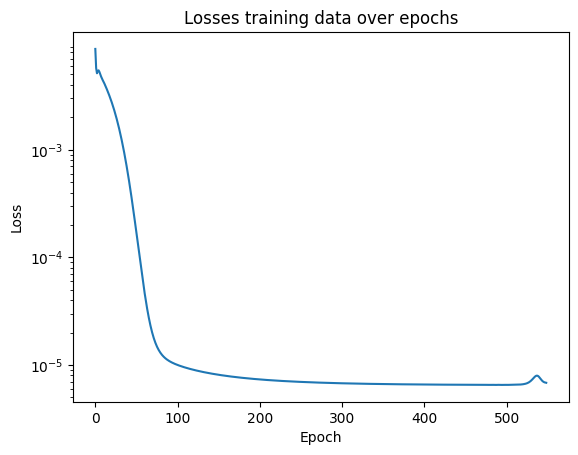

In [43]:
if DEBUG_MODE == True:
    print("Losses head:\n", epoch_losses[0:5])
    print("Losses tail:\n", epoch_losses[len(epoch_losses)-5:])
    print("len(Losses):\n", len(epoch_losses))

# Show graph
plt.plot(epoch_losses, label="Training Loss")
plt.title("Losses training data over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.yticks([10**-5, 10**-4, 10**-3])
plt.show()

Visualization training results

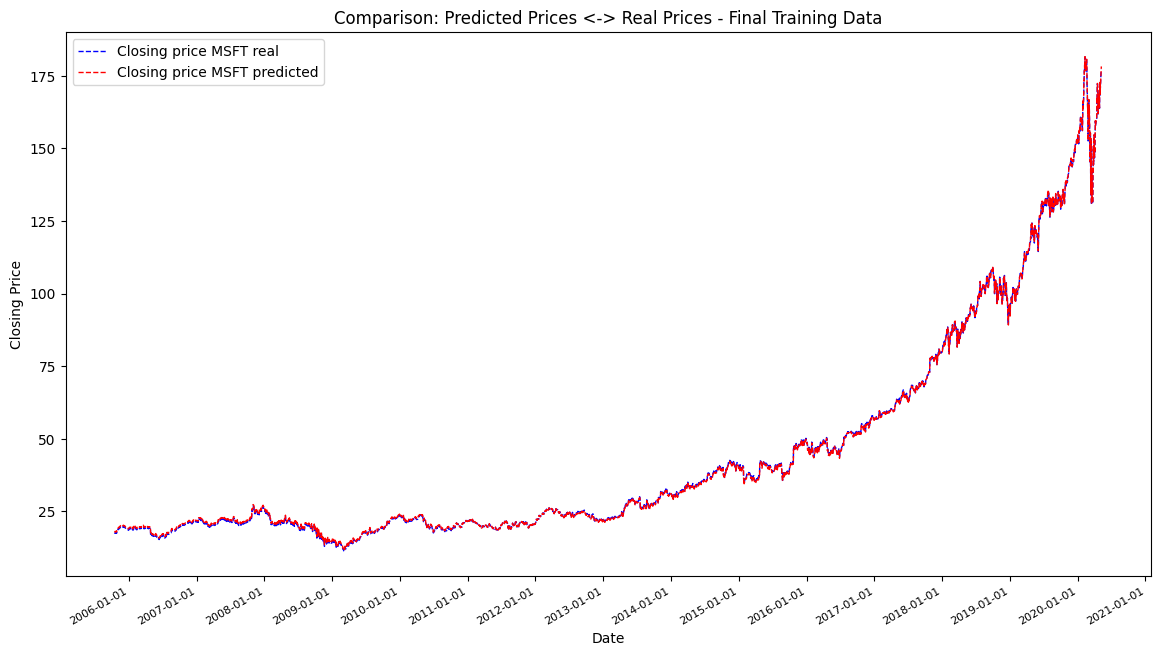

In [44]:
# +++ Visualize Training data: predicted values <-> real values +++
# Apply inverse transformation on predicted closing prices
outputs_transf = target_scaler.inverse_transform(outputs.detach().numpy().reshape(-1, 1))
# retrieve date range
offset = dict_offsets["Train"]["offset"]  # training data in input data
last_idx = offset + dict_offsets["Train"]["len"] - 1
date_range = data_in["Date"].iloc[offset:last_idx].reset_index(drop=True)
visualize_predicted_real(
    outputs_transf,
    data_in["Close"][offset:last_idx].reset_index(drop=True),
    #target[offset:last_idx].reset_index(drop=True),
    date_range=date_range,
    data_set_name="Final Training Data",
)

Add predictions to data

In [45]:
# Add predictions and target info (close_next_day) to data (for easier verification)
data_in["predicted"] = 0
data_in["pred_err_perc"] = 0
data_in["close_next_day"] = data_in["Close"].shift(-1)

add_predictions(data_in, dict_offsets["Train"], "predicted", outputs_transf)

Check for outliers in prediction (training data)

In [46]:
# Search for outliers in predictions (training data):
# predicted price differs more than (limit*100)% to real stock price
num_exceeded = search_anomalies(data_in, dict_offsets["Train"])
# save number of outliers in results
dict_results["Train"]["outliers"] = num_exceeded
print_debug(dict_results["Train"])

Number of predictions with deviation >= 0.1: 15
Date: 2006-04-28 00:00:00, error: 0.155549821, predicted: 19.779205322265625, price: 17.1167049407959
Date: 2008-09-29 00:00:00, error: 0.122546996, predicted: 20.628124237060547, price: 18.37617874145508
Date: 2008-10-07 00:00:00, error: 0.101255299, predicted: 18.796560287475586, price: 17.06830406188965
Date: 2008-10-13 00:00:00, error: -0.13065267, predicted: 16.28826904296875, price: 18.736204147338867
Date: 2008-10-22 00:00:00, error: 0.116137, predicted: 17.656431198120117, price: 15.819232940673828
Date: 2008-11-19 00:00:00, error: 0.108908647, predicted: 15.00317096710205, price: 13.529672622680664
Date: 2008-12-01 00:00:00, error: 0.122117503, predicted: 15.447497367858887, price: 13.76638126373291
Date: 2009-01-20 00:00:00, error: 0.102382739, predicted: 15.069811820983887, price: 13.670217514038086
Date: 2009-01-22 00:00:00, error: 0.171342138, predicted: 14.82542896270752, price: 12.656787872314451
Date: 2009-07-24 00:00:00, 

/var/folders/63/3r98hjf137z17dq5ttq7swyc0000gn/T/ipykernel_41671/1242170906.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Visualize deviation of training data with KDE (Kernel Density Estimate) 

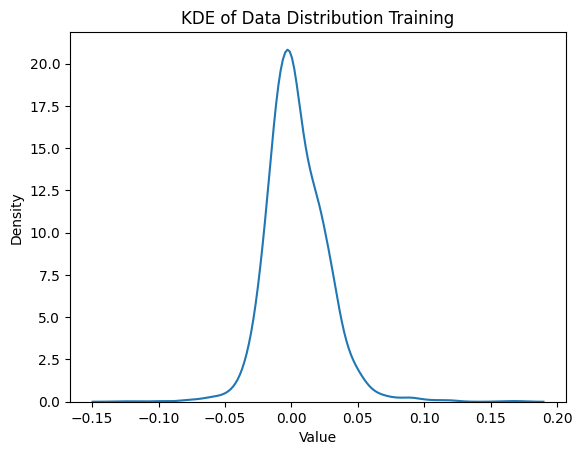

In [47]:
# visualize deviation as KDE (Kernel density estimate)
curDict = dict_offsets["Train"]
# skip last element (no prediction)
data_KDE = data_in.loc[ curDict["offset"] : curDict["offset"] + curDict["len"] - 1 - 1, "pred_err_perc" ]
plt_KDE(round(data_KDE, ndigits=2), dataset_name = "Training")

**+++ TEST DATA +++**

Apply model to test data

In [48]:
# Execute model on test data
predicted_stock_price, losses, mae_test = eval_model(model, criterion, test_tensor, test_closing_prices_tensor)

# Save information in results
dict_results["Test"]["loss"] = losses.item()
dict_results["Test"]["mae"] = mae_test

# Apply inverse transformation on predicted closing prices
predicted_stock_price_2d = predicted_stock_price.detach().numpy().reshape(-1, 1)
predicted_stock_price = target_scaler.inverse_transform(predicted_stock_price_2d)

Validation, loss:  7.940077193779871e-05
Validation, MAE:  0.009520761


Visualization Test Results

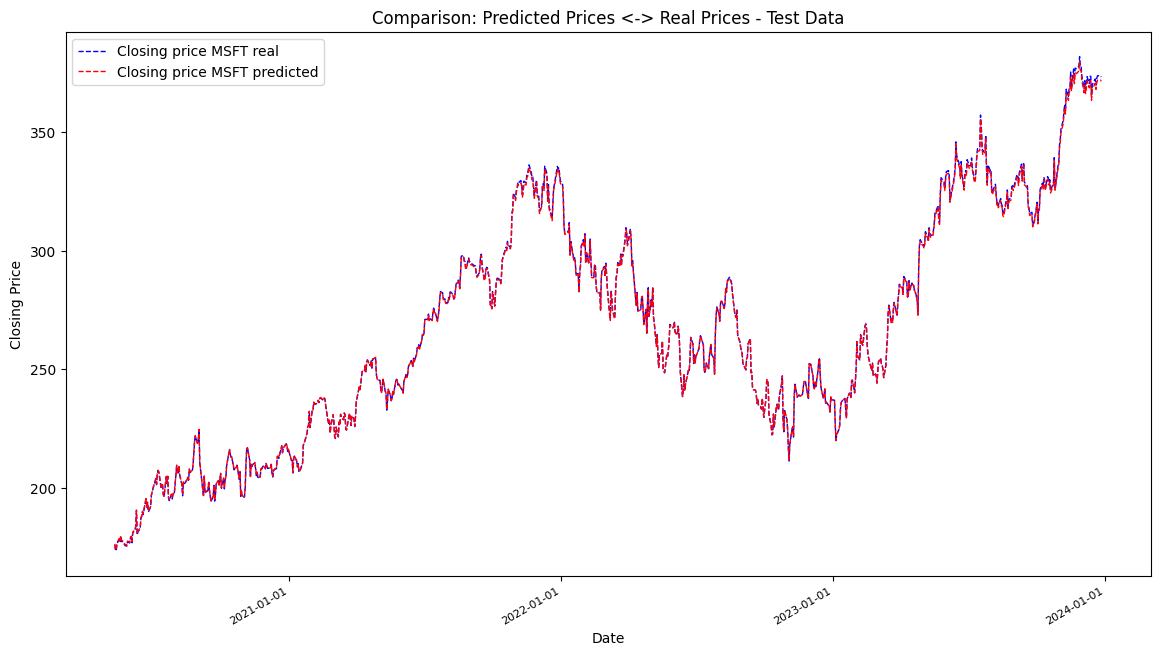

In [49]:
# +++ Visualize Results with Test Data: Predicted Values <-> Real Values +++
# retrieve date range
offset = dict_offsets["Test"]["offset"]  # training data in input data
last_idx = offset + dict_offsets["Test"]["len"] - 1
date_range = data_in["Date"].iloc[offset:last_idx].reset_index(drop=True)
visualize_predicted_real(
    predicted_stock_price,
    data_in["Close"][offset:last_idx].reset_index(drop=True),
    date_range=date_range,
    data_set_name="Test Data",
)

In [50]:
# Add predictions from test to data
add_predictions(data_in, dict_offsets["Test"], "predicted", predicted_stock_price)

Check for outliers in prediction (test data)

In [51]:
# Search for outliers in predictions (test data):
#  predicted price differs more than (limit*100)% from real stock price
num_exceeded = search_anomalies(data_in, dict_offsets["Test"])
# save number of outliers in results
dict_results["Test"]["outliers"] = num_exceeded
print_debug(dict_results)

Number of predictions with deviation >= 0.1: 0


/var/folders/63/3r98hjf137z17dq5ttq7swyc0000gn/T/ipykernel_41671/1242170906.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [52]:
# Store data:
data_in.to_csv(DATA_PATH_MSFT_ENH, float_format=FLOAT_FORMAT, index=False)

Visualize deviation of test data with KDE (Kernel Density Estimate) 

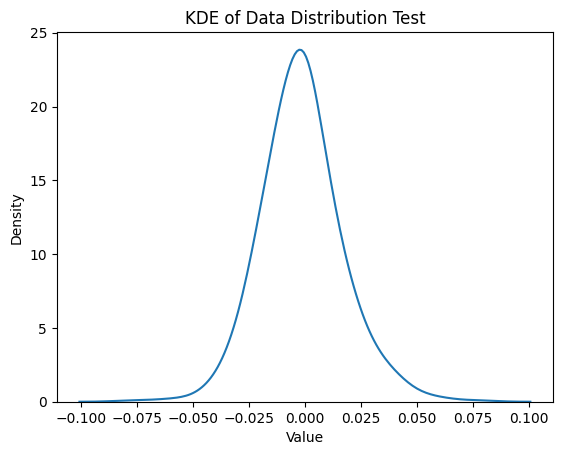

In [53]:
# visualize deviation as KDE (Kernel density estimate)
curDict = dict_offsets["Test"]
data_KDE = data_in.loc[ curDict["offset"] : curDict["offset"] + curDict["len"] - 1 - 1, "pred_err_perc" ]
plt_KDE(round(data_KDE, ndigits=2), dataset_name="Test")

Store results in file

In [54]:
# Store all results of current execution in csv as first line
print_debug(dict_results)

# convert float32 where necessary:
dict_conv = convert_float32(dict_results)
# Flatten the dictionary
flattened_dict = flatten_dict(dict_conv)
# avoid scientific notation
formatted_flattened_dict = {
    k: f"{v:.8f}" if isinstance(v, float) else v for k, v in flattened_dict.items()
}

# Check if the file exists to determine if headers are needed
file_exists = Path(DATA_PATH_RESULTS_CSV).is_file()

data_rows = []
if file_exists == True:
    with open(DATA_PATH_RESULTS_CSV, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        header_row = reader.fieldnames
        data_rows = [row for row in reader]

# Insert the new row at the beginning
data_rows.insert(0, flattened_dict)

with open(DATA_PATH_RESULTS_CSV, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=flattened_dict.keys())
    writer.writeheader()  # Write headers if file does not exist
    writer.writerows(data_rows)

**+++ BASELINES +++**

In [55]:
def visualize_baseline(act_price, pred_price, dates=None, baseline_name=""):
    # pred_price = pred_price.values.reshape(-1, 1)

    prt_act_stock = pd.DataFrame(columns=["Date", "Close"])
    prt_act_stock["Close"] = act_price
    prt_act_stock["Date"] = dates
    price_real_dict = plt_set_dict_price(
        prt_act_stock, color="blue", label="Closing price MSFT real"
    )

    prt_pred_stock = pd.DataFrame(columns=["Date", "Close"])
    prt_pred_stock["Close"] = pred_price
    prt_pred_stock["Date"] = dates
    price_pred_dict = plt_set_dict_price(
        prt_pred_stock, color="red", label="Closing price MSFT predicted"
    )

    title = "Comparison closing price MSFT: predicted prices <-> real prices (test data), "
    title += baseline_name
    plt_graphs(price_real_dict, price_pred_dict, title=title, yscale="linear")

    # calculate loss
    scaled_pred_price = target_scaler.fit_transform(pred_price.values.reshape(-1, 1))
    pred_tensor = torch.tensor(scaled_pred_price).float()
    #pred_tensor = torch.tensor(scaled_pred_price.reshape(-1)).float()
    loss_bl = criterion(pred_tensor, test_closing_prices_tensor)
    print_debug("Baseline, loss: ", loss_bl)

    # calculate MAE
    mae_bl = mean_absolute_error(scaled_pred_price, test_closing_prices)
    
    return loss_bl, mae_bl

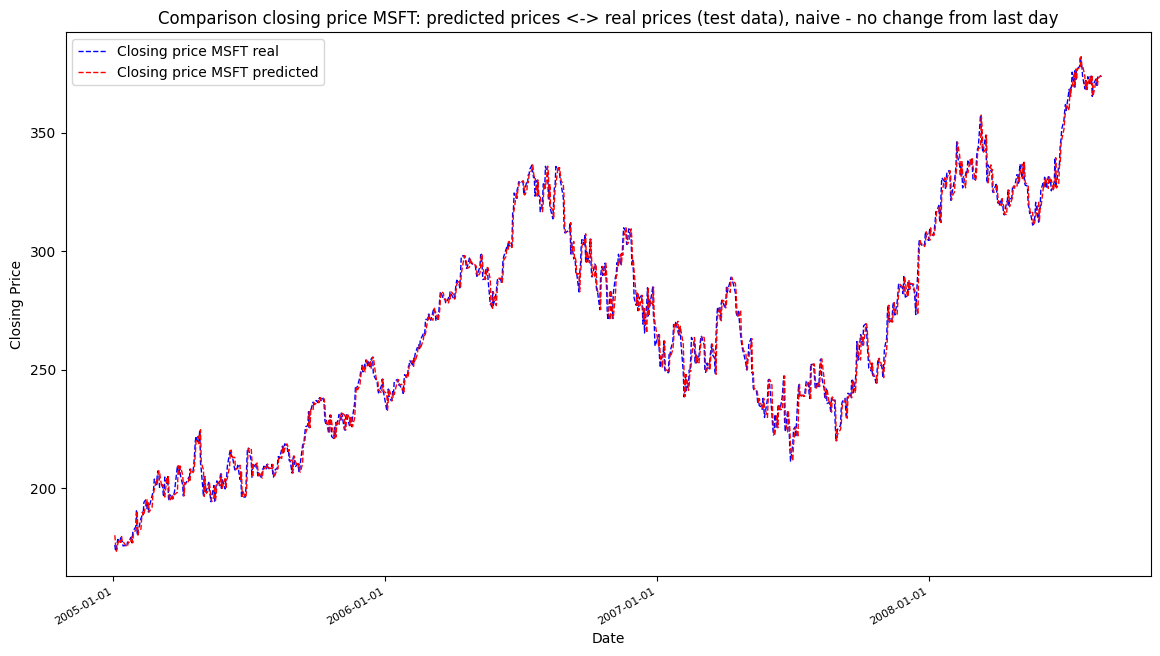

Baseline 1 (no change next day): Loss: 0.0345572791993618, MAE: 0.24157907000120052


In [56]:
# Baseline 1: Assume that close doesn't change at all next day
# act_stock_price = target.iloc[round(len(scaled_closing_prices)*SPLIT_FACTOR) : ].reset_index(drop=True)
# act_stock_price = target.iloc[dict_offsets["Test"]["offset"] : ].reset_index(drop=True)

DEBUG_MODE = False
act_stock_price = data_in.iloc[dict_offsets["Test"]["offset"] : -1]["Close"].reset_index(drop=True)
xx_act_stock_price = scaled_closing_prices[dict_offsets["Test"]["offset"] : -1 ]
print_debug("offset test:", dict_offsets["Test"]["offset"])
print_debug(act_stock_price.shape)
print_debug(scaled_closing_prices.shape)
print_debug(xx_act_stock_price.shape)
print_debug(act_stock_price)
print_debug(xx_act_stock_price)
DEBUG_MODE = False

# add row for prediction at the beginning
first_el = pd.Series(data_in.iloc[dict_offsets["Test"]["offset"] -1]["Close"])
pred_stock_price_naive_1 = pd.concat([first_el, act_stock_price[:-1]]).reset_index(drop=True)

loss_bl, mae_bl = visualize_baseline(act_stock_price,
                            pred_stock_price_naive_1,
                            dates=data_in["Date"].iloc[:last_idx].reset_index(drop=True),
                            baseline_name= "naive - no change from last day"
                            )

print(f"Baseline 1 (no change next day): Loss: {loss_bl}, MAE: {mae_bl}")

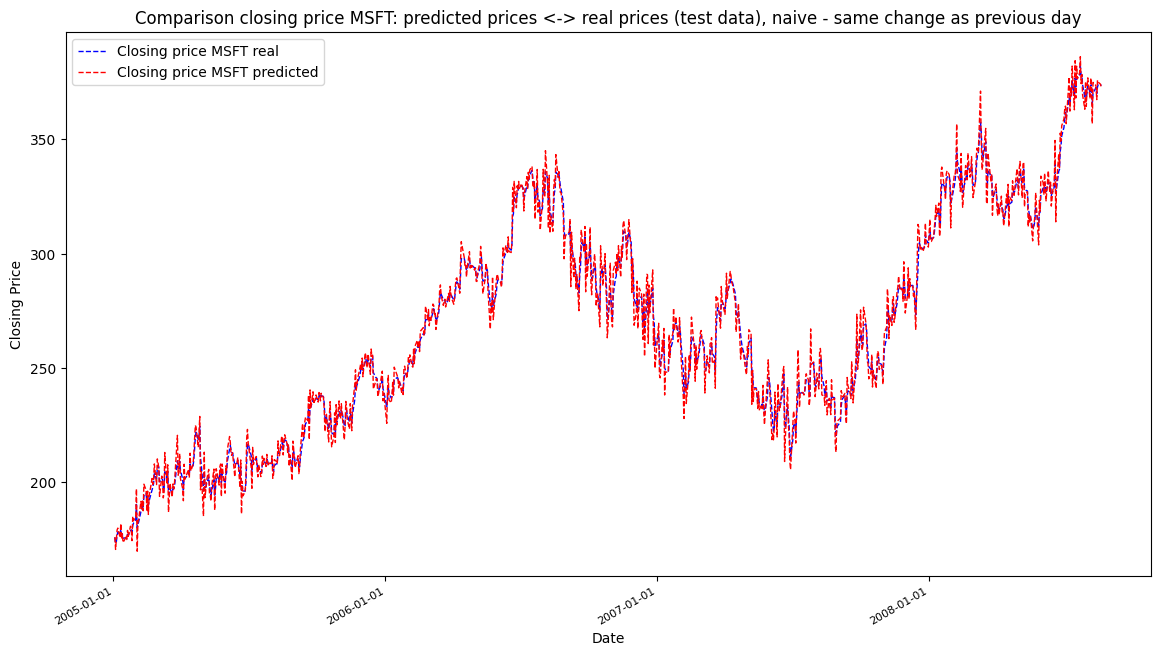

Baseline 2 ( same change as previous day): Loss: 0.033479366451501846, MAE: 0.23940462063721488


In [57]:
# Baseline 2: Assume that close changes the same way as previous day

pred_stock_price_naive_2 = np.zeros(act_stock_price.shape[0])
for iter in range(act_stock_price.shape[0]):
    if iter == 0:
        last_close = act_stock_price[iter]
    else:
        last_close = act_stock_price[iter - 1]
    pred_stock_price_naive_2[iter] = act_stock_price[iter] + (
        act_stock_price[iter] - last_close
    )

pred_stock_price_naive_2 = pred_stock_price_naive_2.reshape(-1)
loss_bl, mae_bl = visualize_baseline(
                act_stock_price,
                pd.Series(pred_stock_price_naive_2),
                dates=data_in["Date"].iloc[:last_idx].reset_index(drop=True),
                baseline_name="naive - same change as previous day",
)

print(f"Baseline 2 ( same change as previous day): Loss: {loss_bl}, MAE: {mae_bl}")

BL3: MAE calculated: 0.0006237406913048856


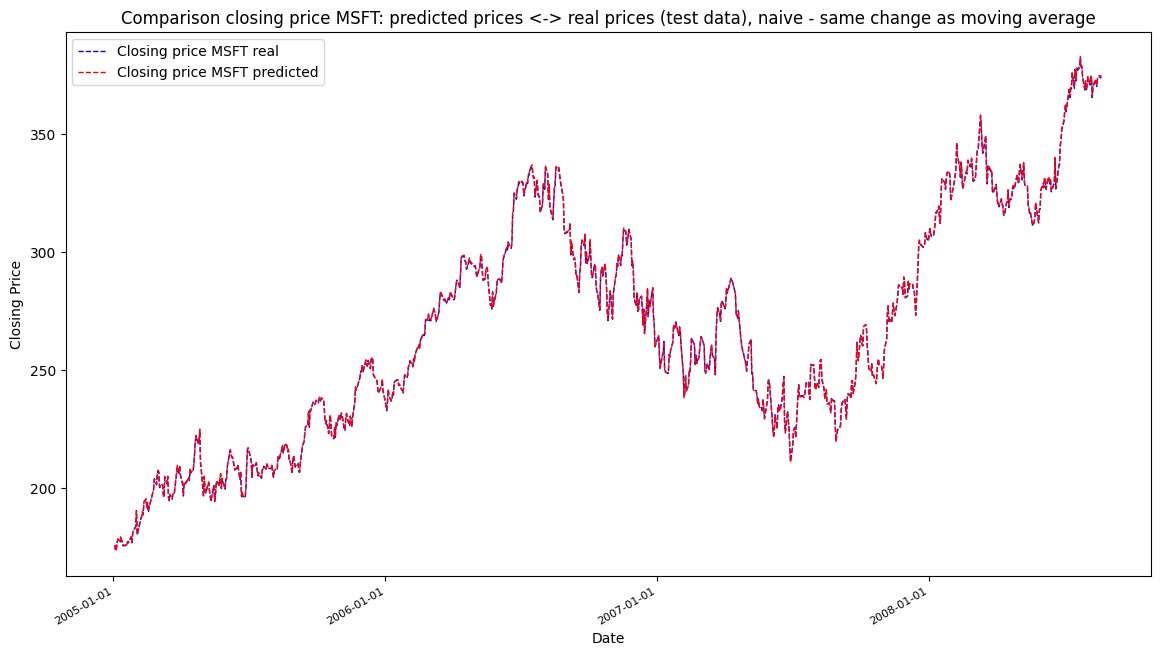

Baseline 3 ( same change as moving average): Loss: 0.0006419316050596535, MAE: 0.01317250825379261


In [58]:
# Baseline 3: Assume that close changes same way as moving average
mv_avg_price = data_in.iloc[dict_offsets["Test"]["offset"] : -1]["MSFT-MV_AVG"].reset_index(drop=True)
pred_stock_price_naive_3 = np.zeros(act_stock_price.shape[0])
for iter in range(act_stock_price.shape[0]-1):
    mae_sum = 0
    if iter == 0:
        # last_close = act_stock_price[iter]
        last_mv_avg = mv_avg_price[iter]
    else:
        # last_close = act_stock_price[iter - 1]
        last_mv_avg = mv_avg_price[iter-1]
    pred_stock_price_naive_3[iter] = act_stock_price[iter] + (
        mv_avg_price[iter] - last_mv_avg
    )
    mae_sum += abs(pred_stock_price_naive_3[iter] - act_stock_price[iter+1])

mae_avg = mae_sum / act_stock_price.shape[0]
print(f"BL3: MAE calculated: {mae_avg}")
pred_stock_price_naive_3 = pred_stock_price_naive_3.reshape(-1)
# scaled_pred_price_naive_2 = target_scaler.fit_transform(pred_stock_price_naive_2)
# plt_act_predict(act_stock_price, pred_stock_price_naive_2, "test data")
loss_bl, mae_bl = visualize_baseline(
                act_stock_price,
                pd.Series(pred_stock_price_naive_3),
                dates=data_in["Date"].iloc[:last_idx].reset_index(drop=True),
                baseline_name="naive - same change as moving average",
)

print(f"Baseline 3 ( same change as moving average): Loss: {loss_bl}, MAE: {mae_bl}")